## Hyperparameter Tuning for MLP  
**Date:** May 15, 2025  

### Goal  
Find optimal values for `hidden_dim` and `learning_rate` for the MLP model.

### Fixed Parameters:
- `batch_size = 64`  
- `epochs = 500`  
- `output_dim = 1`

### Parameters to Tune:
- hidden_dim_choices = [64, 128, 192, 256]
- lr_choices = [0.005, 0.01, 0.015, 0.02, 0.025, 0,03]

### Sampling Strategy:
- `hidden_dim` is sampled from a fixed list
- `learning_rate` is sampled uniformly in log scale

### Evaluation Metric:
- `R²` on the test set

In [1]:
# 📦 Imports and Configuration

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


In [2]:
# 📁 src/data/load_dataset.py
# ➤ Function for loading the dataset from CSV

def load_dataset():
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

In [3]:
# 📁 src/tuning/setup_paths.py
# ➤ Paths for hyperparameter search: tuning runs, logs, results

DATA_PATH = "/kaggle/input/wind-pressure-prediction-2025/windloading_interference_base.csv"
SAVE_ROOT = "/kaggle/working"

#DATA_PATH = "/mnt/d/projects/wind_pressure_prediction_2025/data/processed/windloading_interference_base.csv"
#SAVE_ROOT = "/mnt/d/projects/wind_pressure_prediction_2025/experiments"

TUNING_DIR = os.path.join(SAVE_ROOT, "tuning_mlp")
LOG_CSV_PATH = os.path.join(SAVE_ROOT, "experiments_log.csv")

LOG_DIR = os.path.join(SAVE_ROOT, "results", "logs")
WEIGHTS_DIR = os.path.join(SAVE_ROOT, "models", "weights")
CONFIG_DIR = os.path.join(SAVE_ROOT, "models", "configs")
METRICS_DIR = os.path.join(SAVE_ROOT, "results", "metrics")
FIGURES_DIR = os.path.join(SAVE_ROOT, "results", "figures")

#os.makedirs(LOG_DIR, exist_ok=True)
#os.makedirs(WEIGHTS_DIR, exist_ok=True)
#os.makedirs(CONFIG_DIR, exist_ok=True)
#os.makedirs(METRICS_DIR, exist_ok=True)
#os.makedirs(FIGURES_DIR, exist_ok=True)


# Create base result directories

os.makedirs(TUNING_DIR, exist_ok=True)

# Function to create a run-specific directory

def create_run_directory(hidden_dim, lr, batch_size=64, epochs=500, base_dir=TUNING_DIR):
    run_id = f"mlp_{hidden_dim}h_{lr:.0e}lr_{batch_size}bs_{epochs}ep"
    run_dir = os.path.join(base_dir, run_id)
    os.makedirs(run_dir, exist_ok=True)
    print(f"📂 Created run directory: {run_dir}")
    return run_id, run_dir

In [4]:
# 📁 src/metrics/regression_metrics.py
# ➤ Function to compute regression metrics: MSE, MAE, R²

def evaluate_regression(y_true, y_pred):
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()

    mse = mean_squared_error(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    return {"MSE": mse, "MAE": mae, "R2": r2}

In [5]:
# 📁 src/models/mlp_model.py
# ➤ Definition of the MLP architecture 

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
# 📁 src/visualization/plot_metrics.py
# ➤ Visualization of prediction results and training loss

sns.set(style="whitegrid")

def plot_metrics(y_true, y_pred, train_loss_history, val_loss_history, save_dir, show=False):

    if hasattr(y_true, "detach"):
        y_true = y_true.detach().cpu().numpy()
    if hasattr(y_pred, "detach"):
        y_pred = y_pred.detach().cpu().numpy()

    epochs = np.arange(1, len(train_loss_history) + 1)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
    # 1. Scatter
    axes[0].scatter(y_true, y_pred, alpha=0.5, color='royalblue')
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    axes[0].set_title("Predicted vs True, Cp")
    axes[0].set_xlabel("True")
    axes[0].set_ylabel("Predicted")

    # 2. Residuals Histogram
    errors = (y_pred - y_true).flatten() 
    sns.histplot(errors, bins=50, kde=True, ax=axes[1], color='skyblue', edgecolor='black')
    axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[1].set_title("Prediction Error Distribution, Cp")
    axes[1].set_xlabel("Error")
    axes[1].set_ylabel("Count")

    # 3. Train loss
    axes[2].plot(epochs, train_loss_history, label='Train Loss', color='green')
    axes[2].set_title("Training Loss, Cp")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Loss")
    axes[2].legend()

    # Save
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, "loss_plot.png")
    plt.tight_layout()
    plt.savefig(save_path)
    if show:
        plt.show()
    plt.close()

    print(f"📊 Metric saved: {save_path}")
    return save_path


In [7]:
# 📁 src/tuning/train_mlp_function.py
# ➤ Training function for MLP model: used in Random Search and experiment tracking

def train_mlp(hidden_dim, lr, batch_size, epochs, output_dim=1):

    # ----------------------------
    # Load dataset
    # ----------------------------
    df = load_dataset()
    X = df[['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang']]
    y = df[['Mean']]
    input_dim = X.shape[1]

    # ----------------------------
    # Split and tensor conversion
    # ----------------------------
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    X_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32)
    y_test = torch.tensor(y_test.values, dtype=torch.float32)

    # ----------------------------
    # Device and model
    # ----------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🛠 Device: {device}")
    model = MLP(input_dim, hidden_dim, output_dim).to(device)
    X_train, X_test = X_train.to(device), X_test.to(device)
    y_train, y_test = y_train.to(device), y_test.to(device)

    # ----------------------------
    # Run directory
    # ----------------------------
    run_id, run_dir = create_run_directory(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=batch_size,
        epochs=epochs
    )

    # ----------------------------
    # Save config
    # ----------------------------
    config = {
        "input_dim": input_dim,
        "hidden_dim": hidden_dim,
        "output_dim": output_dim,
        "lr": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "features": ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'],
        "targets": ['Mean']
    }
    with open(os.path.join(run_dir, "config.json"), "w") as f:
        json.dump(config, f, indent=4)

    # ----------------------------
    # Training loop
    # ----------------------------
    log_path = os.path.join(run_dir, "train_log.txt")
    with open(log_path, "w") as log_file:
        log_file.write("Epoch\tLoss\n")
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        train_loss_history = []

        for epoch in tqdm(range(epochs), desc="Epochs"):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()

            train_loss_history.append(loss.item())

            if (epoch + 1) % 10 == 0:
                log_str = f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}"
                print(log_str)
                log_file.write(f"{epoch+1}\t{loss.item():.6f}\n")

    # ----------------------------
    # Save weights
    # ----------------------------
    torch.save(model.state_dict(), os.path.join(run_dir, "weights.pth"))

    # ----------------------------
    # Evaluation and saving results
    # ----------------------------
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        metrics = evaluate_regression(y_test, y_pred)

    metrics_clean = {k: float(v) for k, v in metrics.items()}
    with open(os.path.join(run_dir, "metrics.json"), "w") as f:
        json.dump(metrics_clean, f, indent=4)

    print("📈 Evaluation metrics on test set:")
    for name, value in metrics.items():
        print(f"{name}: {value:.4f}")

    # ----------------------------
    # Plot results
    # ----------------------------
    plot_metrics(
        y_test,
        y_pred,
        train_loss_history=train_loss_history,
        val_loss_history=[],
        save_dir=run_dir,
        show=True
    )

    # ----------------------------
    # Append summary to global CSV log
    # ----------------------------
    with open(LOG_CSV_PATH, "a") as f:
        f.write(f"{run_id},{hidden_dim},{lr:.0e},{metrics['R2']:.4f},{metrics['MAE']:.4f},{metrics['MSE']:.6f}\n")

    return run_id, metrics_clean



🔁 Run 1/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   7%|▋         | 35/500 [00:01<00:09, 47.16it/s]

Epoch [10/500], Loss: 0.9407
Epoch [20/500], Loss: 0.7860
Epoch [30/500], Loss: 3.0810
Epoch [40/500], Loss: 0.2453


Epochs:  15%|█▌        | 75/500 [00:01<00:04, 101.77it/s]

Epoch [50/500], Loss: 0.2793
Epoch [60/500], Loss: 0.2412
Epoch [70/500], Loss: 0.2235
Epoch [80/500], Loss: 0.2131
Epoch [90/500], Loss: 0.2206


Epochs:  29%|██▉       | 144/500 [00:01<00:02, 172.17it/s]

Epoch [100/500], Loss: 0.2098
Epoch [110/500], Loss: 0.2052
Epoch [120/500], Loss: 0.1790
Epoch [130/500], Loss: 0.1549
Epoch [140/500], Loss: 0.1325


Epochs:  38%|███▊      | 190/500 [00:01<00:01, 196.31it/s]

Epoch [150/500], Loss: 0.1220
Epoch [160/500], Loss: 0.1173
Epoch [170/500], Loss: 0.1130
Epoch [180/500], Loss: 0.1108
Epoch [190/500], Loss: 0.1089


Epochs:  47%|████▋     | 234/500 [00:02<00:01, 207.30it/s]

Epoch [200/500], Loss: 0.1082
Epoch [210/500], Loss: 0.1052
Epoch [220/500], Loss: 0.1036
Epoch [230/500], Loss: 0.1022
Epoch [240/500], Loss: 0.1014


Epochs:  56%|█████▌    | 279/500 [00:02<00:01, 213.66it/s]

Epoch [250/500], Loss: 0.0990
Epoch [260/500], Loss: 0.0967
Epoch [270/500], Loss: 0.1003
Epoch [280/500], Loss: 0.0992
Epoch [290/500], Loss: 0.0914


Epochs:  65%|██████▍   | 324/500 [00:02<00:00, 216.66it/s]

Epoch [300/500], Loss: 0.0894
Epoch [310/500], Loss: 0.0872
Epoch [320/500], Loss: 0.0861
Epoch [330/500], Loss: 0.0852
Epoch [340/500], Loss: 0.0842


Epochs:  79%|███████▊  | 393/500 [00:02<00:00, 220.19it/s]

Epoch [350/500], Loss: 0.0834
Epoch [360/500], Loss: 0.0822
Epoch [370/500], Loss: 0.0818
Epoch [380/500], Loss: 0.0811
Epoch [390/500], Loss: 0.0800


Epochs:  88%|████████▊ | 439/500 [00:02<00:00, 221.21it/s]

Epoch [400/500], Loss: 0.0793
Epoch [410/500], Loss: 0.1209
Epoch [420/500], Loss: 0.0919
Epoch [430/500], Loss: 0.0819
Epoch [440/500], Loss: 0.0802


Epochs:  97%|█████████▋| 485/500 [00:03<00:00, 221.76it/s]

Epoch [450/500], Loss: 0.0794
Epoch [460/500], Loss: 0.0789
Epoch [470/500], Loss: 0.0784
Epoch [480/500], Loss: 0.0779
Epoch [490/500], Loss: 0.0775


Epochs: 100%|██████████| 500/500 [00:03<00:00, 153.55it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0771
📈 Evaluation metrics on test set:
MSE: 0.0772
MAE: 0.1968
R2: 0.6873


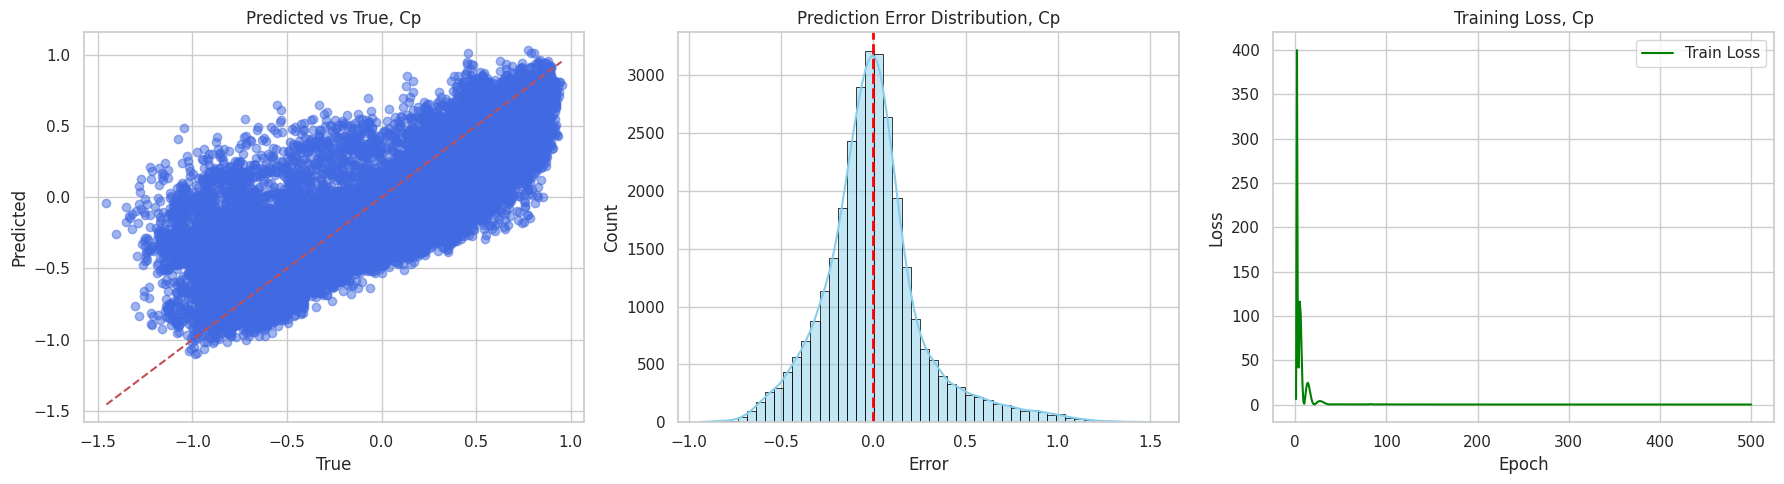

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 2/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   3%|▎         | 17/500 [00:00<00:02, 162.51it/s]

Epoch [10/500], Loss: 4.7591
Epoch [20/500], Loss: 2.4941
Epoch [30/500], Loss: 0.2703


Epochs:   7%|▋         | 35/500 [00:00<00:02, 169.64it/s]

Epoch [40/500], Loss: 0.2640


Epochs:  16%|█▌        | 78/500 [00:00<00:02, 195.31it/s]

Epoch [50/500], Loss: 0.2215
Epoch [60/500], Loss: 0.2143
Epoch [70/500], Loss: 0.2056
Epoch [80/500], Loss: 0.1983
Epoch [90/500], Loss: 0.1947


Epochs:  25%|██▍       | 124/500 [00:00<00:01, 210.89it/s]

Epoch [100/500], Loss: 0.1914
Epoch [110/500], Loss: 0.1872
Epoch [120/500], Loss: 0.3302
Epoch [130/500], Loss: 0.1564
Epoch [140/500], Loss: 0.1321


Epochs:  34%|███▍      | 170/500 [00:00<00:01, 217.45it/s]

Epoch [150/500], Loss: 0.2289
Epoch [160/500], Loss: 0.1195
Epoch [170/500], Loss: 0.1135
Epoch [180/500], Loss: 0.1105


Epochs:  39%|███▊      | 193/500 [00:00<00:01, 219.10it/s]

Epoch [190/500], Loss: 0.1075


Epochs:  43%|████▎     | 216/500 [00:01<00:01, 220.38it/s]

Epoch [200/500], Loss: 0.1055
Epoch [210/500], Loss: 0.1039
Epoch [220/500], Loss: 0.1025
Epoch [230/500], Loss: 0.1012


Epochs:  48%|████▊     | 239/500 [00:01<00:01, 221.29it/s]

Epoch [240/500], Loss: 0.1001


Epochs:  52%|█████▏    | 262/500 [00:01<00:01, 221.33it/s]

Epoch [250/500], Loss: 0.0990
Epoch [260/500], Loss: 0.0978
Epoch [270/500], Loss: 0.0967
Epoch [280/500], Loss: 0.0955


Epochs:  57%|█████▋    | 285/500 [00:01<00:00, 221.76it/s]

Epoch [290/500], Loss: 0.0944


Epochs:  66%|██████▌   | 331/500 [00:01<00:00, 222.50it/s]

Epoch [300/500], Loss: 0.0932
Epoch [310/500], Loss: 0.0920
Epoch [320/500], Loss: 0.0908
Epoch [330/500], Loss: 0.0896
Epoch [340/500], Loss: 0.0886


Epochs:  75%|███████▌  | 377/500 [00:01<00:00, 222.47it/s]

Epoch [350/500], Loss: 0.0876
Epoch [360/500], Loss: 0.0865
Epoch [370/500], Loss: 0.0854
Epoch [380/500], Loss: 0.0843
Epoch [390/500], Loss: 0.0831


Epochs:  85%|████████▍ | 423/500 [00:01<00:00, 223.04it/s]

Epoch [400/500], Loss: 0.0820
Epoch [410/500], Loss: 0.0808
Epoch [420/500], Loss: 0.0797
Epoch [430/500], Loss: 0.0799
Epoch [440/500], Loss: 0.0807


Epochs:  94%|█████████▍| 469/500 [00:02<00:00, 222.96it/s]

Epoch [450/500], Loss: 0.0790
Epoch [460/500], Loss: 0.0772
Epoch [470/500], Loss: 0.0766
Epoch [480/500], Loss: 0.0756


Epochs:  98%|█████████▊| 492/500 [00:02<00:00, 222.22it/s]

Epoch [490/500], Loss: 0.0747


Epochs: 100%|██████████| 500/500 [00:02<00:00, 216.32it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0741
📈 Evaluation metrics on test set:
MSE: 0.0757
MAE: 0.1889
R2: 0.6959


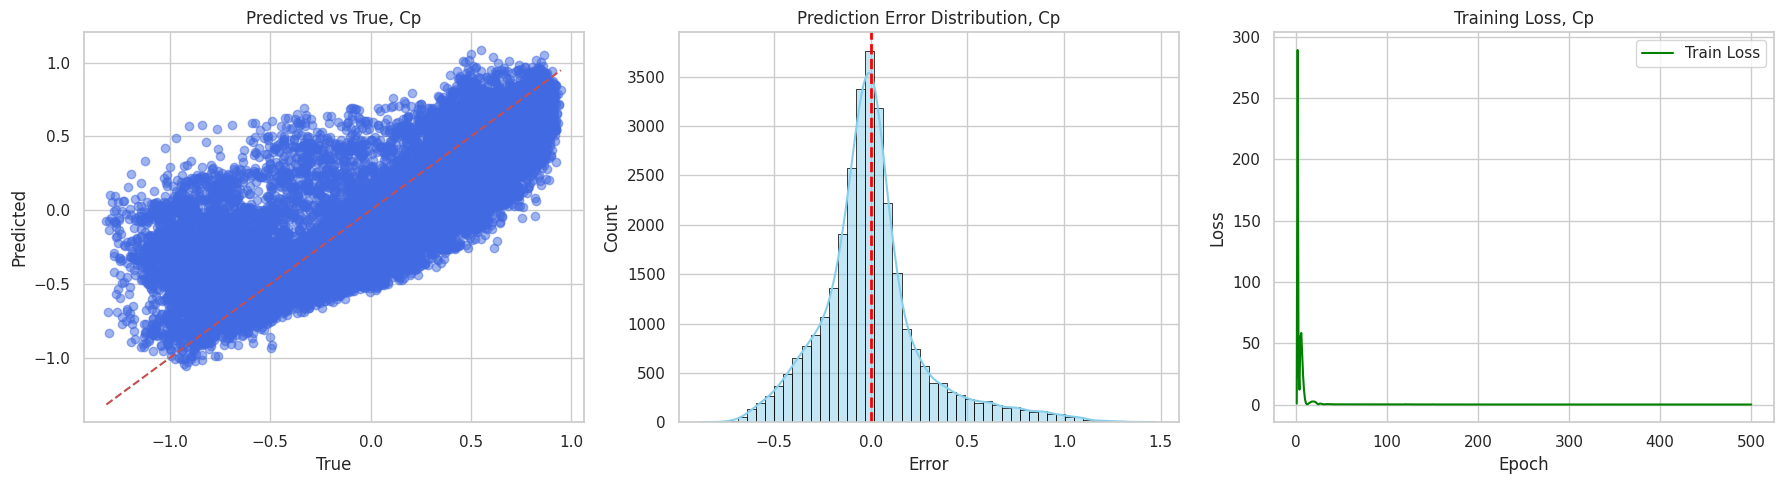

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 3/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 46/500 [00:00<00:02, 223.29it/s]

Epoch [10/500], Loss: 0.5990
Epoch [20/500], Loss: 0.2433
Epoch [30/500], Loss: 0.4003
Epoch [40/500], Loss: 0.2917
Epoch [50/500], Loss: 0.2353


Epochs:  18%|█▊        | 92/500 [00:00<00:01, 222.48it/s]

Epoch [60/500], Loss: 0.2279
Epoch [70/500], Loss: 0.2144
Epoch [80/500], Loss: 0.1961
Epoch [90/500], Loss: 0.1565
Epoch [100/500], Loss: 0.1362


Epochs:  28%|██▊       | 138/500 [00:00<00:01, 222.92it/s]

Epoch [110/500], Loss: 0.1265
Epoch [120/500], Loss: 0.1199
Epoch [130/500], Loss: 0.1147
Epoch [140/500], Loss: 0.1108
Epoch [150/500], Loss: 0.1096


Epochs:  37%|███▋      | 184/500 [00:00<00:01, 222.74it/s]

Epoch [160/500], Loss: 0.1061
Epoch [170/500], Loss: 0.1042
Epoch [180/500], Loss: 0.1024
Epoch [190/500], Loss: 0.1007
Epoch [200/500], Loss: 0.0991


Epochs:  51%|█████     | 253/500 [00:01<00:01, 221.85it/s]

Epoch [210/500], Loss: 0.0977
Epoch [220/500], Loss: 0.0998
Epoch [230/500], Loss: 0.0958
Epoch [240/500], Loss: 0.0942
Epoch [250/500], Loss: 0.0928


Epochs:  60%|█████▉    | 299/500 [00:01<00:00, 222.36it/s]

Epoch [260/500], Loss: 0.0914
Epoch [270/500], Loss: 0.0903
Epoch [280/500], Loss: 0.0895
Epoch [290/500], Loss: 0.0899
Epoch [300/500], Loss: 0.0878


Epochs:  69%|██████▉   | 345/500 [00:01<00:00, 222.33it/s]

Epoch [310/500], Loss: 0.0871
Epoch [320/500], Loss: 0.0861
Epoch [330/500], Loss: 0.0858
Epoch [340/500], Loss: 0.0847
Epoch [350/500], Loss: 0.0858


Epochs:  78%|███████▊  | 391/500 [00:01<00:00, 222.39it/s]

Epoch [360/500], Loss: 0.0832
Epoch [370/500], Loss: 0.0830
Epoch [380/500], Loss: 0.0822
Epoch [390/500], Loss: 0.0818
Epoch [400/500], Loss: 0.0836


Epochs:  87%|████████▋ | 437/500 [00:01<00:00, 222.45it/s]

Epoch [410/500], Loss: 0.0827
Epoch [420/500], Loss: 0.0813
Epoch [430/500], Loss: 0.0805
Epoch [440/500], Loss: 0.0802
Epoch [450/500], Loss: 0.0798


Epochs: 100%|██████████| 500/500 [00:02<00:00, 222.30it/s]

Epoch [460/500], Loss: 0.0802
Epoch [470/500], Loss: 0.0807
Epoch [480/500], Loss: 0.0788
Epoch [490/500], Loss: 0.0787
Epoch [500/500], Loss: 0.0781
📈 Evaluation metrics on test set:
MSE: 0.0780
MAE: 0.2004
R2: 0.6836



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


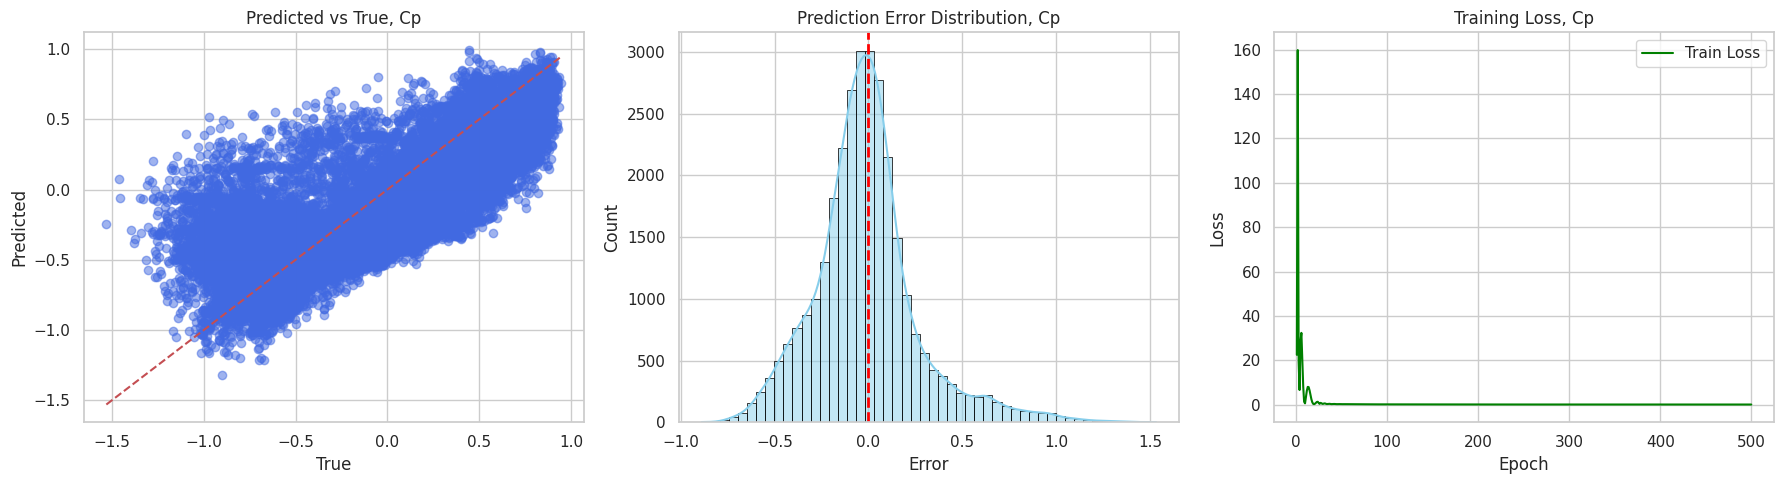

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 4/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 44/500 [00:00<00:02, 202.13it/s]

Epoch [10/500], Loss: 0.7576
Epoch [20/500], Loss: 0.7204
Epoch [30/500], Loss: 0.2258
Epoch [40/500], Loss: 0.2975


Epochs:  18%|█▊        | 89/500 [00:00<00:01, 213.17it/s]

Epoch [50/500], Loss: 0.2475
Epoch [60/500], Loss: 0.2177
Epoch [70/500], Loss: 0.2124
Epoch [80/500], Loss: 0.2090
Epoch [90/500], Loss: 0.2061


Epochs:  27%|██▋       | 135/500 [00:00<00:01, 218.80it/s]

Epoch [100/500], Loss: 0.2020
Epoch [110/500], Loss: 0.1988
Epoch [120/500], Loss: 0.1957
Epoch [130/500], Loss: 0.1847
Epoch [140/500], Loss: 0.1652


Epochs:  36%|███▌      | 181/500 [00:00<00:01, 220.30it/s]

Epoch [150/500], Loss: 0.1513
Epoch [160/500], Loss: 0.1383
Epoch [170/500], Loss: 0.1324
Epoch [180/500], Loss: 0.1226
Epoch [190/500], Loss: 0.1162


Epochs:  45%|████▌     | 227/500 [00:01<00:01, 221.56it/s]

Epoch [200/500], Loss: 0.1125
Epoch [210/500], Loss: 0.1099
Epoch [220/500], Loss: 0.1078
Epoch [230/500], Loss: 0.1058
Epoch [240/500], Loss: 0.1062


Epochs:  55%|█████▍    | 273/500 [00:01<00:01, 221.47it/s]

Epoch [250/500], Loss: 0.1024
Epoch [260/500], Loss: 0.1034
Epoch [270/500], Loss: 0.1071
Epoch [280/500], Loss: 0.0988
Epoch [290/500], Loss: 0.0946


Epochs:  68%|██████▊   | 342/500 [00:01<00:00, 221.86it/s]

Epoch [300/500], Loss: 0.0929
Epoch [310/500], Loss: 0.0971
Epoch [320/500], Loss: 0.1018
Epoch [330/500], Loss: 0.0923
Epoch [340/500], Loss: 0.0900


Epochs:  78%|███████▊  | 388/500 [00:01<00:00, 221.83it/s]

Epoch [350/500], Loss: 0.0885
Epoch [360/500], Loss: 0.0871
Epoch [370/500], Loss: 0.0862
Epoch [380/500], Loss: 0.0849
Epoch [390/500], Loss: 0.0850


Epochs:  87%|████████▋ | 434/500 [00:01<00:00, 221.93it/s]

Epoch [400/500], Loss: 0.0839
Epoch [410/500], Loss: 0.0830
Epoch [420/500], Loss: 0.0845
Epoch [430/500], Loss: 0.0830
Epoch [440/500], Loss: 0.0816


Epochs:  96%|█████████▌| 480/500 [00:02<00:00, 222.09it/s]

Epoch [450/500], Loss: 0.0808
Epoch [460/500], Loss: 0.0910
Epoch [470/500], Loss: 0.0814
Epoch [480/500], Loss: 0.0807
Epoch [490/500], Loss: 0.0797


Epochs: 100%|██████████| 500/500 [00:02<00:00, 219.93it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0790
📈 Evaluation metrics on test set:
MSE: 0.0793
MAE: 0.2010
R2: 0.6845


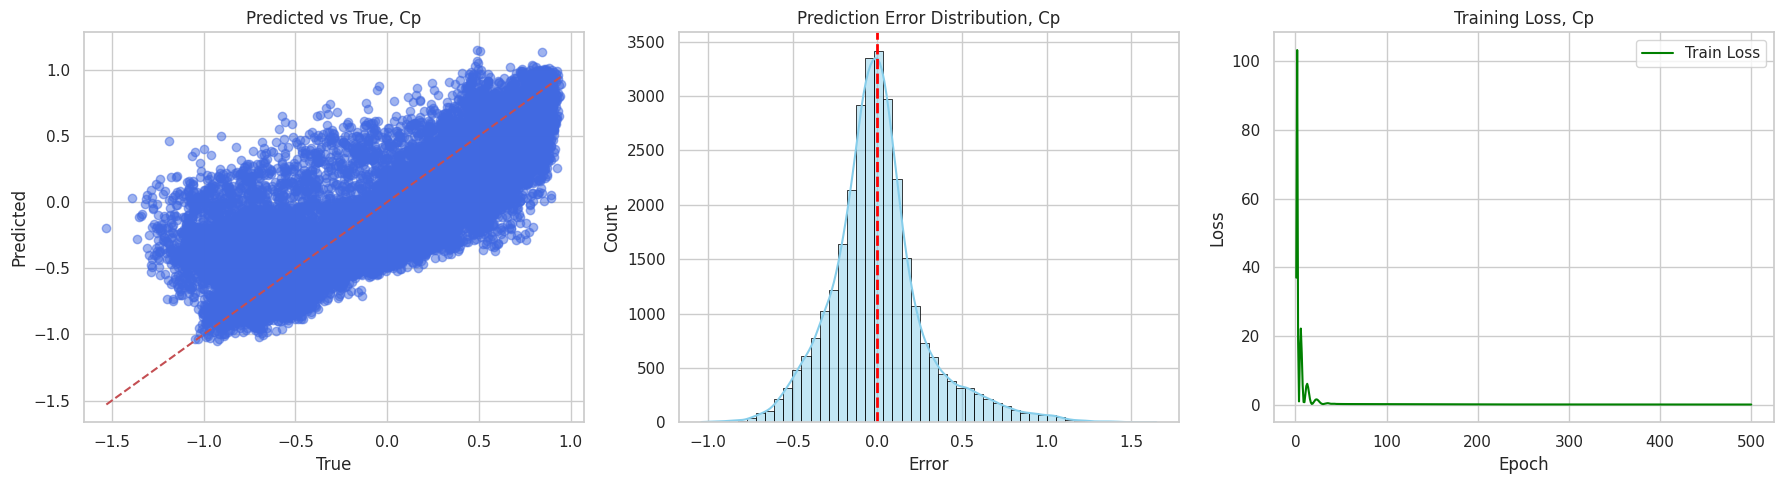

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 5/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   3%|▎         | 17/500 [00:00<00:02, 162.79it/s]

Epoch [10/500], Loss: 0.7995
Epoch [20/500], Loss: 0.4468
Epoch [30/500], Loss: 0.8523


Epochs:   7%|▋         | 35/500 [00:00<00:02, 171.15it/s]

Epoch [40/500], Loss: 0.2386


Epochs:  15%|█▌        | 77/500 [00:00<00:02, 194.75it/s]

Epoch [50/500], Loss: 0.2305
Epoch [60/500], Loss: 0.1872
Epoch [70/500], Loss: 0.1546
Epoch [80/500], Loss: 0.1687
Epoch [90/500], Loss: 0.1475


Epochs:  25%|██▍       | 123/500 [00:00<00:01, 210.99it/s]

Epoch [100/500], Loss: 0.1336
Epoch [110/500], Loss: 0.1237
Epoch [120/500], Loss: 0.1165
Epoch [130/500], Loss: 0.1105
Epoch [140/500], Loss: 0.1062


Epochs:  34%|███▍      | 169/500 [00:00<00:01, 216.90it/s]

Epoch [150/500], Loss: 0.1026
Epoch [160/500], Loss: 0.1000
Epoch [170/500], Loss: 0.0978
Epoch [180/500], Loss: 0.0957


Epochs:  38%|███▊      | 192/500 [00:00<00:01, 218.32it/s]

Epoch [190/500], Loss: 0.0936


Epochs:  43%|████▎     | 215/500 [00:01<00:01, 219.62it/s]

Epoch [200/500], Loss: 0.0905
Epoch [210/500], Loss: 0.0884
Epoch [220/500], Loss: 0.0858
Epoch [230/500], Loss: 0.0840


Epochs:  48%|████▊     | 238/500 [00:01<00:01, 220.23it/s]

Epoch [240/500], Loss: 0.0808


Epochs:  57%|█████▋    | 284/500 [00:01<00:00, 220.87it/s]

Epoch [250/500], Loss: 0.0786
Epoch [260/500], Loss: 0.0772
Epoch [270/500], Loss: 0.0756
Epoch [280/500], Loss: 0.0744
Epoch [290/500], Loss: 0.0739


Epochs:  66%|██████▌   | 330/500 [00:01<00:00, 221.60it/s]

Epoch [300/500], Loss: 0.0727
Epoch [310/500], Loss: 0.0713
Epoch [320/500], Loss: 0.0703
Epoch [330/500], Loss: 0.0695
Epoch [340/500], Loss: 0.0687


Epochs:  75%|███████▌  | 376/500 [00:01<00:00, 221.59it/s]

Epoch [350/500], Loss: 0.0677
Epoch [360/500], Loss: 0.0671
Epoch [370/500], Loss: 0.0666
Epoch [380/500], Loss: 0.0663
Epoch [390/500], Loss: 0.0645


Epochs:  84%|████████▍ | 422/500 [00:01<00:00, 221.63it/s]

Epoch [400/500], Loss: 0.0648
Epoch [410/500], Loss: 0.0644
Epoch [420/500], Loss: 0.0627
Epoch [430/500], Loss: 0.0614
Epoch [440/500], Loss: 0.0607


Epochs:  94%|█████████▎| 468/500 [00:02<00:00, 221.92it/s]

Epoch [450/500], Loss: 0.0654
Epoch [460/500], Loss: 0.0620
Epoch [470/500], Loss: 0.0587
Epoch [480/500], Loss: 0.0583


Epochs:  98%|█████████▊| 491/500 [00:02<00:00, 221.65it/s]

Epoch [490/500], Loss: 0.0573


Epochs: 100%|██████████| 500/500 [00:02<00:00, 215.74it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0579
📈 Evaluation metrics on test set:
MSE: 0.0576
MAE: 0.1622
R2: 0.7674


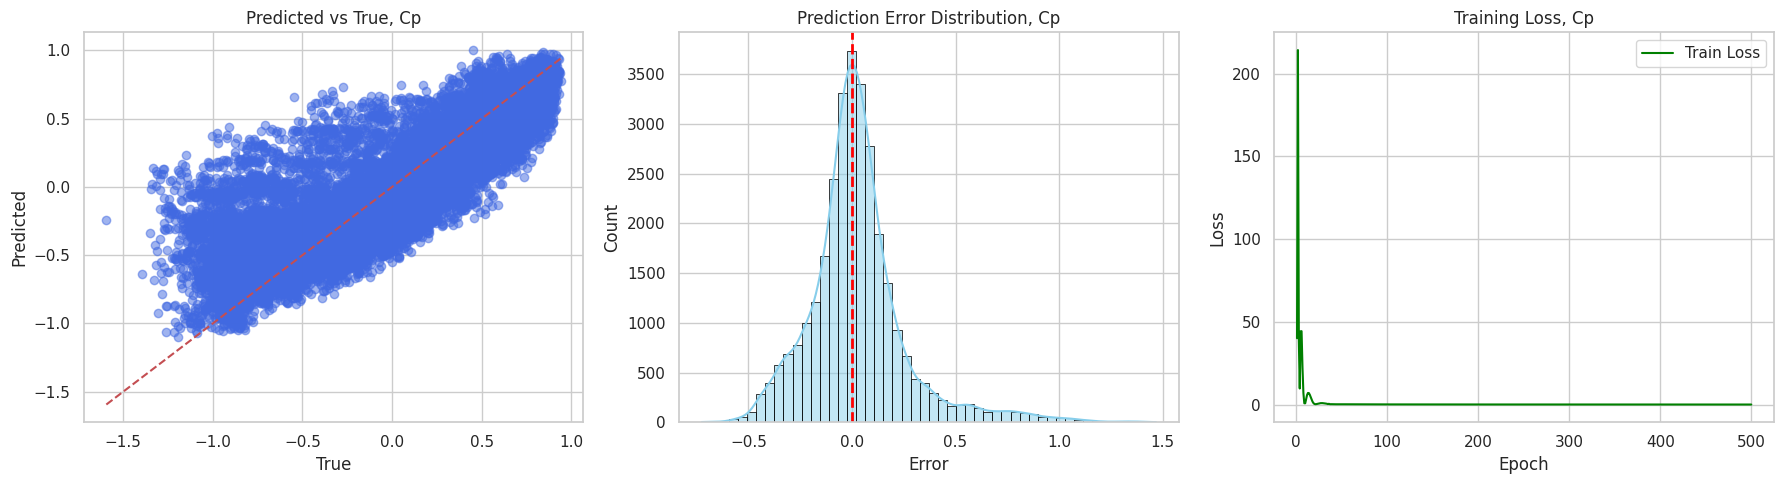

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 6/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 46/500 [00:00<00:02, 223.03it/s]

Epoch [10/500], Loss: 1.6309
Epoch [20/500], Loss: 0.2785
Epoch [30/500], Loss: 1.1519
Epoch [40/500], Loss: 0.3564
Epoch [50/500], Loss: 0.2357


Epochs:  18%|█▊        | 92/500 [00:00<00:01, 222.23it/s]

Epoch [60/500], Loss: 0.2220
Epoch [70/500], Loss: 0.2098
Epoch [80/500], Loss: 0.2027
Epoch [90/500], Loss: 0.1977
Epoch [100/500], Loss: 0.1926


Epochs:  28%|██▊       | 138/500 [00:00<00:01, 222.38it/s]

Epoch [110/500], Loss: 0.1857
Epoch [120/500], Loss: 0.1700
Epoch [130/500], Loss: 0.1491
Epoch [140/500], Loss: 0.1334
Epoch [150/500], Loss: 0.1231


Epochs:  37%|███▋      | 184/500 [00:00<00:01, 222.27it/s]

Epoch [160/500], Loss: 0.1160
Epoch [170/500], Loss: 0.1104
Epoch [180/500], Loss: 0.1069
Epoch [190/500], Loss: 0.1044
Epoch [200/500], Loss: 0.1022


Epochs:  51%|█████     | 253/500 [00:01<00:01, 222.22it/s]

Epoch [210/500], Loss: 0.0999
Epoch [220/500], Loss: 0.1004
Epoch [230/500], Loss: 0.0975
Epoch [240/500], Loss: 0.0939
Epoch [250/500], Loss: 0.0918


Epochs:  60%|█████▉    | 299/500 [00:01<00:00, 222.28it/s]

Epoch [260/500], Loss: 0.0896
Epoch [270/500], Loss: 0.0885
Epoch [280/500], Loss: 0.0856
Epoch [290/500], Loss: 0.0856
Epoch [300/500], Loss: 0.0825


Epochs:  69%|██████▉   | 345/500 [00:01<00:00, 222.40it/s]

Epoch [310/500], Loss: 0.0808
Epoch [320/500], Loss: 0.0794
Epoch [330/500], Loss: 0.0781
Epoch [340/500], Loss: 0.0769
Epoch [350/500], Loss: 0.0759


Epochs:  78%|███████▊  | 391/500 [00:01<00:00, 222.31it/s]

Epoch [360/500], Loss: 0.0747
Epoch [370/500], Loss: 0.0736
Epoch [380/500], Loss: 0.0724
Epoch [390/500], Loss: 0.0722
Epoch [400/500], Loss: 0.0705


Epochs:  87%|████████▋ | 437/500 [00:01<00:00, 222.10it/s]

Epoch [410/500], Loss: 0.0696
Epoch [420/500], Loss: 0.0686
Epoch [430/500], Loss: 0.0710
Epoch [440/500], Loss: 0.0683
Epoch [450/500], Loss: 0.0665


Epochs: 100%|██████████| 500/500 [00:02<00:00, 222.24it/s]

Epoch [460/500], Loss: 0.0653
Epoch [470/500], Loss: 0.0661
Epoch [480/500], Loss: 0.0654
Epoch [490/500], Loss: 0.0638
Epoch [500/500], Loss: 0.0632
📈 Evaluation metrics on test set:
MSE: 0.0646
MAE: 0.1776
R2: 0.7371



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


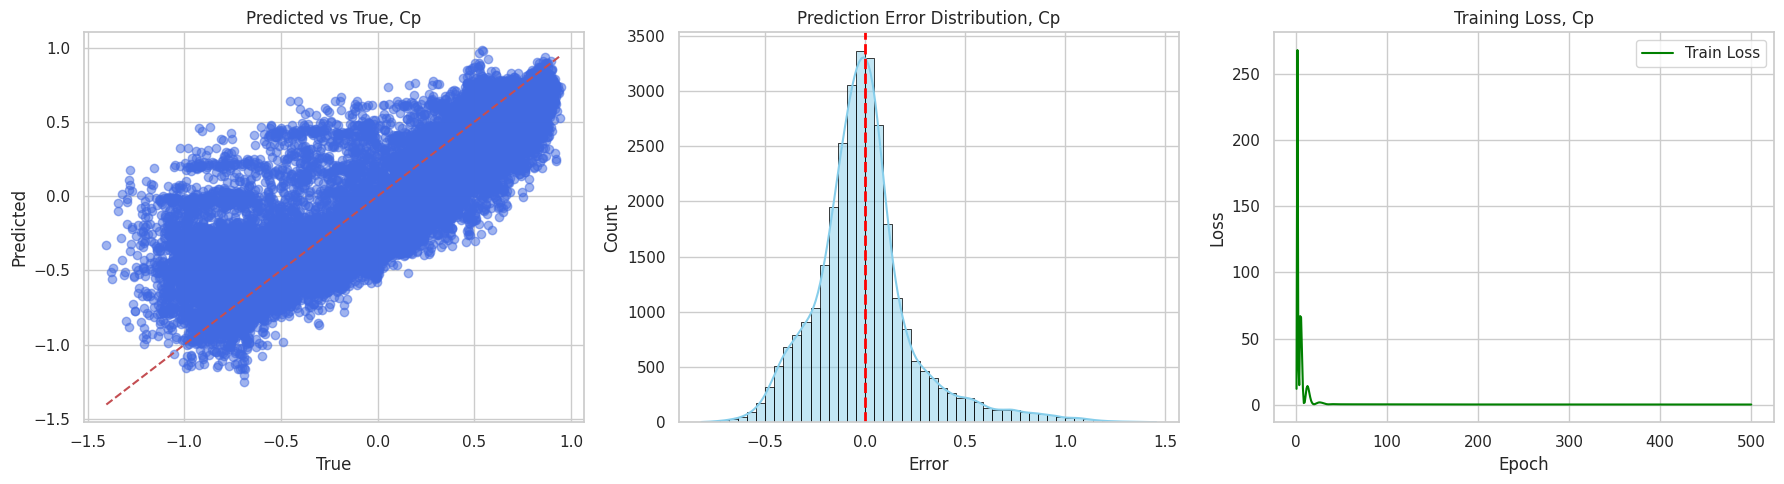

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 7/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   5%|▍         | 23/500 [00:00<00:02, 224.87it/s]

Epoch [10/500], Loss: 1.5130
Epoch [20/500], Loss: 0.2573
Epoch [30/500], Loss: 0.2924
Epoch [40/500], Loss: 0.2232


Epochs:   9%|▉         | 46/500 [00:00<00:02, 223.07it/s]

Epoch [50/500], Loss: 0.2204


Epochs:  18%|█▊        | 92/500 [00:00<00:01, 222.34it/s]

Epoch [60/500], Loss: 0.2045
Epoch [70/500], Loss: 0.1964
Epoch [80/500], Loss: 0.1927
Epoch [90/500], Loss: 0.1887
Epoch [100/500], Loss: 0.1877


Epochs:  28%|██▊       | 138/500 [00:00<00:01, 222.42it/s]

Epoch [110/500], Loss: 0.1829
Epoch [120/500], Loss: 0.1793
Epoch [130/500], Loss: 0.1760
Epoch [140/500], Loss: 0.1721
Epoch [150/500], Loss: 0.1436


Epochs:  37%|███▋      | 184/500 [00:00<00:01, 221.82it/s]

Epoch [160/500], Loss: 0.1218
Epoch [170/500], Loss: 0.1115
Epoch [180/500], Loss: 0.1041
Epoch [190/500], Loss: 0.1001
Epoch [200/500], Loss: 0.0975


Epochs:  46%|████▌     | 230/500 [00:01<00:01, 221.80it/s]

Epoch [210/500], Loss: 0.0960
Epoch [220/500], Loss: 0.0948
Epoch [230/500], Loss: 0.0921
Epoch [240/500], Loss: 0.0898


Epochs:  51%|█████     | 253/500 [00:01<00:01, 221.65it/s]

Epoch [250/500], Loss: 0.0877


Epochs:  55%|█████▌    | 276/500 [00:01<00:01, 221.20it/s]

Epoch [260/500], Loss: 0.0867
Epoch [270/500], Loss: 0.0856
Epoch [280/500], Loss: 0.0845
Epoch [290/500], Loss: 0.0832


Epochs:  60%|█████▉    | 299/500 [00:01<00:00, 220.90it/s]

Epoch [300/500], Loss: 0.0823


Epochs:  64%|██████▍   | 322/500 [00:01<00:00, 221.07it/s]

Epoch [310/500], Loss: 0.0814
Epoch [320/500], Loss: 0.0807
Epoch [330/500], Loss: 0.0799
Epoch [340/500], Loss: 0.0790


Epochs:  69%|██████▉   | 345/500 [00:01<00:00, 221.30it/s]

Epoch [350/500], Loss: 0.0793


Epochs:  78%|███████▊  | 391/500 [00:01<00:00, 221.34it/s]

Epoch [360/500], Loss: 0.0778
Epoch [370/500], Loss: 0.0777
Epoch [380/500], Loss: 0.0788
Epoch [390/500], Loss: 0.0772
Epoch [400/500], Loss: 0.0764


Epochs:  87%|████████▋ | 437/500 [00:01<00:00, 221.07it/s]

Epoch [410/500], Loss: 0.0757
Epoch [420/500], Loss: 0.0753
Epoch [430/500], Loss: 0.0755
Epoch [440/500], Loss: 0.0756
Epoch [450/500], Loss: 0.0745


Epochs:  97%|█████████▋| 483/500 [00:02<00:00, 220.42it/s]

Epoch [460/500], Loss: 0.0745
Epoch [470/500], Loss: 0.0747
Epoch [480/500], Loss: 0.0740
Epoch [490/500], Loss: 0.0741


Epochs: 100%|██████████| 500/500 [00:02<00:00, 221.35it/s]

Epoch [500/500], Loss: 0.0741
📈 Evaluation metrics on test set:
MSE: 0.0746
MAE: 0.1950
R2: 0.6981



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


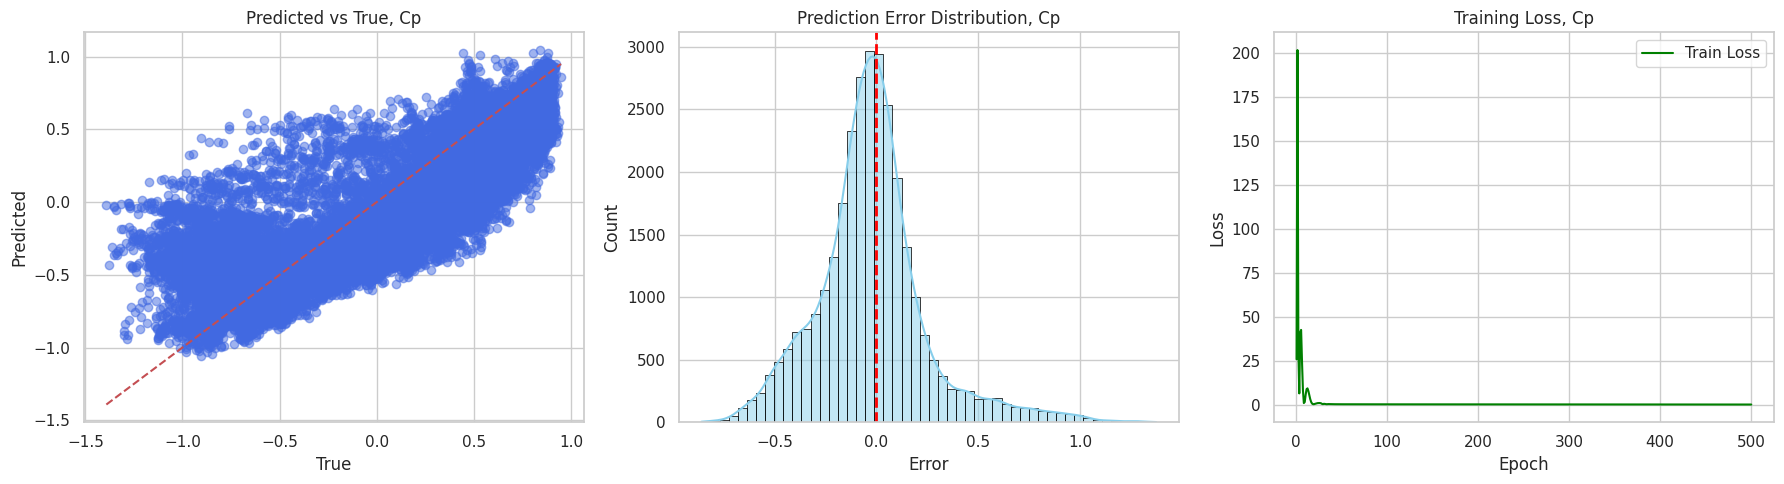

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 8/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   7%|▋         | 34/500 [00:00<00:02, 162.35it/s]

Epoch [10/500], Loss: 0.8989
Epoch [20/500], Loss: 0.3919
Epoch [30/500], Loss: 0.2798
Epoch [40/500], Loss: 0.2425


Epochs:  15%|█▍        | 74/500 [00:00<00:02, 187.43it/s]

Epoch [50/500], Loss: 0.3686
Epoch [60/500], Loss: 0.2110
Epoch [70/500], Loss: 0.2023
Epoch [80/500], Loss: 0.1927
Epoch [90/500], Loss: 0.1831


Epochs:  28%|██▊       | 142/500 [00:00<00:01, 211.27it/s]

Epoch [100/500], Loss: 0.1692
Epoch [110/500], Loss: 0.1518
Epoch [120/500], Loss: 0.1346
Epoch [130/500], Loss: 0.1200
Epoch [140/500], Loss: 0.1106


Epochs:  38%|███▊      | 188/500 [00:00<00:01, 216.92it/s]

Epoch [150/500], Loss: 0.1037
Epoch [160/500], Loss: 0.0981
Epoch [170/500], Loss: 0.0943
Epoch [180/500], Loss: 0.0919
Epoch [190/500], Loss: 0.0898


Epochs:  47%|████▋     | 234/500 [00:01<00:01, 219.60it/s]

Epoch [200/500], Loss: 0.0883
Epoch [210/500], Loss: 0.0874
Epoch [220/500], Loss: 0.0856
Epoch [230/500], Loss: 0.0839
Epoch [240/500], Loss: 0.0832


Epochs:  56%|█████▌    | 280/500 [00:01<00:00, 220.64it/s]

Epoch [250/500], Loss: 0.0818
Epoch [260/500], Loss: 0.0807
Epoch [270/500], Loss: 0.0794
Epoch [280/500], Loss: 0.0789
Epoch [290/500], Loss: 0.0783


Epochs:  65%|██████▌   | 326/500 [00:01<00:00, 221.18it/s]

Epoch [300/500], Loss: 0.0770
Epoch [310/500], Loss: 0.0764
Epoch [320/500], Loss: 0.0756
Epoch [330/500], Loss: 0.0783
Epoch [340/500], Loss: 0.0764


Epochs:  74%|███████▍  | 372/500 [00:01<00:00, 221.64it/s]

Epoch [350/500], Loss: 0.0744
Epoch [360/500], Loss: 0.0737
Epoch [370/500], Loss: 0.0733
Epoch [380/500], Loss: 0.0728
Epoch [390/500], Loss: 0.0724


Epochs:  88%|████████▊ | 441/500 [00:02<00:00, 221.78it/s]

Epoch [400/500], Loss: 0.0720
Epoch [410/500], Loss: 0.0717
Epoch [420/500], Loss: 0.0714
Epoch [430/500], Loss: 0.0710
Epoch [440/500], Loss: 0.0707


Epochs:  97%|█████████▋| 487/500 [00:02<00:00, 221.78it/s]

Epoch [450/500], Loss: 0.0729
Epoch [460/500], Loss: 0.0703
Epoch [470/500], Loss: 0.0700
Epoch [480/500], Loss: 0.0692
Epoch [490/500], Loss: 0.0685


Epochs: 100%|██████████| 500/500 [00:02<00:00, 214.02it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0681
📈 Evaluation metrics on test set:
MSE: 0.0687
MAE: 0.1815
R2: 0.7219


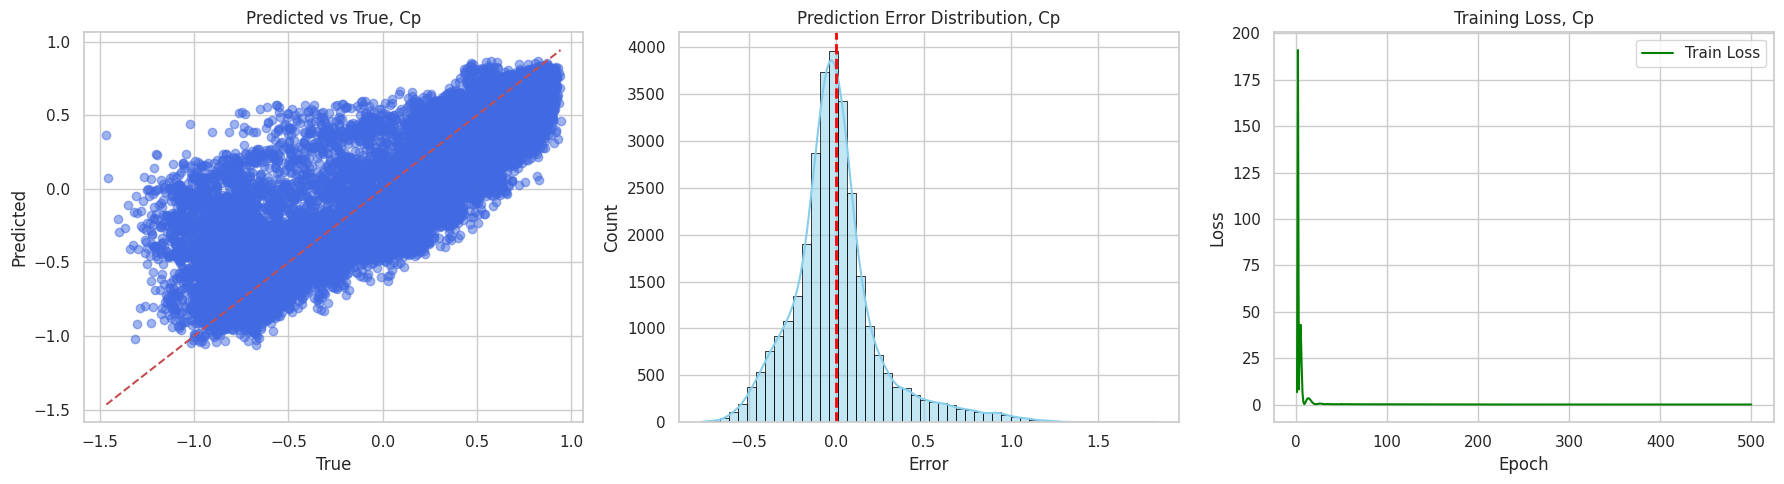

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 9/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   7%|▋         | 34/500 [00:00<00:02, 164.84it/s]

Epoch [10/500], Loss: 1.9418
Epoch [20/500], Loss: 0.5275
Epoch [30/500], Loss: 2.0188
Epoch [40/500], Loss: 0.2982


Epochs:  15%|█▌        | 75/500 [00:00<00:02, 189.66it/s]

Epoch [50/500], Loss: 0.3811
Epoch [60/500], Loss: 0.2401
Epoch [70/500], Loss: 0.2309
Epoch [80/500], Loss: 0.2211
Epoch [90/500], Loss: 0.2151


Epochs:  29%|██▉       | 144/500 [00:00<00:01, 212.60it/s]

Epoch [100/500], Loss: 0.2143
Epoch [110/500], Loss: 0.2122
Epoch [120/500], Loss: 0.2112
Epoch [130/500], Loss: 0.2101
Epoch [140/500], Loss: 0.2089


Epochs:  38%|███▊      | 190/500 [00:00<00:01, 217.29it/s]

Epoch [150/500], Loss: 0.2078
Epoch [160/500], Loss: 0.2066
Epoch [170/500], Loss: 0.1998
Epoch [180/500], Loss: 0.1818
Epoch [190/500], Loss: 0.1713


Epochs:  47%|████▋     | 236/500 [00:01<00:01, 219.78it/s]

Epoch [200/500], Loss: 0.1566
Epoch [210/500], Loss: 0.1353
Epoch [220/500], Loss: 0.1199
Epoch [230/500], Loss: 0.1131
Epoch [240/500], Loss: 0.1089


Epochs:  56%|█████▋    | 282/500 [00:01<00:00, 221.03it/s]

Epoch [250/500], Loss: 0.1059
Epoch [260/500], Loss: 0.1040
Epoch [270/500], Loss: 0.1028
Epoch [280/500], Loss: 0.1014
Epoch [290/500], Loss: 0.1006


Epochs:  66%|██████▌   | 328/500 [00:01<00:00, 221.33it/s]

Epoch [300/500], Loss: 0.0997
Epoch [310/500], Loss: 0.0990
Epoch [320/500], Loss: 0.1001
Epoch [330/500], Loss: 0.0983
Epoch [340/500], Loss: 0.0962


Epochs:  75%|███████▍  | 374/500 [00:01<00:00, 221.60it/s]

Epoch [350/500], Loss: 0.0942
Epoch [360/500], Loss: 0.0932
Epoch [370/500], Loss: 0.0900
Epoch [380/500], Loss: 0.0888
Epoch [390/500], Loss: 0.0875


Epochs:  89%|████████▊ | 443/500 [00:02<00:00, 221.70it/s]

Epoch [400/500], Loss: 0.0861
Epoch [410/500], Loss: 0.0852
Epoch [420/500], Loss: 0.0842
Epoch [430/500], Loss: 0.0834
Epoch [440/500], Loss: 0.0834


Epochs:  98%|█████████▊| 489/500 [00:02<00:00, 221.86it/s]

Epoch [450/500], Loss: 0.0820
Epoch [460/500], Loss: 0.0818
Epoch [470/500], Loss: 0.0816
Epoch [480/500], Loss: 0.0800
Epoch [490/500], Loss: 0.0801


Epochs: 100%|██████████| 500/500 [00:02<00:00, 214.47it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0800
📈 Evaluation metrics on test set:
MSE: 0.0794
MAE: 0.2055
R2: 0.6822


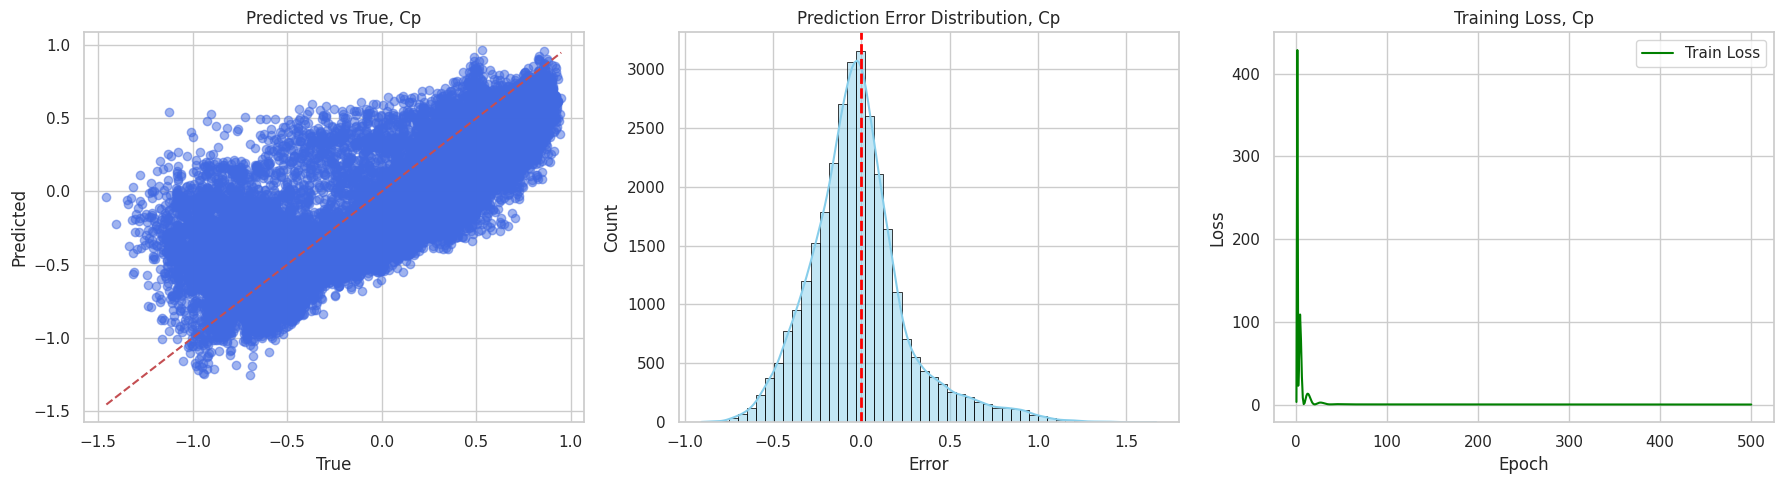

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 10/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   3%|▎         | 17/500 [00:00<00:02, 162.85it/s]

Epoch [10/500], Loss: 0.4177
Epoch [20/500], Loss: 2.3479
Epoch [30/500], Loss: 0.4075


Epochs:   7%|▋         | 35/500 [00:00<00:02, 171.53it/s]

Epoch [40/500], Loss: 0.3257


Epochs:  16%|█▌        | 78/500 [00:00<00:02, 196.48it/s]

Epoch [50/500], Loss: 0.2411
Epoch [60/500], Loss: 0.2370
Epoch [70/500], Loss: 0.2233
Epoch [80/500], Loss: 0.2170
Epoch [90/500], Loss: 0.2116


Epochs:  25%|██▍       | 124/500 [00:00<00:01, 211.16it/s]

Epoch [100/500], Loss: 0.1646
Epoch [110/500], Loss: 0.1497
Epoch [120/500], Loss: 0.1440
Epoch [130/500], Loss: 0.1392
Epoch [140/500], Loss: 0.1370


Epochs:  34%|███▍      | 170/500 [00:00<00:01, 217.06it/s]

Epoch [150/500], Loss: 0.1357
Epoch [160/500], Loss: 0.1345
Epoch [170/500], Loss: 0.1333
Epoch [180/500], Loss: 0.1323


Epochs:  39%|███▊      | 193/500 [00:00<00:01, 218.44it/s]

Epoch [190/500], Loss: 0.1313


Epochs:  43%|████▎     | 216/500 [00:01<00:01, 219.03it/s]

Epoch [200/500], Loss: 0.1302
Epoch [210/500], Loss: 0.1292
Epoch [220/500], Loss: 0.1282
Epoch [230/500], Loss: 0.1271


Epochs:  48%|████▊     | 239/500 [00:01<00:01, 219.80it/s]

Epoch [240/500], Loss: 0.1261


Epochs:  52%|█████▏    | 262/500 [00:01<00:01, 220.21it/s]

Epoch [250/500], Loss: 0.1250
Epoch [260/500], Loss: 0.1240
Epoch [270/500], Loss: 0.1230
Epoch [280/500], Loss: 0.1220


Epochs:  57%|█████▋    | 285/500 [00:01<00:00, 220.82it/s]

Epoch [290/500], Loss: 0.1208


Epochs:  66%|██████▌   | 331/500 [00:01<00:00, 220.66it/s]

Epoch [300/500], Loss: 0.1197
Epoch [310/500], Loss: 0.1186
Epoch [320/500], Loss: 0.1175
Epoch [330/500], Loss: 0.1166
Epoch [340/500], Loss: 0.1156


Epochs:  75%|███████▌  | 377/500 [00:01<00:00, 221.51it/s]

Epoch [350/500], Loss: 0.1146
Epoch [360/500], Loss: 0.1136
Epoch [370/500], Loss: 0.1137
Epoch [380/500], Loss: 0.1119
Epoch [390/500], Loss: 0.1107


Epochs:  85%|████████▍ | 423/500 [00:01<00:00, 221.58it/s]

Epoch [400/500], Loss: 0.1097
Epoch [410/500], Loss: 0.1090
Epoch [420/500], Loss: 0.1084
Epoch [430/500], Loss: 0.1074
Epoch [440/500], Loss: 0.1060


Epochs:  94%|█████████▍| 469/500 [00:02<00:00, 221.77it/s]

Epoch [450/500], Loss: 0.1060
Epoch [460/500], Loss: 0.1061
Epoch [470/500], Loss: 0.1033
Epoch [480/500], Loss: 0.1029


Epochs:  98%|█████████▊| 492/500 [00:02<00:00, 221.41it/s]

Epoch [490/500], Loss: 0.1017


Epochs: 100%|██████████| 500/500 [00:02<00:00, 215.70it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.1067
📈 Evaluation metrics on test set:
MSE: 0.1035
MAE: 0.2328
R2: 0.5837


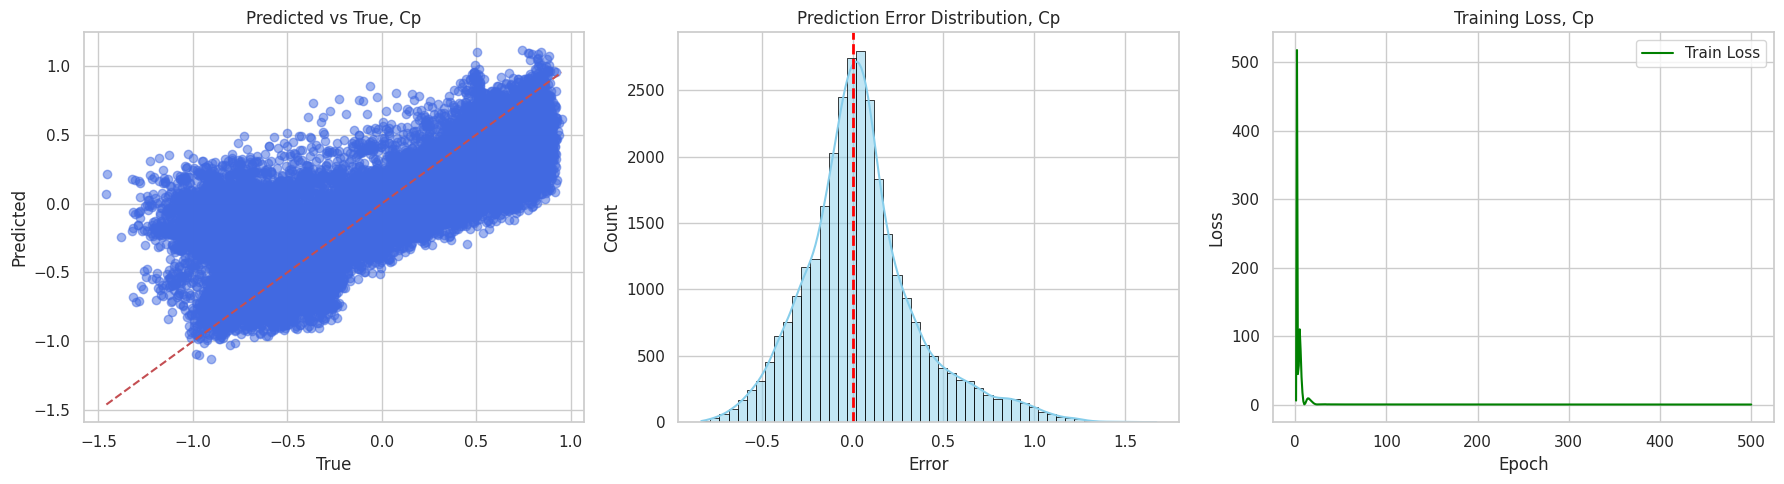

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 11/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 46/500 [00:00<00:02, 222.53it/s]

Epoch [10/500], Loss: 2.2088
Epoch [20/500], Loss: 0.2588
Epoch [30/500], Loss: 0.7856
Epoch [40/500], Loss: 0.3374
Epoch [50/500], Loss: 0.2430


Epochs:  18%|█▊        | 92/500 [00:00<00:01, 221.15it/s]

Epoch [60/500], Loss: 0.2185
Epoch [70/500], Loss: 0.2155
Epoch [80/500], Loss: 0.1845
Epoch [90/500], Loss: 0.1723
Epoch [100/500], Loss: 0.1571


Epochs:  28%|██▊       | 138/500 [00:00<00:01, 221.76it/s]

Epoch [110/500], Loss: 0.1461
Epoch [120/500], Loss: 0.1357
Epoch [130/500], Loss: 0.1256
Epoch [140/500], Loss: 0.1167
Epoch [150/500], Loss: 0.1093


Epochs:  37%|███▋      | 184/500 [00:00<00:01, 221.85it/s]

Epoch [160/500], Loss: 0.1035
Epoch [170/500], Loss: 0.1002
Epoch [180/500], Loss: 0.0965
Epoch [190/500], Loss: 0.0941
Epoch [200/500], Loss: 0.0927


Epochs:  51%|█████     | 253/500 [00:01<00:01, 221.52it/s]

Epoch [210/500], Loss: 0.0906
Epoch [220/500], Loss: 0.0953
Epoch [230/500], Loss: 0.0887
Epoch [240/500], Loss: 0.0881
Epoch [250/500], Loss: 0.0872


Epochs:  60%|█████▉    | 299/500 [00:01<00:00, 221.57it/s]

Epoch [260/500], Loss: 0.0863
Epoch [270/500], Loss: 0.0863
Epoch [280/500], Loss: 0.0856
Epoch [290/500], Loss: 0.0860
Epoch [300/500], Loss: 0.0838


Epochs:  69%|██████▉   | 345/500 [00:01<00:00, 221.80it/s]

Epoch [310/500], Loss: 0.0832
Epoch [320/500], Loss: 0.0833
Epoch [330/500], Loss: 0.0835
Epoch [340/500], Loss: 0.0814
Epoch [350/500], Loss: 0.0812


Epochs:  78%|███████▊  | 391/500 [00:01<00:00, 221.31it/s]

Epoch [360/500], Loss: 0.0794
Epoch [370/500], Loss: 0.0786
Epoch [380/500], Loss: 0.0821
Epoch [390/500], Loss: 0.0787
Epoch [400/500], Loss: 0.0789


Epochs:  87%|████████▋ | 437/500 [00:01<00:00, 221.44it/s]

Epoch [410/500], Loss: 0.0782
Epoch [420/500], Loss: 0.0802
Epoch [430/500], Loss: 0.0768
Epoch [440/500], Loss: 0.0768
Epoch [450/500], Loss: 0.0792


Epochs: 100%|██████████| 500/500 [00:02<00:00, 221.55it/s]

Epoch [460/500], Loss: 0.0761
Epoch [470/500], Loss: 0.0835
Epoch [480/500], Loss: 0.0758
Epoch [490/500], Loss: 0.0773
Epoch [500/500], Loss: 0.0768
📈 Evaluation metrics on test set:
MSE: 0.0769
MAE: 0.1969
R2: 0.6891



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


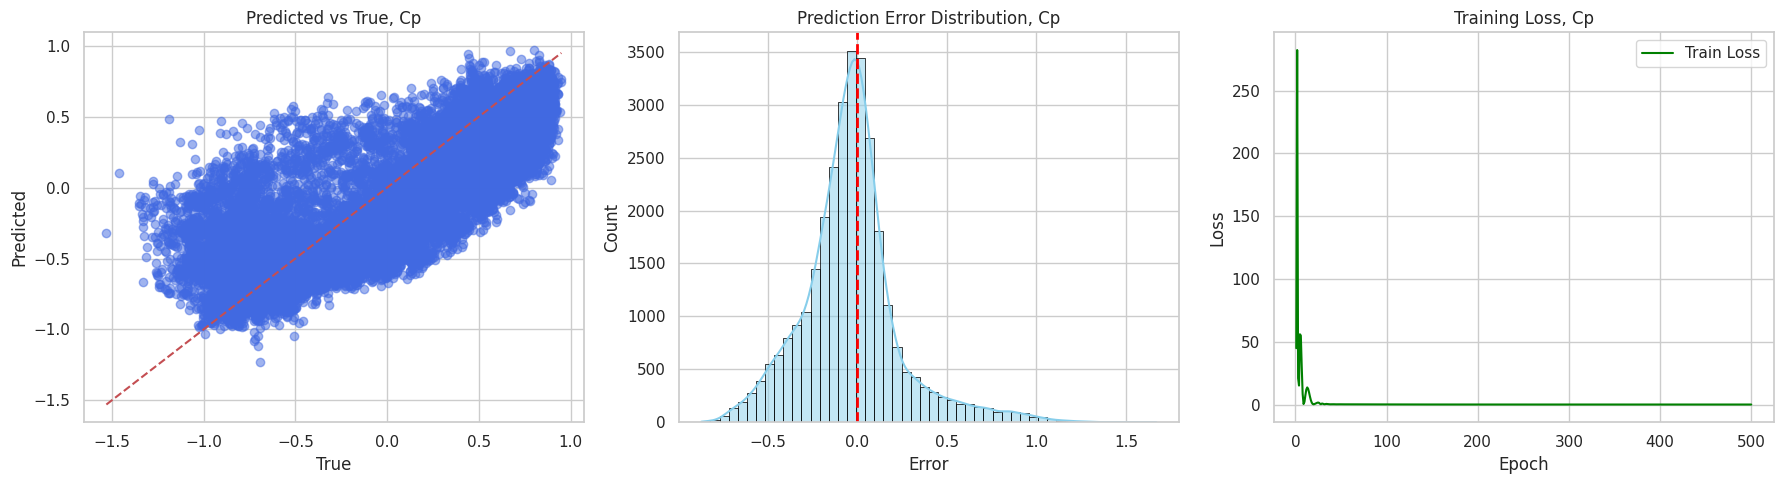

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 12/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 46/500 [00:00<00:02, 222.67it/s]

Epoch [10/500], Loss: 4.1344
Epoch [20/500], Loss: 0.2286
Epoch [30/500], Loss: 0.5356
Epoch [40/500], Loss: 0.2214
Epoch [50/500], Loss: 0.2522


Epochs:  18%|█▊        | 92/500 [00:00<00:01, 221.46it/s]

Epoch [60/500], Loss: 0.2143
Epoch [70/500], Loss: 0.2112
Epoch [80/500], Loss: 0.2057
Epoch [90/500], Loss: 0.2023
Epoch [100/500], Loss: 0.1993


Epochs:  28%|██▊       | 138/500 [00:00<00:01, 221.68it/s]

Epoch [110/500], Loss: 0.1957
Epoch [120/500], Loss: 0.1923
Epoch [130/500], Loss: 0.1891
Epoch [140/500], Loss: 0.1864
Epoch [150/500], Loss: 0.1838


Epochs:  37%|███▋      | 184/500 [00:00<00:01, 221.35it/s]

Epoch [160/500], Loss: 0.1807
Epoch [170/500], Loss: 0.1737
Epoch [180/500], Loss: 0.1598
Epoch [190/500], Loss: 0.1397
Epoch [200/500], Loss: 0.1276


Epochs:  51%|█████     | 253/500 [00:01<00:01, 220.99it/s]

Epoch [210/500], Loss: 0.1213
Epoch [220/500], Loss: 0.1161
Epoch [230/500], Loss: 0.1114
Epoch [240/500], Loss: 0.1060
Epoch [250/500], Loss: 0.1020


Epochs:  60%|█████▉    | 299/500 [00:01<00:00, 220.48it/s]

Epoch [260/500], Loss: 0.0964
Epoch [270/500], Loss: 0.0928
Epoch [280/500], Loss: 0.0900
Epoch [290/500], Loss: 0.0879
Epoch [300/500], Loss: 0.0861


Epochs:  69%|██████▉   | 345/500 [00:01<00:00, 219.74it/s]

Epoch [310/500], Loss: 0.0845
Epoch [320/500], Loss: 0.0831
Epoch [330/500], Loss: 0.0819
Epoch [340/500], Loss: 0.0810
Epoch [350/500], Loss: 0.0801


Epochs:  78%|███████▊  | 391/500 [00:01<00:00, 220.79it/s]

Epoch [360/500], Loss: 0.0792
Epoch [370/500], Loss: 0.0785
Epoch [380/500], Loss: 0.0783
Epoch [390/500], Loss: 0.0775
Epoch [400/500], Loss: 0.0767


Epochs:  87%|████████▋ | 437/500 [00:01<00:00, 220.96it/s]

Epoch [410/500], Loss: 0.0761
Epoch [420/500], Loss: 0.0756
Epoch [430/500], Loss: 0.0753
Epoch [440/500], Loss: 0.0750
Epoch [450/500], Loss: 0.0745


Epochs: 100%|██████████| 500/500 [00:02<00:00, 220.89it/s]

Epoch [460/500], Loss: 0.0740
Epoch [470/500], Loss: 0.0738
Epoch [480/500], Loss: 0.0755
Epoch [490/500], Loss: 0.0747
Epoch [500/500], Loss: 0.0733
📈 Evaluation metrics on test set:
MSE: 0.0728
MAE: 0.1894
R2: 0.7081



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


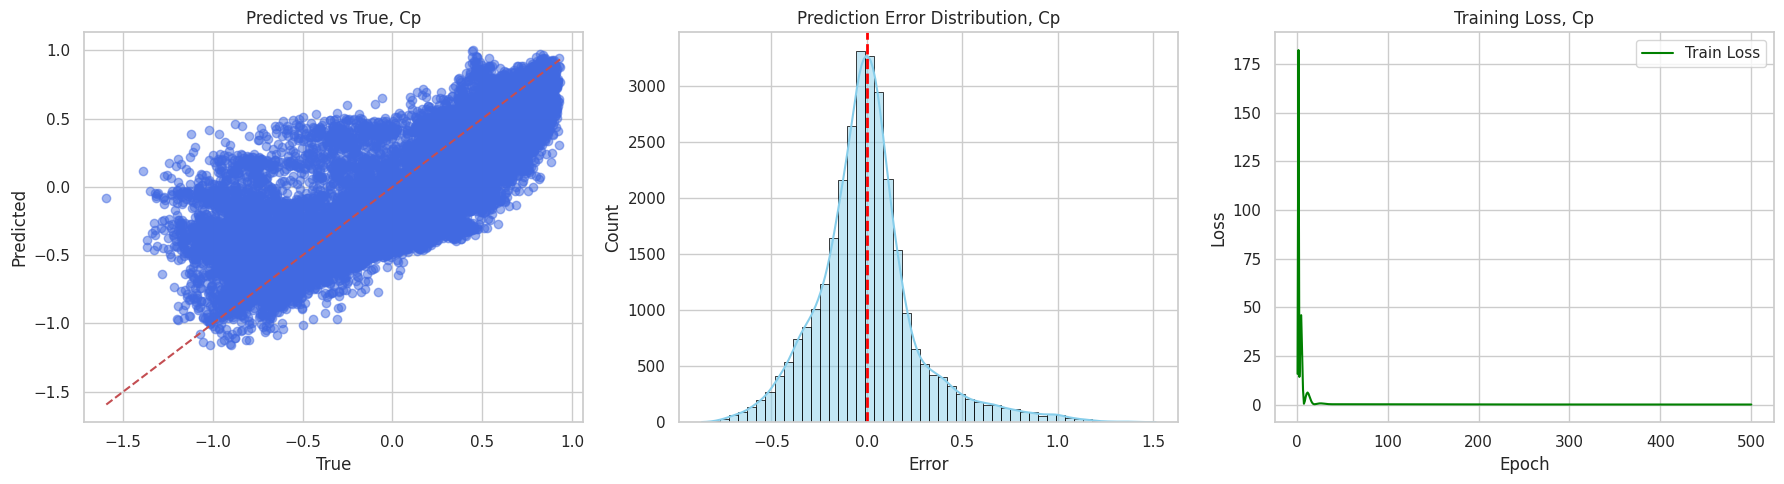

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 13/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 46/500 [00:00<00:02, 221.87it/s]

Epoch [10/500], Loss: 0.3406
Epoch [20/500], Loss: 0.6601
Epoch [30/500], Loss: 0.2424
Epoch [40/500], Loss: 0.2354
Epoch [50/500], Loss: 0.2305


Epochs:  18%|█▊        | 92/500 [00:00<00:01, 221.77it/s]

Epoch [60/500], Loss: 0.2077
Epoch [70/500], Loss: 0.1834
Epoch [80/500], Loss: 0.1635
Epoch [90/500], Loss: 0.1502
Epoch [100/500], Loss: 0.1413


Epochs:  28%|██▊       | 138/500 [00:00<00:01, 221.75it/s]

Epoch [110/500], Loss: 0.1341
Epoch [120/500], Loss: 0.1253
Epoch [130/500], Loss: 0.1194
Epoch [140/500], Loss: 0.1147
Epoch [150/500], Loss: 0.1096


Epochs:  37%|███▋      | 184/500 [00:00<00:01, 221.52it/s]

Epoch [160/500], Loss: 0.1050
Epoch [170/500], Loss: 0.1014
Epoch [180/500], Loss: 0.0988
Epoch [190/500], Loss: 0.0966
Epoch [200/500], Loss: 0.0946


Epochs:  51%|█████     | 253/500 [00:01<00:01, 221.78it/s]

Epoch [210/500], Loss: 0.0929
Epoch [220/500], Loss: 0.0906
Epoch [230/500], Loss: 0.0873
Epoch [240/500], Loss: 0.0857
Epoch [250/500], Loss: 0.0848


Epochs:  60%|█████▉    | 299/500 [00:01<00:00, 221.56it/s]

Epoch [260/500], Loss: 0.0833
Epoch [270/500], Loss: 0.0826
Epoch [280/500], Loss: 0.0817
Epoch [290/500], Loss: 0.0808
Epoch [300/500], Loss: 0.0801


Epochs:  69%|██████▉   | 345/500 [00:01<00:00, 221.61it/s]

Epoch [310/500], Loss: 0.0793
Epoch [320/500], Loss: 0.0785
Epoch [330/500], Loss: 0.0776
Epoch [340/500], Loss: 0.0817
Epoch [350/500], Loss: 0.0777


Epochs:  78%|███████▊  | 391/500 [00:01<00:00, 221.65it/s]

Epoch [360/500], Loss: 0.0760
Epoch [370/500], Loss: 0.0755
Epoch [380/500], Loss: 0.0749
Epoch [390/500], Loss: 0.0743
Epoch [400/500], Loss: 0.0742


Epochs:  87%|████████▋ | 437/500 [00:01<00:00, 221.43it/s]

Epoch [410/500], Loss: 0.0738
Epoch [420/500], Loss: 0.0737
Epoch [430/500], Loss: 0.0721
Epoch [440/500], Loss: 0.0715
Epoch [450/500], Loss: 0.0737


Epochs: 100%|██████████| 500/500 [00:02<00:00, 221.49it/s]

Epoch [460/500], Loss: 0.0712
Epoch [470/500], Loss: 0.0715
Epoch [480/500], Loss: 0.0697
Epoch [490/500], Loss: 0.0705
Epoch [500/500], Loss: 0.0698
📈 Evaluation metrics on test set:
MSE: 0.0701
MAE: 0.1898
R2: 0.7175



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


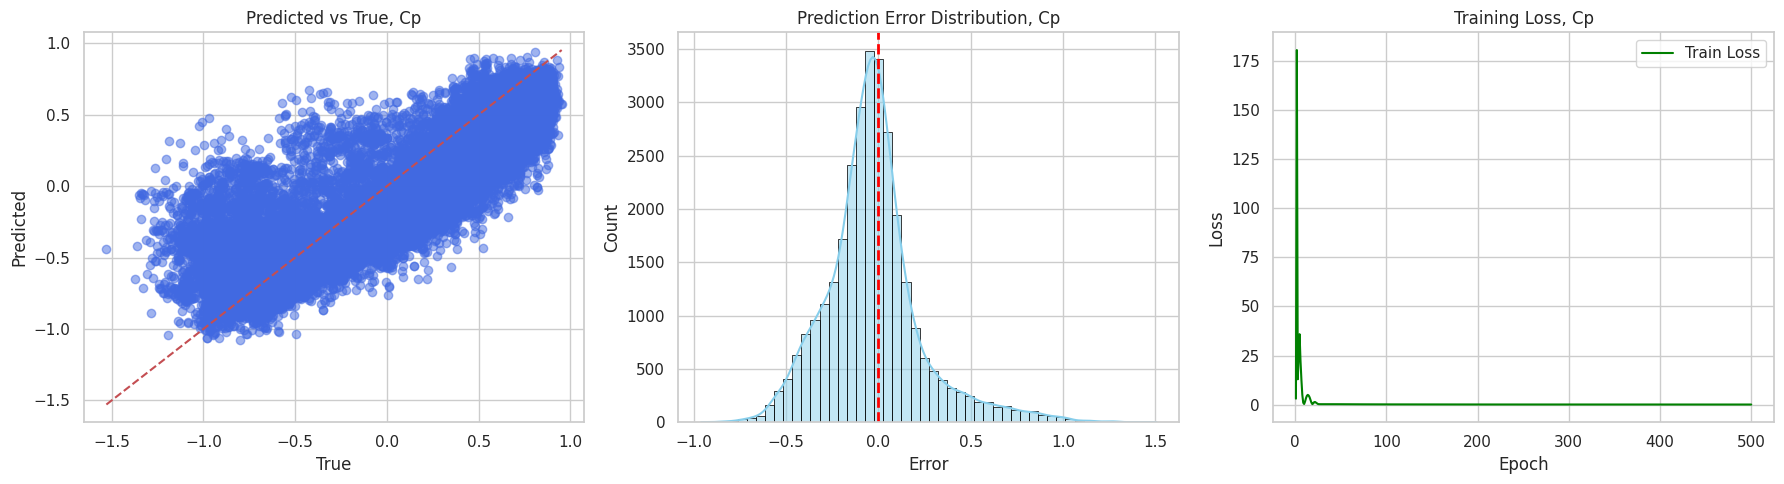

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 14/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   7%|▋         | 35/500 [00:00<00:02, 172.39it/s]

Epoch [10/500], Loss: 0.9357
Epoch [20/500], Loss: 4.7894
Epoch [30/500], Loss: 0.4594
Epoch [40/500], Loss: 0.2256


Epochs:  15%|█▌        | 76/500 [00:00<00:02, 192.58it/s]

Epoch [50/500], Loss: 0.2096
Epoch [60/500], Loss: 0.2004
Epoch [70/500], Loss: 0.1963
Epoch [80/500], Loss: 0.1934
Epoch [90/500], Loss: 0.1909


Epochs:  24%|██▍       | 122/500 [00:00<00:01, 209.56it/s]

Epoch [100/500], Loss: 0.1886
Epoch [110/500], Loss: 0.1860
Epoch [120/500], Loss: 0.1827
Epoch [130/500], Loss: 0.1610
Epoch [140/500], Loss: 0.1394


Epochs:  38%|███▊      | 191/500 [00:00<00:01, 217.97it/s]

Epoch [150/500], Loss: 0.1235
Epoch [160/500], Loss: 0.1143
Epoch [170/500], Loss: 0.1074
Epoch [180/500], Loss: 0.1015
Epoch [190/500], Loss: 0.0959


Epochs:  47%|████▋     | 237/500 [00:01<00:01, 219.64it/s]

Epoch [200/500], Loss: 0.0932
Epoch [210/500], Loss: 0.0908
Epoch [220/500], Loss: 0.0890
Epoch [230/500], Loss: 0.0876
Epoch [240/500], Loss: 0.0863


Epochs:  57%|█████▋    | 283/500 [00:01<00:00, 220.50it/s]

Epoch [250/500], Loss: 0.0851
Epoch [260/500], Loss: 0.0841
Epoch [270/500], Loss: 0.0832
Epoch [280/500], Loss: 0.0823
Epoch [290/500], Loss: 0.0822


Epochs:  66%|██████▌   | 329/500 [00:01<00:00, 221.20it/s]

Epoch [300/500], Loss: 0.0812
Epoch [310/500], Loss: 0.0802
Epoch [320/500], Loss: 0.0797
Epoch [330/500], Loss: 0.0791
Epoch [340/500], Loss: 0.0787


Epochs:  75%|███████▌  | 375/500 [00:01<00:00, 221.15it/s]

Epoch [350/500], Loss: 0.0781
Epoch [360/500], Loss: 0.0777
Epoch [370/500], Loss: 0.0772
Epoch [380/500], Loss: 0.0771
Epoch [390/500], Loss: 0.0767


Epochs:  89%|████████▉ | 444/500 [00:02<00:00, 221.62it/s]

Epoch [400/500], Loss: 0.0759
Epoch [410/500], Loss: 0.0770
Epoch [420/500], Loss: 0.0752
Epoch [430/500], Loss: 0.0749
Epoch [440/500], Loss: 0.0744


Epochs:  98%|█████████▊| 490/500 [00:02<00:00, 221.67it/s]

Epoch [450/500], Loss: 0.0738
Epoch [460/500], Loss: 0.0754
Epoch [470/500], Loss: 0.0735
Epoch [480/500], Loss: 0.0728
Epoch [490/500], Loss: 0.0720


Epochs: 100%|██████████| 500/500 [00:02<00:00, 215.25it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0716
📈 Evaluation metrics on test set:
MSE: 0.0728
MAE: 0.1871
R2: 0.7091


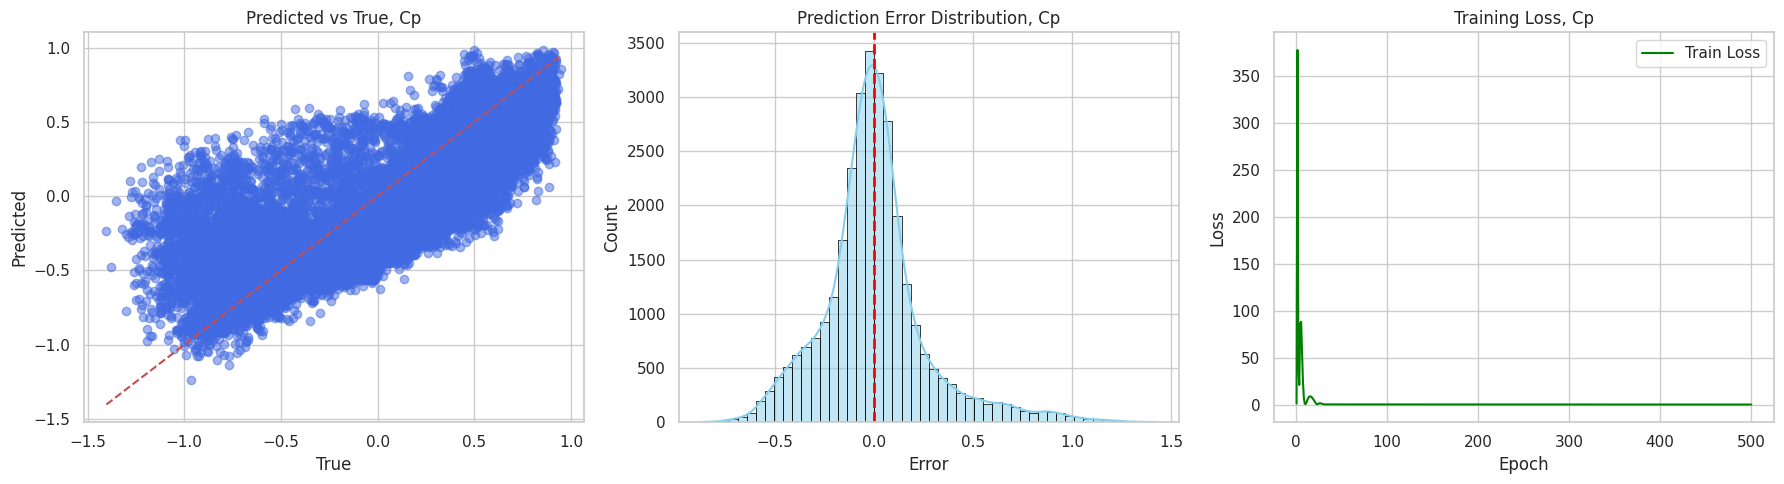

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 15/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 44/500 [00:00<00:02, 205.02it/s]

Epoch [10/500], Loss: 1.2698
Epoch [20/500], Loss: 2.4128
Epoch [30/500], Loss: 1.6923
Epoch [40/500], Loss: 0.3412
Epoch [50/500], Loss: 0.3239


Epochs:  18%|█▊        | 89/500 [00:00<00:01, 214.04it/s]

Epoch [60/500], Loss: 0.2434
Epoch [70/500], Loss: 0.2172
Epoch [80/500], Loss: 0.2079
Epoch [90/500], Loss: 0.2010
Epoch [100/500], Loss: 0.1955


Epochs:  27%|██▋       | 135/500 [00:00<00:01, 218.49it/s]

Epoch [110/500], Loss: 0.1877
Epoch [120/500], Loss: 0.1778
Epoch [130/500], Loss: 0.1648
Epoch [140/500], Loss: 0.1408
Epoch [150/500], Loss: 0.1409


Epochs:  41%|████      | 204/500 [00:00<00:01, 220.00it/s]

Epoch [160/500], Loss: 0.1294
Epoch [170/500], Loss: 0.1211
Epoch [180/500], Loss: 0.1147
Epoch [190/500], Loss: 0.1099
Epoch [200/500], Loss: 0.1059


Epochs:  50%|█████     | 250/500 [00:01<00:01, 220.68it/s]

Epoch [210/500], Loss: 0.1022
Epoch [220/500], Loss: 0.0993
Epoch [230/500], Loss: 0.0963
Epoch [240/500], Loss: 0.0936
Epoch [250/500], Loss: 0.0909


Epochs:  59%|█████▉    | 296/500 [00:01<00:00, 220.69it/s]

Epoch [260/500], Loss: 0.0928
Epoch [270/500], Loss: 0.0870
Epoch [280/500], Loss: 0.0849
Epoch [290/500], Loss: 0.0834
Epoch [300/500], Loss: 0.0816


Epochs:  68%|██████▊   | 342/500 [00:01<00:00, 220.40it/s]

Epoch [310/500], Loss: 0.0805
Epoch [320/500], Loss: 0.0789
Epoch [330/500], Loss: 0.0785
Epoch [340/500], Loss: 0.0765
Epoch [350/500], Loss: 0.0754


Epochs:  78%|███████▊  | 388/500 [00:01<00:00, 220.41it/s]

Epoch [360/500], Loss: 0.0741
Epoch [370/500], Loss: 0.0724
Epoch [380/500], Loss: 0.0718
Epoch [390/500], Loss: 0.0728
Epoch [400/500], Loss: 0.0703


Epochs:  87%|████████▋ | 434/500 [00:01<00:00, 220.44it/s]

Epoch [410/500], Loss: 0.0690
Epoch [420/500], Loss: 0.0677
Epoch [430/500], Loss: 0.0671
Epoch [440/500], Loss: 0.0665
Epoch [450/500], Loss: 0.0675


Epochs: 100%|██████████| 500/500 [00:02<00:00, 219.18it/s]


Epoch [460/500], Loss: 0.0667
Epoch [470/500], Loss: 0.0657
Epoch [480/500], Loss: 0.0656
Epoch [490/500], Loss: 0.0643
Epoch [500/500], Loss: 0.0623
📈 Evaluation metrics on test set:
MSE: 0.0616
MAE: 0.1721
R2: 0.7536


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


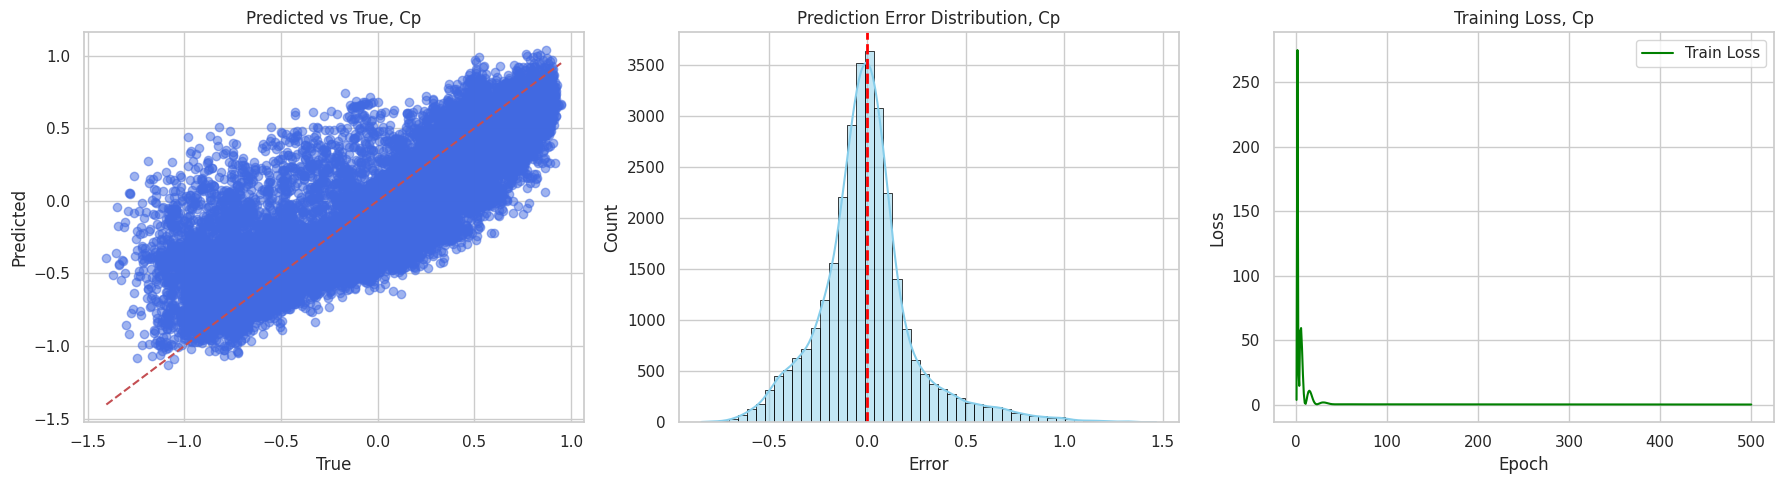

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 16/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   8%|▊         | 40/500 [00:00<00:02, 182.21it/s]

Epoch [10/500], Loss: 4.8202
Epoch [20/500], Loss: 0.9542
Epoch [30/500], Loss: 0.3036
Epoch [40/500], Loss: 0.3992


Epochs:  17%|█▋        | 85/500 [00:00<00:02, 205.38it/s]

Epoch [50/500], Loss: 0.2268
Epoch [60/500], Loss: 0.2374
Epoch [70/500], Loss: 0.2096
Epoch [80/500], Loss: 0.2133
Epoch [90/500], Loss: 0.2082


Epochs:  26%|██▌       | 131/500 [00:00<00:01, 214.15it/s]

Epoch [100/500], Loss: 0.2054
Epoch [110/500], Loss: 0.1852
Epoch [120/500], Loss: 0.1498
Epoch [130/500], Loss: 0.1308
Epoch [140/500], Loss: 0.1183


Epochs:  35%|███▌      | 176/500 [00:00<00:01, 217.87it/s]

Epoch [150/500], Loss: 0.1084
Epoch [160/500], Loss: 0.1033
Epoch [170/500], Loss: 0.1034
Epoch [180/500], Loss: 0.0939
Epoch [190/500], Loss: 0.0944


Epochs:  44%|████▍     | 222/500 [00:01<00:01, 219.65it/s]

Epoch [200/500], Loss: 0.0935
Epoch [210/500], Loss: 0.0900
Epoch [220/500], Loss: 0.0905
Epoch [230/500], Loss: 0.0885
Epoch [240/500], Loss: 0.0877


Epochs:  58%|█████▊    | 291/500 [00:01<00:00, 220.40it/s]

Epoch [250/500], Loss: 0.0869
Epoch [260/500], Loss: 0.0881
Epoch [270/500], Loss: 0.0899
Epoch [280/500], Loss: 0.0884
Epoch [290/500], Loss: 0.0858


Epochs:  67%|██████▋   | 337/500 [00:01<00:00, 220.03it/s]

Epoch [300/500], Loss: 0.0839
Epoch [310/500], Loss: 0.0857
Epoch [320/500], Loss: 0.0834
Epoch [330/500], Loss: 0.0850
Epoch [340/500], Loss: 0.0849


Epochs:  77%|███████▋  | 383/500 [00:01<00:00, 220.33it/s]

Epoch [350/500], Loss: 0.0816
Epoch [360/500], Loss: 0.0815
Epoch [370/500], Loss: 0.0872
Epoch [380/500], Loss: 0.0843
Epoch [390/500], Loss: 0.0802


Epochs:  86%|████████▌ | 429/500 [00:01<00:00, 220.70it/s]

Epoch [400/500], Loss: 0.0800
Epoch [410/500], Loss: 0.0833
Epoch [420/500], Loss: 0.0791
Epoch [430/500], Loss: 0.0818
Epoch [440/500], Loss: 0.0787


Epochs:  95%|█████████▌| 475/500 [00:02<00:00, 220.85it/s]

Epoch [450/500], Loss: 0.0791
Epoch [460/500], Loss: 0.0813
Epoch [470/500], Loss: 0.0789
Epoch [480/500], Loss: 0.0781
Epoch [490/500], Loss: 0.0826


Epochs: 100%|██████████| 500/500 [00:02<00:00, 216.81it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0781
📈 Evaluation metrics on test set:
MSE: 0.0801
MAE: 0.2044
R2: 0.6756


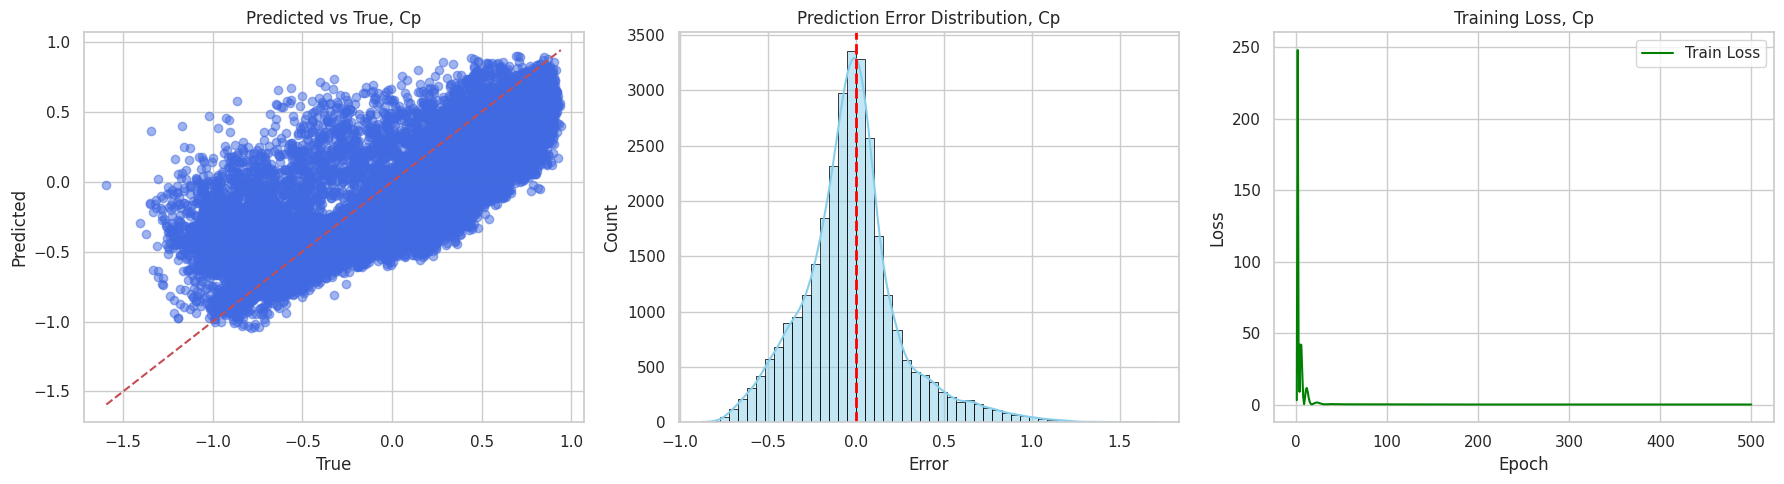

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 17/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   7%|▋         | 35/500 [00:00<00:02, 168.33it/s]

Epoch [10/500], Loss: 9.6509
Epoch [20/500], Loss: 3.0497
Epoch [30/500], Loss: 1.1225
Epoch [40/500], Loss: 0.5200


Epochs:  15%|█▌        | 75/500 [00:00<00:02, 189.56it/s]

Epoch [50/500], Loss: 0.2436
Epoch [60/500], Loss: 0.2203
Epoch [70/500], Loss: 0.2101
Epoch [80/500], Loss: 0.2050
Epoch [90/500], Loss: 0.1999


Epochs:  29%|██▉       | 144/500 [00:00<00:01, 212.51it/s]

Epoch [100/500], Loss: 0.1948
Epoch [110/500], Loss: 0.1894
Epoch [120/500], Loss: 0.1837
Epoch [130/500], Loss: 0.1781
Epoch [140/500], Loss: 0.1726


Epochs:  38%|███▊      | 190/500 [00:00<00:01, 216.95it/s]

Epoch [150/500], Loss: 0.1671
Epoch [160/500], Loss: 0.1615
Epoch [170/500], Loss: 0.1375
Epoch [180/500], Loss: 0.1276
Epoch [190/500], Loss: 0.1208


Epochs:  47%|████▋     | 235/500 [00:01<00:01, 217.77it/s]

Epoch [200/500], Loss: 0.1168
Epoch [210/500], Loss: 0.1100
Epoch [220/500], Loss: 0.1087
Epoch [230/500], Loss: 0.1070
Epoch [240/500], Loss: 0.1085


Epochs:  56%|█████▌    | 280/500 [00:01<00:01, 218.85it/s]

Epoch [250/500], Loss: 0.1038
Epoch [260/500], Loss: 0.1029
Epoch [270/500], Loss: 0.1023
Epoch [280/500], Loss: 0.1014
Epoch [290/500], Loss: 0.1012


Epochs:  65%|██████▌   | 326/500 [00:01<00:00, 219.89it/s]

Epoch [300/500], Loss: 0.1012
Epoch [310/500], Loss: 0.1003
Epoch [320/500], Loss: 0.0994
Epoch [330/500], Loss: 0.0988
Epoch [340/500], Loss: 0.0980


Epochs:  74%|███████▍  | 372/500 [00:01<00:00, 220.54it/s]

Epoch [350/500], Loss: 0.1087
Epoch [360/500], Loss: 0.1000
Epoch [370/500], Loss: 0.0977
Epoch [380/500], Loss: 0.0966
Epoch [390/500], Loss: 0.0957


Epochs:  88%|████████▊ | 441/500 [00:02<00:00, 220.85it/s]

Epoch [400/500], Loss: 0.0951
Epoch [410/500], Loss: 0.0946
Epoch [420/500], Loss: 0.0940
Epoch [430/500], Loss: 0.0934
Epoch [440/500], Loss: 0.1021


Epochs:  97%|█████████▋| 487/500 [00:02<00:00, 220.69it/s]

Epoch [450/500], Loss: 0.0951
Epoch [460/500], Loss: 0.0927
Epoch [470/500], Loss: 0.0921
Epoch [480/500], Loss: 0.0915
Epoch [490/500], Loss: 0.0912


Epochs: 100%|██████████| 500/500 [00:02<00:00, 213.62it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0954
📈 Evaluation metrics on test set:
MSE: 0.0975
MAE: 0.2303
R2: 0.6102


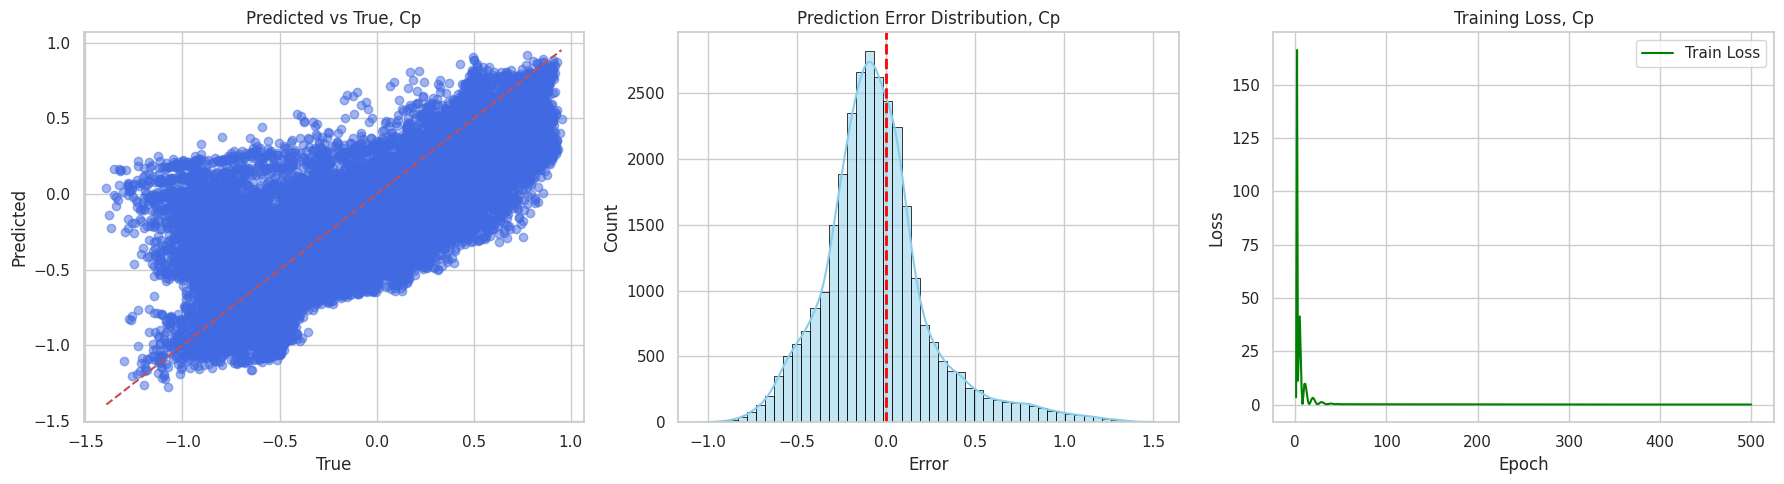

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 18/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   3%|▎         | 17/500 [00:00<00:02, 163.17it/s]

Epoch [10/500], Loss: 6.6126
Epoch [20/500], Loss: 1.0162
Epoch [30/500], Loss: 0.2278


Epochs:   7%|▋         | 35/500 [00:00<00:02, 171.58it/s]

Epoch [40/500], Loss: 0.2267


Epochs:  15%|█▌        | 75/500 [00:00<00:02, 190.30it/s]

Epoch [50/500], Loss: 0.2136
Epoch [60/500], Loss: 0.2113
Epoch [70/500], Loss: 0.2096
Epoch [80/500], Loss: 0.1853
Epoch [90/500], Loss: 0.1733


Epochs:  24%|██▍       | 120/500 [00:00<00:01, 206.82it/s]

Epoch [100/500], Loss: 0.1588
Epoch [110/500], Loss: 0.1485
Epoch [120/500], Loss: 0.1373
Epoch [130/500], Loss: 0.1284


Epochs:  28%|██▊       | 142/500 [00:00<00:01, 210.73it/s]

Epoch [140/500], Loss: 0.1241


Epochs:  33%|███▎      | 165/500 [00:00<00:01, 213.76it/s]

Epoch [150/500], Loss: 0.1257
Epoch [160/500], Loss: 0.1146
Epoch [170/500], Loss: 0.1123
Epoch [180/500], Loss: 0.1091


Epochs:  38%|███▊      | 188/500 [00:00<00:01, 215.89it/s]

Epoch [190/500], Loss: 0.1068


Epochs:  46%|████▋     | 232/500 [00:01<00:01, 217.63it/s]

Epoch [200/500], Loss: 0.1052
Epoch [210/500], Loss: 0.1038
Epoch [220/500], Loss: 0.1026
Epoch [230/500], Loss: 0.1023
Epoch [240/500], Loss: 0.1084


Epochs:  55%|█████▌    | 277/500 [00:01<00:01, 218.70it/s]

Epoch [250/500], Loss: 0.1006
Epoch [260/500], Loss: 0.1021
Epoch [270/500], Loss: 0.0995
Epoch [280/500], Loss: 0.0986
Epoch [290/500], Loss: 0.0980


Epochs:  64%|██████▍   | 322/500 [00:01<00:00, 219.37it/s]

Epoch [300/500], Loss: 0.0972
Epoch [310/500], Loss: 0.0964
Epoch [320/500], Loss: 0.0953
Epoch [330/500], Loss: 0.1049


Epochs:  69%|██████▉   | 344/500 [00:01<00:00, 219.19it/s]

Epoch [340/500], Loss: 0.0939


Epochs:  73%|███████▎  | 366/500 [00:01<00:00, 219.28it/s]

Epoch [350/500], Loss: 0.0943
Epoch [360/500], Loss: 0.0916
Epoch [370/500], Loss: 0.0907
Epoch [380/500], Loss: 0.0937


Epochs:  78%|███████▊  | 389/500 [00:01<00:00, 219.51it/s]

Epoch [390/500], Loss: 0.0929


Epochs:  87%|████████▋ | 433/500 [00:02<00:00, 219.54it/s]

Epoch [400/500], Loss: 0.0893
Epoch [410/500], Loss: 0.0878
Epoch [420/500], Loss: 0.0869
Epoch [430/500], Loss: 0.0908
Epoch [440/500], Loss: 0.0892


Epochs:  95%|█████████▌| 477/500 [00:02<00:00, 219.55it/s]

Epoch [450/500], Loss: 0.0859
Epoch [460/500], Loss: 0.0842
Epoch [470/500], Loss: 0.0833
Epoch [480/500], Loss: 0.0875
Epoch [490/500], Loss: 0.0858


Epochs: 100%|██████████| 500/500 [00:02<00:00, 213.22it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0830
📈 Evaluation metrics on test set:
MSE: 0.0797
MAE: 0.2031
R2: 0.6737


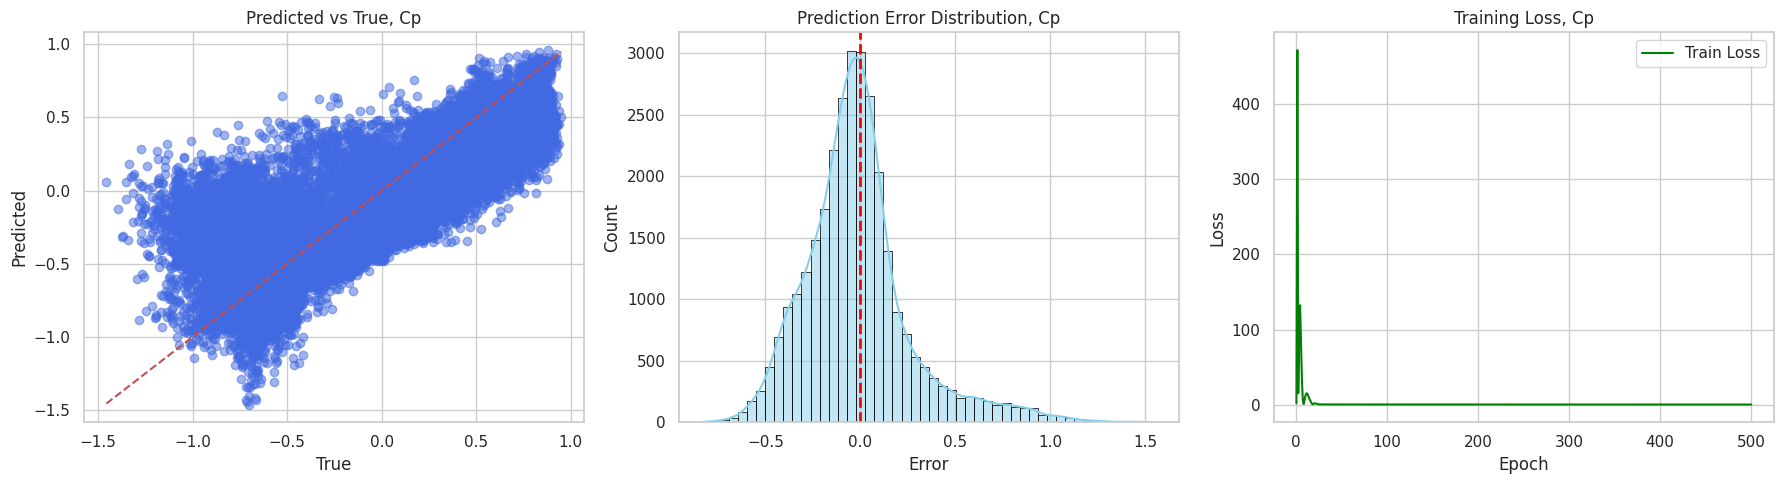

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 19/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   4%|▍         | 22/500 [00:00<00:02, 212.41it/s]

Epoch [10/500], Loss: 0.5417
Epoch [20/500], Loss: 0.3481
Epoch [30/500], Loss: 0.3936
Epoch [40/500], Loss: 0.2251


Epochs:  17%|█▋        | 87/500 [00:00<00:01, 210.80it/s]

Epoch [50/500], Loss: 0.1894
Epoch [60/500], Loss: 0.1948
Epoch [70/500], Loss: 0.1670
Epoch [80/500], Loss: 0.1455
Epoch [90/500], Loss: 0.1288


Epochs:  26%|██▌       | 131/500 [00:00<00:01, 215.65it/s]

Epoch [100/500], Loss: 0.1202
Epoch [110/500], Loss: 0.1156
Epoch [120/500], Loss: 0.1118
Epoch [130/500], Loss: 0.1088
Epoch [140/500], Loss: 0.1064


Epochs:  35%|███▌      | 176/500 [00:00<00:01, 218.21it/s]

Epoch [150/500], Loss: 0.1064
Epoch [160/500], Loss: 0.1058
Epoch [170/500], Loss: 0.1024
Epoch [180/500], Loss: 0.1000
Epoch [190/500], Loss: 0.1191


Epochs:  48%|████▊     | 242/500 [00:01<00:01, 218.98it/s]

Epoch [200/500], Loss: 0.1001
Epoch [210/500], Loss: 0.0958
Epoch [220/500], Loss: 0.0940
Epoch [230/500], Loss: 0.0911
Epoch [240/500], Loss: 0.0890


Epochs:  57%|█████▋    | 287/500 [00:01<00:00, 219.49it/s]

Epoch [250/500], Loss: 0.0867
Epoch [260/500], Loss: 0.0877
Epoch [270/500], Loss: 0.0839
Epoch [280/500], Loss: 0.0815
Epoch [290/500], Loss: 0.0831


Epochs:  66%|██████▋   | 332/500 [00:01<00:00, 219.72it/s]

Epoch [300/500], Loss: 0.0797
Epoch [310/500], Loss: 0.0789
Epoch [320/500], Loss: 0.0775
Epoch [330/500], Loss: 0.0762
Epoch [340/500], Loss: 0.1171


Epochs:  75%|███████▌  | 377/500 [00:01<00:00, 219.73it/s]

Epoch [350/500], Loss: 0.0805
Epoch [360/500], Loss: 0.0786
Epoch [370/500], Loss: 0.0751
Epoch [380/500], Loss: 0.0739
Epoch [390/500], Loss: 0.0726


Epochs:  85%|████████▍ | 423/500 [00:01<00:00, 220.14it/s]

Epoch [400/500], Loss: 0.0718
Epoch [410/500], Loss: 0.0711
Epoch [420/500], Loss: 0.0720
Epoch [430/500], Loss: 0.0969
Epoch [440/500], Loss: 0.0713


Epochs:  98%|█████████▊| 492/500 [00:02<00:00, 220.45it/s]

Epoch [450/500], Loss: 0.0698
Epoch [460/500], Loss: 0.0700
Epoch [470/500], Loss: 0.0686
Epoch [480/500], Loss: 0.0681
Epoch [490/500], Loss: 0.0675


Epochs: 100%|██████████| 500/500 [00:02<00:00, 217.92it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0695
📈 Evaluation metrics on test set:
MSE: 0.0728
MAE: 0.1962
R2: 0.7079


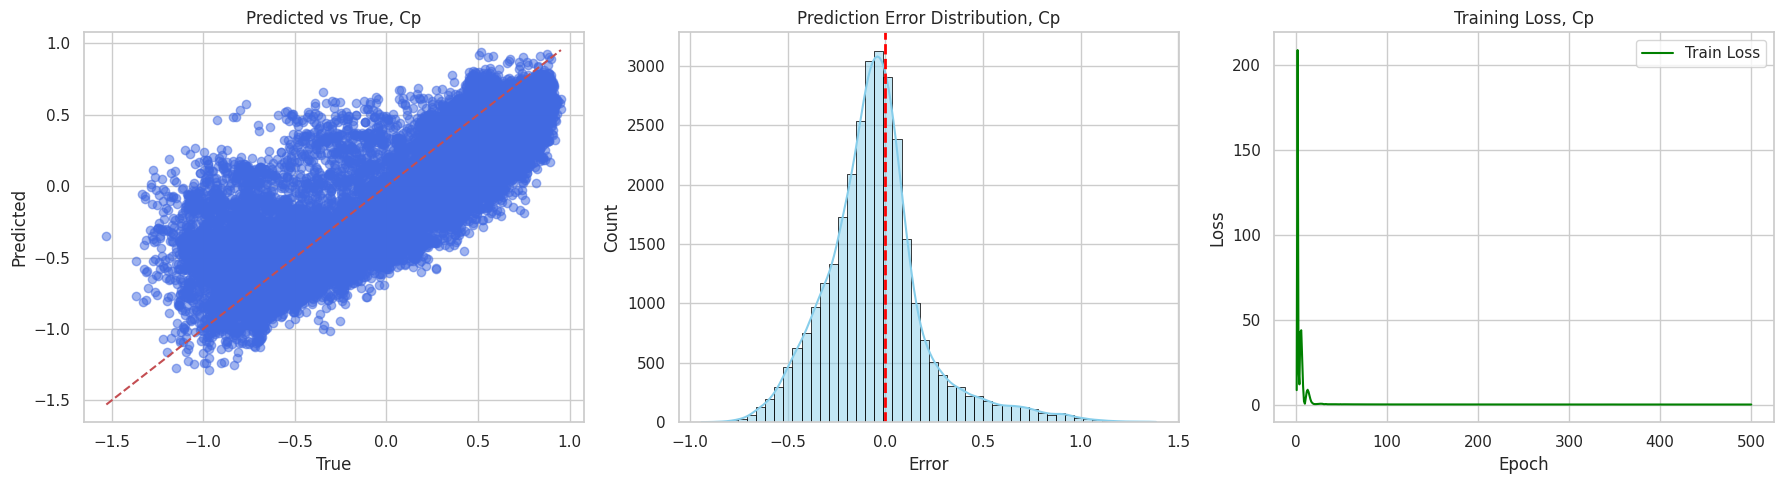

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 20/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   7%|▋         | 35/500 [00:00<00:02, 171.95it/s]

Epoch [10/500], Loss: 5.6035
Epoch [20/500], Loss: 4.7354
Epoch [30/500], Loss: 0.3414
Epoch [40/500], Loss: 0.4124


Epochs:  15%|█▌        | 76/500 [00:00<00:02, 193.28it/s]

Epoch [50/500], Loss: 0.2324
Epoch [60/500], Loss: 0.2172
Epoch [70/500], Loss: 0.2170
Epoch [80/500], Loss: 0.2084
Epoch [90/500], Loss: 0.2017


Epochs:  29%|██▊       | 143/500 [00:00<00:01, 212.17it/s]

Epoch [100/500], Loss: 0.1856
Epoch [110/500], Loss: 0.1653
Epoch [120/500], Loss: 0.1530
Epoch [130/500], Loss: 0.1444
Epoch [140/500], Loss: 0.1342


Epochs:  38%|███▊      | 189/500 [00:00<00:01, 216.58it/s]

Epoch [150/500], Loss: 0.1269
Epoch [160/500], Loss: 0.1213
Epoch [170/500], Loss: 0.1175
Epoch [180/500], Loss: 0.1142
Epoch [190/500], Loss: 0.1111


Epochs:  47%|████▋     | 234/500 [00:01<00:01, 218.51it/s]

Epoch [200/500], Loss: 0.1085
Epoch [210/500], Loss: 0.1060
Epoch [220/500], Loss: 0.1038
Epoch [230/500], Loss: 0.1016
Epoch [240/500], Loss: 0.0995


Epochs:  56%|█████▌    | 280/500 [00:01<00:01, 219.69it/s]

Epoch [250/500], Loss: 0.0976
Epoch [260/500], Loss: 0.0958
Epoch [270/500], Loss: 0.0943
Epoch [280/500], Loss: 0.0927
Epoch [290/500], Loss: 0.0916


Epochs:  65%|██████▌   | 326/500 [00:01<00:00, 220.27it/s]

Epoch [300/500], Loss: 0.0895
Epoch [310/500], Loss: 0.0883
Epoch [320/500], Loss: 0.0869
Epoch [330/500], Loss: 0.0878
Epoch [340/500], Loss: 0.0851


Epochs:  74%|███████▍  | 372/500 [00:01<00:00, 220.11it/s]

Epoch [350/500], Loss: 0.0838
Epoch [360/500], Loss: 0.0830
Epoch [370/500], Loss: 0.0813
Epoch [380/500], Loss: 0.0800
Epoch [390/500], Loss: 0.0809


Epochs:  88%|████████▊ | 441/500 [00:02<00:00, 220.19it/s]

Epoch [400/500], Loss: 0.0781
Epoch [410/500], Loss: 0.0774
Epoch [420/500], Loss: 0.0764
Epoch [430/500], Loss: 0.0757
Epoch [440/500], Loss: 0.0753


Epochs:  97%|█████████▋| 486/500 [00:02<00:00, 219.75it/s]

Epoch [450/500], Loss: 0.0745
Epoch [460/500], Loss: 0.0735
Epoch [470/500], Loss: 0.0720
Epoch [480/500], Loss: 0.0747
Epoch [490/500], Loss: 0.0750


Epochs: 100%|██████████| 500/500 [00:02<00:00, 214.32it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0703
📈 Evaluation metrics on test set:
MSE: 0.0717
MAE: 0.1831
R2: 0.7095


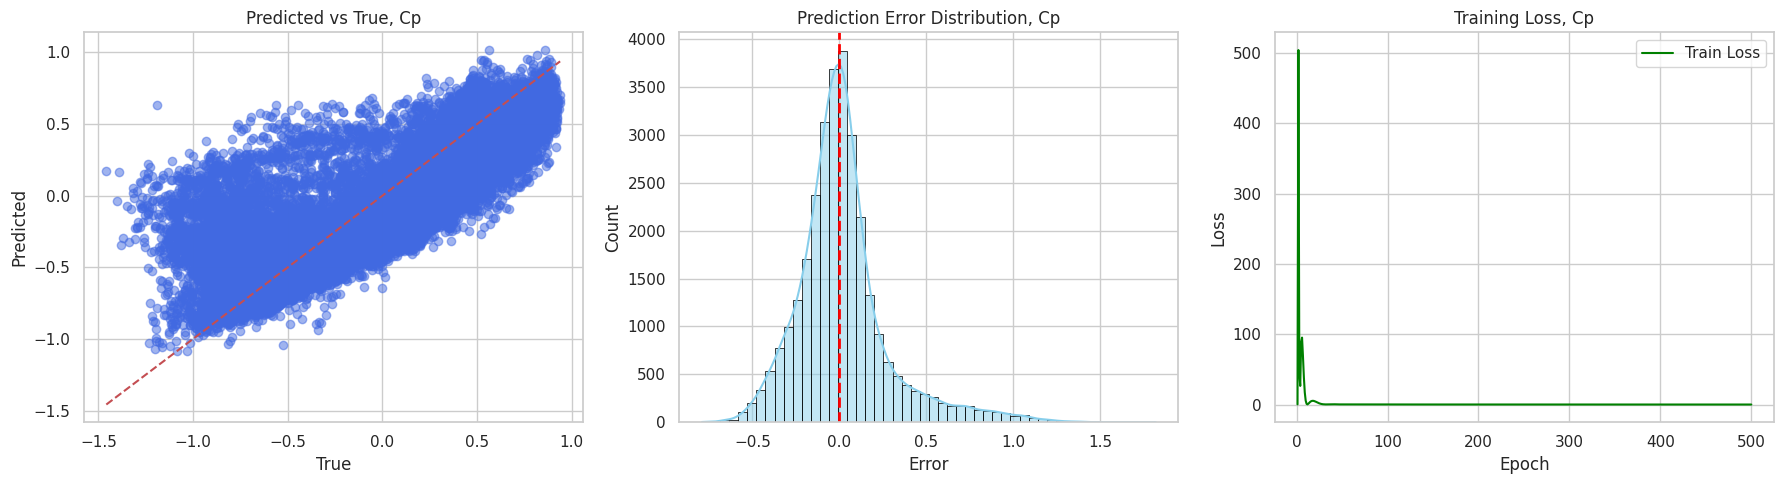

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 21/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 44/500 [00:00<00:02, 205.85it/s]

Epoch [10/500], Loss: 0.3230
Epoch [20/500], Loss: 0.4467
Epoch [30/500], Loss: 0.3765
Epoch [40/500], Loss: 0.3165
Epoch [50/500], Loss: 0.2607


Epochs:  18%|█▊        | 88/500 [00:00<00:01, 212.83it/s]

Epoch [60/500], Loss: 0.2075
Epoch [70/500], Loss: 0.1987
Epoch [80/500], Loss: 0.1615
Epoch [90/500], Loss: 0.1401
Epoch [100/500], Loss: 0.1318


Epochs:  27%|██▋       | 133/500 [00:00<00:01, 216.63it/s]

Epoch [110/500], Loss: 0.1273
Epoch [120/500], Loss: 0.1234
Epoch [130/500], Loss: 0.1207
Epoch [140/500], Loss: 0.1186
Epoch [150/500], Loss: 0.1165


Epochs:  40%|████      | 200/500 [00:00<00:01, 218.78it/s]

Epoch [160/500], Loss: 0.1142
Epoch [170/500], Loss: 0.1121
Epoch [180/500], Loss: 0.1089
Epoch [190/500], Loss: 0.1060
Epoch [200/500], Loss: 0.1427


Epochs:  49%|████▉     | 245/500 [00:01<00:01, 219.39it/s]

Epoch [210/500], Loss: 0.0993
Epoch [220/500], Loss: 0.1054
Epoch [230/500], Loss: 0.0932
Epoch [240/500], Loss: 0.0892
Epoch [250/500], Loss: 0.0865


Epochs:  58%|█████▊    | 289/500 [00:01<00:00, 219.20it/s]

Epoch [260/500], Loss: 0.0840
Epoch [270/500], Loss: 0.0821
Epoch [280/500], Loss: 0.0806
Epoch [290/500], Loss: 0.0799
Epoch [300/500], Loss: 0.0865


Epochs:  67%|██████▋   | 333/500 [00:01<00:00, 219.18it/s]

Epoch [310/500], Loss: 0.0810
Epoch [320/500], Loss: 0.0784
Epoch [330/500], Loss: 0.0774
Epoch [340/500], Loss: 0.0758
Epoch [350/500], Loss: 0.0782


Epochs:  80%|███████▉  | 399/500 [00:01<00:00, 219.45it/s]

Epoch [360/500], Loss: 0.0750
Epoch [370/500], Loss: 0.0742
Epoch [380/500], Loss: 0.0753
Epoch [390/500], Loss: 0.0728
Epoch [400/500], Loss: 0.0718


Epochs:  89%|████████▉ | 444/500 [00:02<00:00, 219.81it/s]

Epoch [410/500], Loss: 0.0716
Epoch [420/500], Loss: 0.0718
Epoch [430/500], Loss: 0.0700
Epoch [440/500], Loss: 0.0705
Epoch [450/500], Loss: 0.0695


Epochs: 100%|██████████| 500/500 [00:02<00:00, 217.96it/s]

Epoch [460/500], Loss: 0.0699
Epoch [470/500], Loss: 0.0725
Epoch [480/500], Loss: 0.0679
Epoch [490/500], Loss: 0.0672
Epoch [500/500], Loss: 0.0674
📈 Evaluation metrics on test set:
MSE: 0.0667
MAE: 0.1790
R2: 0.7291



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


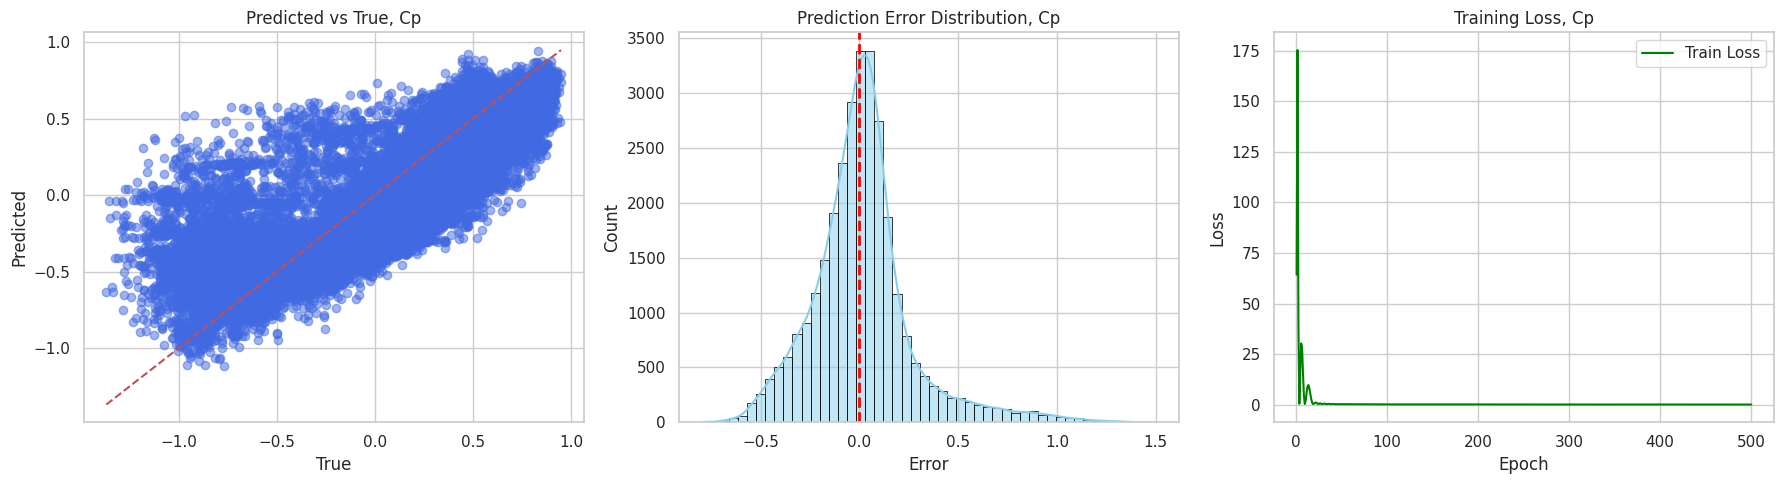

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 22/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   4%|▎         | 18/500 [00:00<00:02, 172.06it/s]

Epoch [10/500], Loss: 3.9720
Epoch [20/500], Loss: 1.0233
Epoch [30/500], Loss: 0.2711


Epochs:   7%|▋         | 36/500 [00:00<00:02, 165.07it/s]

Epoch [40/500], Loss: 0.2570


Epochs:  16%|█▌        | 80/500 [00:00<00:02, 199.56it/s]

Epoch [50/500], Loss: 0.2168
Epoch [60/500], Loss: 0.2018
Epoch [70/500], Loss: 0.1933
Epoch [80/500], Loss: 0.1833
Epoch [90/500], Loss: 0.1768


Epochs:  25%|██▍       | 124/500 [00:00<00:01, 210.83it/s]

Epoch [100/500], Loss: 0.1736
Epoch [110/500], Loss: 0.1650
Epoch [120/500], Loss: 0.1559
Epoch [130/500], Loss: 0.1481
Epoch [140/500], Loss: 0.1415


Epochs:  34%|███▍      | 169/500 [00:00<00:01, 215.67it/s]

Epoch [150/500], Loss: 0.1343
Epoch [160/500], Loss: 0.1271
Epoch [170/500], Loss: 0.1295
Epoch [180/500], Loss: 0.1127


Epochs:  38%|███▊      | 191/500 [00:00<00:01, 216.69it/s]

Epoch [190/500], Loss: 0.1025


Epochs:  43%|████▎     | 213/500 [00:01<00:01, 217.35it/s]

Epoch [200/500], Loss: 0.0954
Epoch [210/500], Loss: 0.0910
Epoch [220/500], Loss: 0.0877
Epoch [230/500], Loss: 0.0853


Epochs:  47%|████▋     | 236/500 [00:01<00:01, 218.40it/s]

Epoch [240/500], Loss: 0.0844


Epochs:  56%|█████▋    | 282/500 [00:01<00:00, 219.31it/s]

Epoch [250/500], Loss: 0.0859
Epoch [260/500], Loss: 0.0829
Epoch [270/500], Loss: 0.0815
Epoch [280/500], Loss: 0.0804
Epoch [290/500], Loss: 0.0796


Epochs:  65%|██████▌   | 326/500 [00:01<00:00, 219.20it/s]

Epoch [300/500], Loss: 0.0790
Epoch [310/500], Loss: 0.0786
Epoch [320/500], Loss: 0.0776
Epoch [330/500], Loss: 0.0776
Epoch [340/500], Loss: 0.0793


Epochs:  74%|███████▍  | 370/500 [00:01<00:00, 219.00it/s]

Epoch [350/500], Loss: 0.0758
Epoch [360/500], Loss: 0.0756
Epoch [370/500], Loss: 0.0741
Epoch [380/500], Loss: 0.0746


Epochs:  78%|███████▊  | 392/500 [00:01<00:00, 219.18it/s]

Epoch [390/500], Loss: 0.0754


Epochs:  83%|████████▎ | 414/500 [00:01<00:00, 219.17it/s]

Epoch [400/500], Loss: 0.0722
Epoch [410/500], Loss: 0.0719
Epoch [420/500], Loss: 0.0714
Epoch [430/500], Loss: 0.0718


Epochs:  87%|████████▋ | 436/500 [00:02<00:00, 219.05it/s]

Epoch [440/500], Loss: 0.0710


Epochs:  96%|█████████▌| 480/500 [00:02<00:00, 219.15it/s]

Epoch [450/500], Loss: 0.0713
Epoch [460/500], Loss: 0.0703
Epoch [470/500], Loss: 0.0701
Epoch [480/500], Loss: 0.0708
Epoch [490/500], Loss: 0.0686


Epochs: 100%|██████████| 500/500 [00:02<00:00, 214.18it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0682
📈 Evaluation metrics on test set:
MSE: 0.0694
MAE: 0.1879
R2: 0.7198


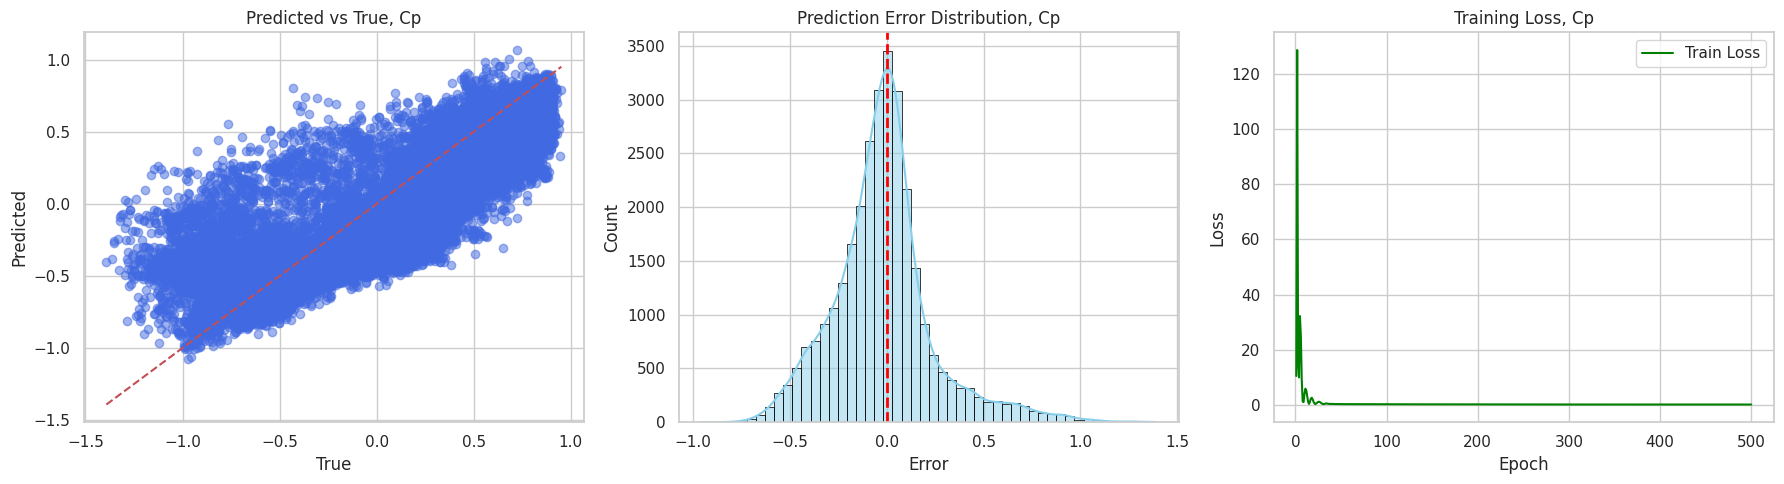

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 23/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 46/500 [00:00<00:02, 220.74it/s]

Epoch [10/500], Loss: 1.5581
Epoch [20/500], Loss: 0.5998
Epoch [30/500], Loss: 0.6460
Epoch [40/500], Loss: 0.3604
Epoch [50/500], Loss: 0.2469


Epochs:  18%|█▊        | 92/500 [00:00<00:01, 220.42it/s]

Epoch [60/500], Loss: 0.2086
Epoch [70/500], Loss: 0.2020
Epoch [80/500], Loss: 0.1984
Epoch [90/500], Loss: 0.1922
Epoch [100/500], Loss: 0.1846


Epochs:  28%|██▊       | 138/500 [00:00<00:01, 220.01it/s]

Epoch [110/500], Loss: 0.1783
Epoch [120/500], Loss: 0.1693
Epoch [130/500], Loss: 0.1586
Epoch [140/500], Loss: 0.1858
Epoch [150/500], Loss: 0.2074


Epochs:  37%|███▋      | 183/500 [00:00<00:01, 219.75it/s]

Epoch [160/500], Loss: 0.1850
Epoch [170/500], Loss: 0.1436
Epoch [180/500], Loss: 0.1337
Epoch [190/500], Loss: 0.1270
Epoch [200/500], Loss: 0.1211


Epochs:  50%|█████     | 250/500 [00:01<00:01, 219.49it/s]

Epoch [210/500], Loss: 0.1171
Epoch [220/500], Loss: 0.1135
Epoch [230/500], Loss: 0.1104
Epoch [240/500], Loss: 0.1078
Epoch [250/500], Loss: 0.1057


Epochs:  59%|█████▉    | 294/500 [00:01<00:00, 218.83it/s]

Epoch [260/500], Loss: 0.1038
Epoch [270/500], Loss: 0.1021
Epoch [280/500], Loss: 0.1006
Epoch [290/500], Loss: 0.0994
Epoch [300/500], Loss: 0.0982


Epochs:  68%|██████▊   | 338/500 [00:01<00:00, 218.96it/s]

Epoch [310/500], Loss: 0.0976
Epoch [320/500], Loss: 0.0959
Epoch [330/500], Loss: 0.0948
Epoch [340/500], Loss: 0.0936
Epoch [350/500], Loss: 0.0925


Epochs:  76%|███████▋  | 382/500 [00:01<00:00, 218.87it/s]

Epoch [360/500], Loss: 0.0914
Epoch [370/500], Loss: 0.0903
Epoch [380/500], Loss: 0.0893
Epoch [390/500], Loss: 0.0884
Epoch [400/500], Loss: 0.0878


Epochs:  90%|████████▉ | 448/500 [00:02<00:00, 218.78it/s]

Epoch [410/500], Loss: 0.0873
Epoch [420/500], Loss: 0.0865
Epoch [430/500], Loss: 0.0858
Epoch [440/500], Loss: 0.0853
Epoch [450/500], Loss: 0.0847


Epochs: 100%|██████████| 500/500 [00:02<00:00, 219.32it/s]

Epoch [460/500], Loss: 0.0842
Epoch [470/500], Loss: 0.0837
Epoch [480/500], Loss: 0.0844
Epoch [490/500], Loss: 0.0828
Epoch [500/500], Loss: 0.0824
📈 Evaluation metrics on test set:
MSE: 0.0839
MAE: 0.2076
R2: 0.6622



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


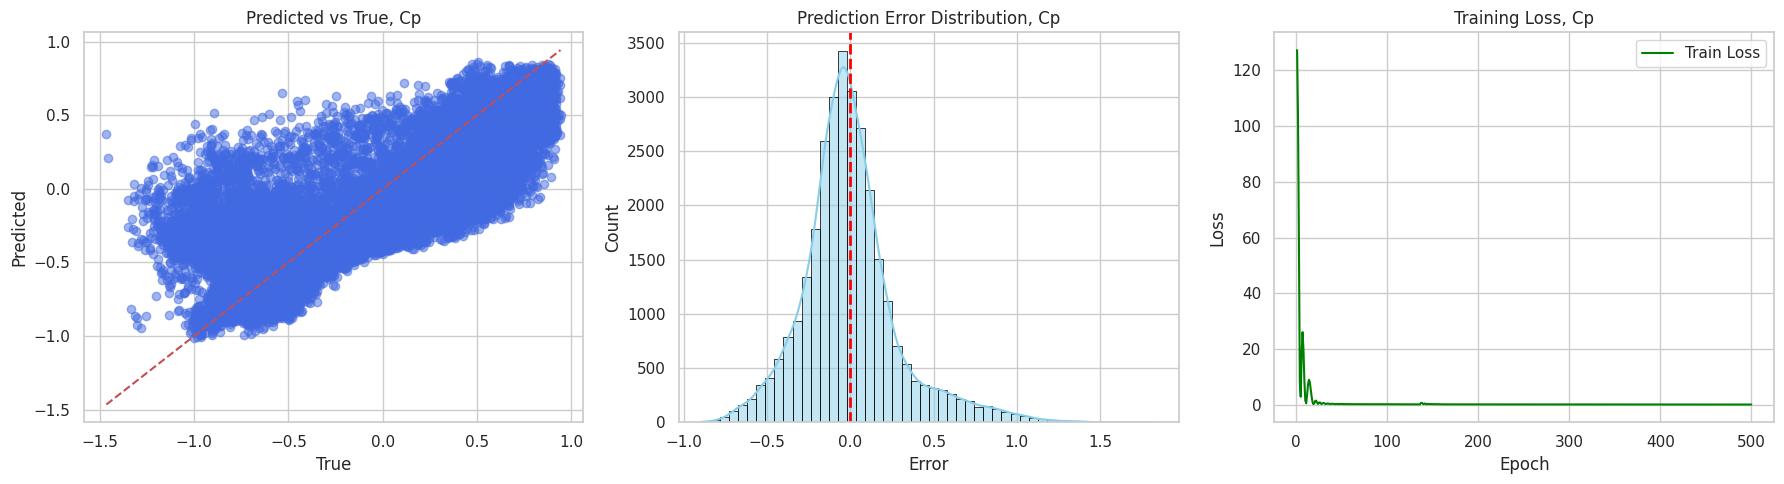

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 24/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   5%|▍         | 23/500 [00:00<00:02, 221.86it/s]

Epoch [10/500], Loss: 0.2831
Epoch [20/500], Loss: 2.4352
Epoch [30/500], Loss: 0.7995
Epoch [40/500], Loss: 0.3887


Epochs:   9%|▉         | 46/500 [00:00<00:02, 219.24it/s]

Epoch [50/500], Loss: 0.2825


Epochs:  18%|█▊        | 91/500 [00:00<00:01, 219.46it/s]

Epoch [60/500], Loss: 0.2325
Epoch [70/500], Loss: 0.2142
Epoch [80/500], Loss: 0.2105
Epoch [90/500], Loss: 0.1835
Epoch [100/500], Loss: 0.1518


Epochs:  27%|██▋       | 135/500 [00:00<00:01, 219.47it/s]

Epoch [110/500], Loss: 0.1402
Epoch [120/500], Loss: 0.1303
Epoch [130/500], Loss: 0.1187
Epoch [140/500], Loss: 0.1100
Epoch [150/500], Loss: 0.1030


Epochs:  36%|███▌      | 180/500 [00:00<00:01, 219.37it/s]

Epoch [160/500], Loss: 0.0976
Epoch [170/500], Loss: 0.0932
Epoch [180/500], Loss: 0.0900
Epoch [190/500], Loss: 0.0878


Epochs:  40%|████      | 202/500 [00:00<00:01, 218.80it/s]

Epoch [200/500], Loss: 0.0860


Epochs:  45%|████▍     | 224/500 [00:01<00:01, 218.99it/s]

Epoch [210/500], Loss: 0.0846
Epoch [220/500], Loss: 0.0834
Epoch [230/500], Loss: 0.0831
Epoch [240/500], Loss: 0.0817


Epochs:  49%|████▉     | 246/500 [00:01<00:01, 218.45it/s]

Epoch [250/500], Loss: 0.0807


Epochs:  58%|█████▊    | 290/500 [00:01<00:00, 218.55it/s]

Epoch [260/500], Loss: 0.0798
Epoch [270/500], Loss: 0.0791
Epoch [280/500], Loss: 0.0805
Epoch [290/500], Loss: 0.0784
Epoch [300/500], Loss: 0.0777


Epochs:  67%|██████▋   | 334/500 [00:01<00:00, 218.48it/s]

Epoch [310/500], Loss: 0.0773
Epoch [320/500], Loss: 0.0768
Epoch [330/500], Loss: 0.0764
Epoch [340/500], Loss: 0.0761
Epoch [350/500], Loss: 0.0767


Epochs:  76%|███████▌  | 378/500 [00:01<00:00, 218.15it/s]

Epoch [360/500], Loss: 0.0755
Epoch [370/500], Loss: 0.0750
Epoch [380/500], Loss: 0.0748
Epoch [390/500], Loss: 0.0744


Epochs:  80%|████████  | 400/500 [00:01<00:00, 218.20it/s]

Epoch [400/500], Loss: 0.0746


Epochs:  84%|████████▍ | 422/500 [00:01<00:00, 218.24it/s]

Epoch [410/500], Loss: 0.0743
Epoch [420/500], Loss: 0.0736
Epoch [430/500], Loss: 0.0732
Epoch [440/500], Loss: 0.0730


Epochs:  89%|████████▉ | 444/500 [00:02<00:00, 216.51it/s]

Epoch [450/500], Loss: 0.0725


Epochs:  98%|█████████▊| 488/500 [00:02<00:00, 217.64it/s]

Epoch [460/500], Loss: 0.0723
Epoch [470/500], Loss: 0.0718
Epoch [480/500], Loss: 0.0718
Epoch [490/500], Loss: 0.0713


Epochs: 100%|██████████| 500/500 [00:02<00:00, 218.41it/s]

Epoch [500/500], Loss: 0.0710
📈 Evaluation metrics on test set:
MSE: 0.0708
MAE: 0.1830
R2: 0.7136



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


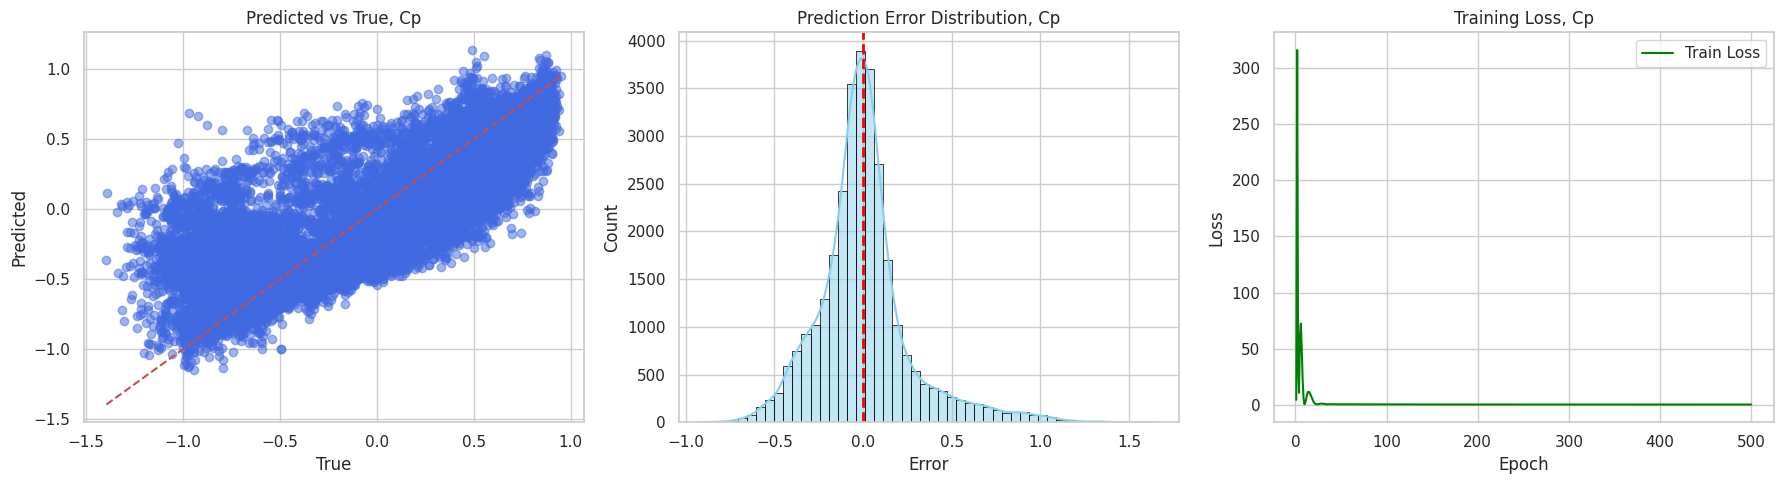

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 25/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   3%|▎         | 17/500 [00:00<00:02, 164.07it/s]

Epoch [10/500], Loss: 1.9625
Epoch [20/500], Loss: 1.0277
Epoch [30/500], Loss: 0.5231


Epochs:   7%|▋         | 34/500 [00:00<00:02, 163.42it/s]

Epoch [40/500], Loss: 0.2446


Epochs:  16%|█▌        | 78/500 [00:00<00:02, 199.89it/s]

Epoch [50/500], Loss: 0.2288
Epoch [60/500], Loss: 0.2150
Epoch [70/500], Loss: 0.2057
Epoch [80/500], Loss: 0.1970
Epoch [90/500], Loss: 0.1614


Epochs:  25%|██▍       | 123/500 [00:00<00:01, 211.83it/s]

Epoch [100/500], Loss: 0.1471
Epoch [110/500], Loss: 0.1322
Epoch [120/500], Loss: 0.1231
Epoch [130/500], Loss: 0.1167
Epoch [140/500], Loss: 0.1127


Epochs:  34%|███▎      | 168/500 [00:00<00:01, 216.32it/s]

Epoch [150/500], Loss: 0.1139
Epoch [160/500], Loss: 0.1071
Epoch [170/500], Loss: 0.1047
Epoch [180/500], Loss: 0.1015


Epochs:  38%|███▊      | 190/500 [00:00<00:01, 217.33it/s]

Epoch [190/500], Loss: 0.1056


Epochs:  43%|████▎     | 213/500 [00:01<00:01, 218.25it/s]

Epoch [200/500], Loss: 0.1052
Epoch [210/500], Loss: 0.0982
Epoch [220/500], Loss: 0.0946
Epoch [230/500], Loss: 0.0927


Epochs:  47%|████▋     | 236/500 [00:01<00:01, 218.83it/s]

Epoch [240/500], Loss: 0.0906


Epochs:  56%|█████▋    | 282/500 [00:01<00:00, 219.67it/s]

Epoch [250/500], Loss: 0.0927
Epoch [260/500], Loss: 0.0881
Epoch [270/500], Loss: 0.0887
Epoch [280/500], Loss: 0.0861
Epoch [290/500], Loss: 0.0848


Epochs:  66%|██████▌   | 328/500 [00:01<00:00, 220.11it/s]

Epoch [300/500], Loss: 0.0881
Epoch [310/500], Loss: 0.0865
Epoch [320/500], Loss: 0.0832
Epoch [330/500], Loss: 0.0818
Epoch [340/500], Loss: 0.0813


Epochs:  75%|███████▍  | 373/500 [00:01<00:00, 219.56it/s]

Epoch [350/500], Loss: 0.0863
Epoch [360/500], Loss: 0.0817
Epoch [370/500], Loss: 0.0797
Epoch [380/500], Loss: 0.0787
Epoch [390/500], Loss: 0.0782


Epochs:  83%|████████▎ | 417/500 [00:01<00:00, 219.62it/s]

Epoch [400/500], Loss: 0.0976
Epoch [410/500], Loss: 0.0794
Epoch [420/500], Loss: 0.0786
Epoch [430/500], Loss: 0.0768


Epochs:  88%|████████▊ | 440/500 [00:02<00:00, 219.70it/s]

Epoch [440/500], Loss: 0.0766


Epochs:  92%|█████████▏| 462/500 [00:02<00:00, 219.40it/s]

Epoch [450/500], Loss: 0.0761
Epoch [460/500], Loss: 0.0758
Epoch [470/500], Loss: 0.0769
Epoch [480/500], Loss: 0.0889


Epochs:  97%|█████████▋| 484/500 [00:02<00:00, 219.16it/s]

Epoch [490/500], Loss: 0.0799


Epochs: 100%|██████████| 500/500 [00:02<00:00, 214.59it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0759
📈 Evaluation metrics on test set:
MSE: 0.0758
MAE: 0.1914
R2: 0.6950


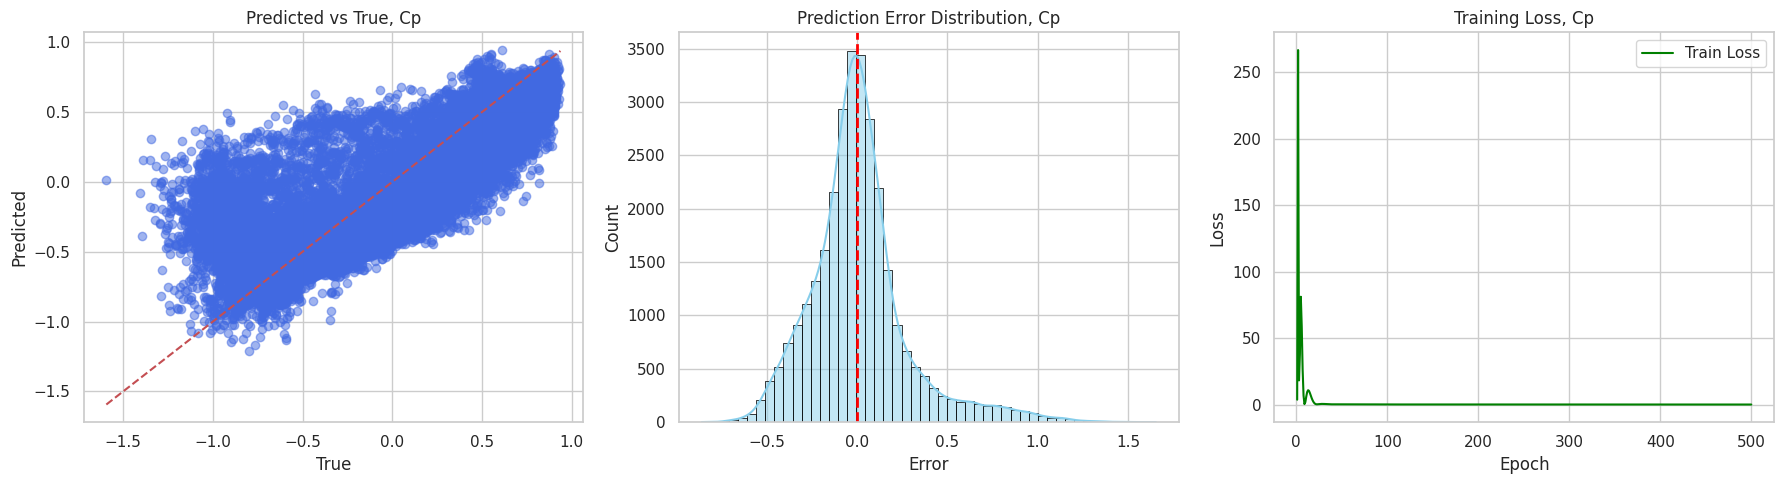

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 26/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   5%|▍         | 23/500 [00:00<00:02, 221.77it/s]

Epoch [10/500], Loss: 0.3674
Epoch [20/500], Loss: 1.3784
Epoch [30/500], Loss: 0.2763
Epoch [40/500], Loss: 0.2377


Epochs:   9%|▉         | 46/500 [00:00<00:02, 220.39it/s]

Epoch [50/500], Loss: 0.2261


Epochs:  18%|█▊        | 92/500 [00:00<00:01, 220.16it/s]

Epoch [60/500], Loss: 0.2172
Epoch [70/500], Loss: 0.2092
Epoch [80/500], Loss: 0.2046
Epoch [90/500], Loss: 0.2014
Epoch [100/500], Loss: 0.1985


Epochs:  27%|██▋       | 137/500 [00:00<00:01, 219.29it/s]

Epoch [110/500], Loss: 0.1957
Epoch [120/500], Loss: 0.1931
Epoch [130/500], Loss: 0.1906
Epoch [140/500], Loss: 0.1881
Epoch [150/500], Loss: 0.3427


Epochs:  36%|███▋      | 182/500 [00:00<00:01, 219.55it/s]

Epoch [160/500], Loss: 0.2906
Epoch [170/500], Loss: 0.1924
Epoch [180/500], Loss: 0.1580
Epoch [190/500], Loss: 0.1473


Epochs:  41%|████      | 204/500 [00:00<00:01, 219.46it/s]

Epoch [200/500], Loss: 0.1409


Epochs:  45%|████▌     | 226/500 [00:01<00:01, 219.43it/s]

Epoch [210/500], Loss: 0.1383
Epoch [220/500], Loss: 0.1340
Epoch [230/500], Loss: 0.1279
Epoch [240/500], Loss: 0.1204


Epochs:  50%|████▉     | 248/500 [00:01<00:01, 219.60it/s]

Epoch [250/500], Loss: 0.1152


Epochs:  58%|█████▊    | 292/500 [00:01<00:00, 219.17it/s]

Epoch [260/500], Loss: 0.1099
Epoch [270/500], Loss: 0.1080
Epoch [280/500], Loss: 0.1056
Epoch [290/500], Loss: 0.1045
Epoch [300/500], Loss: 0.1026


Epochs:  67%|██████▋   | 336/500 [00:01<00:00, 219.42it/s]

Epoch [310/500], Loss: 0.1013
Epoch [320/500], Loss: 0.1011
Epoch [330/500], Loss: 0.0992
Epoch [340/500], Loss: 0.0971
Epoch [350/500], Loss: 0.0959


Epochs:  76%|███████▌  | 380/500 [00:01<00:00, 219.11it/s]

Epoch [360/500], Loss: 0.0948
Epoch [370/500], Loss: 0.0937
Epoch [380/500], Loss: 0.0927
Epoch [390/500], Loss: 0.0918


Epochs:  80%|████████  | 402/500 [00:01<00:00, 219.17it/s]

Epoch [400/500], Loss: 0.0907


Epochs:  85%|████████▍ | 424/500 [00:01<00:00, 218.99it/s]

Epoch [410/500], Loss: 0.0897
Epoch [420/500], Loss: 0.0894
Epoch [430/500], Loss: 0.0889
Epoch [440/500], Loss: 0.0871


Epochs:  89%|████████▉ | 446/500 [00:02<00:00, 218.96it/s]

Epoch [450/500], Loss: 0.0858


Epochs:  98%|█████████▊| 490/500 [00:02<00:00, 218.79it/s]

Epoch [460/500], Loss: 0.0846
Epoch [470/500], Loss: 0.0836
Epoch [480/500], Loss: 0.0839
Epoch [490/500], Loss: 0.0833


Epochs: 100%|██████████| 500/500 [00:02<00:00, 219.24it/s]

Epoch [500/500], Loss: 0.0815
📈 Evaluation metrics on test set:
MSE: 0.0814
MAE: 0.2052
R2: 0.6757



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


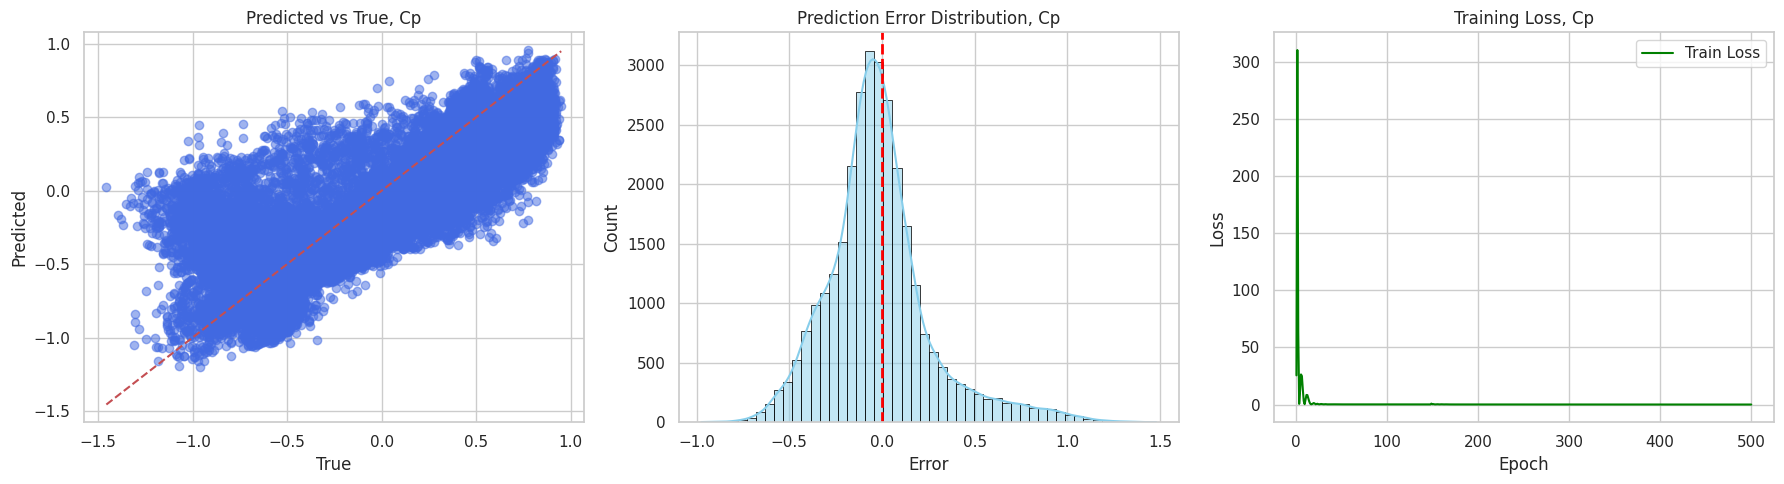

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 27/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   4%|▍         | 22/500 [00:00<00:02, 213.17it/s]

Epoch [10/500], Loss: 1.0405
Epoch [20/500], Loss: 0.6624
Epoch [30/500], Loss: 0.2967
Epoch [40/500], Loss: 0.2116


Epochs:  18%|█▊        | 88/500 [00:00<00:01, 211.39it/s]

Epoch [50/500], Loss: 0.1999
Epoch [60/500], Loss: 0.1841
Epoch [70/500], Loss: 0.1697
Epoch [80/500], Loss: 0.1306
Epoch [90/500], Loss: 0.1091


Epochs:  26%|██▋       | 132/500 [00:00<00:01, 215.84it/s]

Epoch [100/500], Loss: 0.0981
Epoch [110/500], Loss: 0.0921
Epoch [120/500], Loss: 0.0918
Epoch [130/500], Loss: 0.0915
Epoch [140/500], Loss: 0.0868


Epochs:  35%|███▌      | 177/500 [00:00<00:01, 217.78it/s]

Epoch [150/500], Loss: 0.0847
Epoch [160/500], Loss: 0.0831
Epoch [170/500], Loss: 0.0817
Epoch [180/500], Loss: 0.0806
Epoch [190/500], Loss: 0.0798


Epochs:  49%|████▊     | 243/500 [00:01<00:01, 218.43it/s]

Epoch [200/500], Loss: 0.0796
Epoch [210/500], Loss: 0.0909
Epoch [220/500], Loss: 0.0797
Epoch [230/500], Loss: 0.0791
Epoch [240/500], Loss: 0.0765


Epochs:  57%|█████▋    | 287/500 [00:01<00:00, 218.49it/s]

Epoch [250/500], Loss: 0.0757
Epoch [260/500], Loss: 0.0744
Epoch [270/500], Loss: 0.0735
Epoch [280/500], Loss: 0.0726
Epoch [290/500], Loss: 0.0746


Epochs:  66%|██████▌   | 331/500 [00:01<00:00, 218.99it/s]

Epoch [300/500], Loss: 0.0711
Epoch [310/500], Loss: 0.0698
Epoch [320/500], Loss: 0.0695
Epoch [330/500], Loss: 0.0676
Epoch [340/500], Loss: 0.0871


Epochs:  75%|███████▌  | 375/500 [00:01<00:00, 218.85it/s]

Epoch [350/500], Loss: 0.0716
Epoch [360/500], Loss: 0.0726
Epoch [370/500], Loss: 0.0667
Epoch [380/500], Loss: 0.0646
Epoch [390/500], Loss: 0.0628


Epochs:  88%|████████▊ | 441/500 [00:02<00:00, 218.86it/s]

Epoch [400/500], Loss: 0.0618
Epoch [410/500], Loss: 0.0610
Epoch [420/500], Loss: 0.0616
Epoch [430/500], Loss: 0.0610
Epoch [440/500], Loss: 0.0606


Epochs:  97%|█████████▋| 485/500 [00:02<00:00, 218.74it/s]

Epoch [450/500], Loss: 0.0624
Epoch [460/500], Loss: 0.0603
Epoch [470/500], Loss: 0.0590
Epoch [480/500], Loss: 0.0583
Epoch [490/500], Loss: 0.0580


Epochs: 100%|██████████| 500/500 [00:02<00:00, 217.06it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0579
📈 Evaluation metrics on test set:
MSE: 0.0585
MAE: 0.1687
R2: 0.7629


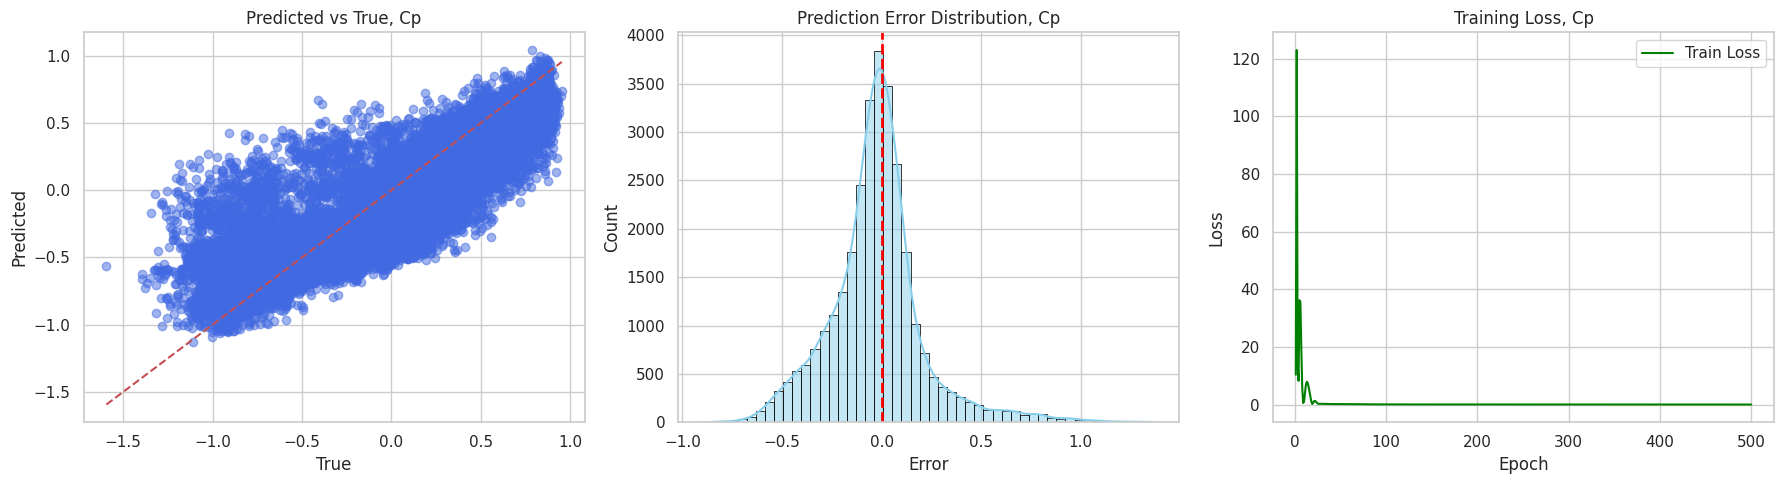

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 28/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   3%|▎         | 17/500 [00:00<00:02, 161.95it/s]

Epoch [10/500], Loss: 4.1480
Epoch [20/500], Loss: 2.1108
Epoch [30/500], Loss: 0.4637


Epochs:   7%|▋         | 35/500 [00:00<00:02, 171.50it/s]

Epoch [40/500], Loss: 0.2405


Epochs:  15%|█▌        | 76/500 [00:00<00:02, 193.67it/s]

Epoch [50/500], Loss: 0.3492
Epoch [60/500], Loss: 0.2448
Epoch [70/500], Loss: 0.2146
Epoch [80/500], Loss: 0.2090
Epoch [90/500], Loss: 0.2061


Epochs:  24%|██▍       | 120/500 [00:00<00:01, 208.07it/s]

Epoch [100/500], Loss: 0.2037
Epoch [110/500], Loss: 0.2004
Epoch [120/500], Loss: 0.1978
Epoch [130/500], Loss: 0.1947


Epochs:  28%|██▊       | 142/500 [00:00<00:01, 210.97it/s]

Epoch [140/500], Loss: 0.1916


Epochs:  33%|███▎      | 164/500 [00:00<00:01, 213.53it/s]

Epoch [150/500], Loss: 0.1806
Epoch [160/500], Loss: 0.1574
Epoch [170/500], Loss: 0.1254
Epoch [180/500], Loss: 0.1132


Epochs:  37%|███▋      | 186/500 [00:00<00:01, 214.98it/s]

Epoch [190/500], Loss: 0.1078


Epochs:  46%|████▌     | 230/500 [00:01<00:01, 216.91it/s]

Epoch [200/500], Loss: 0.1047
Epoch [210/500], Loss: 0.1026
Epoch [220/500], Loss: 0.1006
Epoch [230/500], Loss: 0.0959
Epoch [240/500], Loss: 0.0905


Epochs:  55%|█████▍    | 274/500 [00:01<00:01, 217.84it/s]

Epoch [250/500], Loss: 0.0877
Epoch [260/500], Loss: 0.0847
Epoch [270/500], Loss: 0.0824
Epoch [280/500], Loss: 0.0809
Epoch [290/500], Loss: 0.0799


Epochs:  64%|██████▎   | 318/500 [00:01<00:00, 218.38it/s]

Epoch [300/500], Loss: 0.0790
Epoch [310/500], Loss: 0.0782
Epoch [320/500], Loss: 0.0779
Epoch [330/500], Loss: 0.0768


Epochs:  68%|██████▊   | 340/500 [00:01<00:00, 218.56it/s]

Epoch [340/500], Loss: 0.0760


Epochs:  72%|███████▏  | 362/500 [00:01<00:00, 218.91it/s]

Epoch [350/500], Loss: 0.0766
Epoch [360/500], Loss: 0.0744
Epoch [370/500], Loss: 0.0749
Epoch [380/500], Loss: 0.0739


Epochs:  77%|███████▋  | 384/500 [00:01<00:00, 218.84it/s]

Epoch [390/500], Loss: 0.0726


Epochs:  86%|████████▌ | 428/500 [00:02<00:00, 218.72it/s]

Epoch [400/500], Loss: 0.0737
Epoch [410/500], Loss: 0.0713
Epoch [420/500], Loss: 0.0708
Epoch [430/500], Loss: 0.0700
Epoch [440/500], Loss: 0.0696


Epochs:  94%|█████████▍| 472/500 [00:02<00:00, 218.73it/s]

Epoch [450/500], Loss: 0.0691
Epoch [460/500], Loss: 0.0685
Epoch [470/500], Loss: 0.0686
Epoch [480/500], Loss: 0.0682
Epoch [490/500], Loss: 0.0678


Epochs: 100%|██████████| 500/500 [00:02<00:00, 213.07it/s]


Epoch [500/500], Loss: 0.0674
📈 Evaluation metrics on test set:
MSE: 0.0668
MAE: 0.1790
R2: 0.7297


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


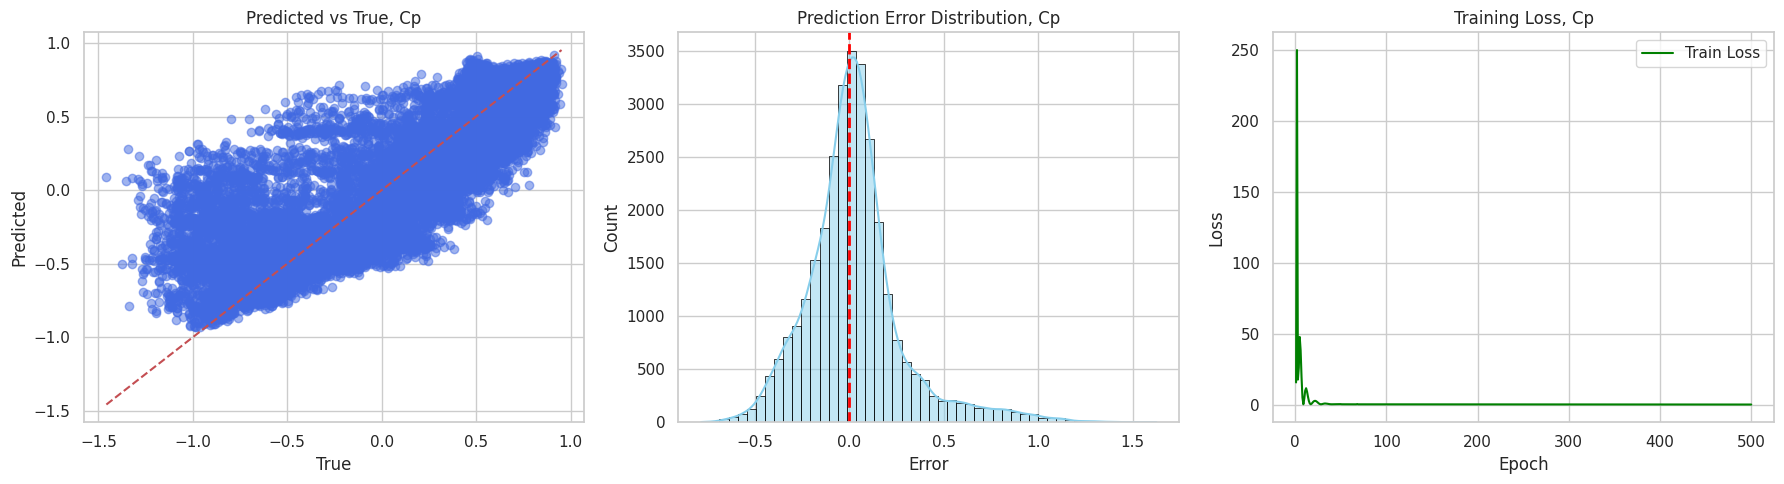

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 29/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   7%|▋         | 35/500 [00:00<00:02, 170.95it/s]

Epoch [10/500], Loss: 1.3690
Epoch [20/500], Loss: 2.8651
Epoch [30/500], Loss: 0.9921
Epoch [40/500], Loss: 0.3229


Epochs:  15%|█▌        | 76/500 [00:00<00:02, 192.95it/s]

Epoch [50/500], Loss: 0.2423
Epoch [60/500], Loss: 0.2178
Epoch [70/500], Loss: 0.2051
Epoch [80/500], Loss: 0.1799
Epoch [90/500], Loss: 0.1627


Epochs:  28%|██▊       | 142/500 [00:00<00:01, 211.54it/s]

Epoch [100/500], Loss: 0.1518
Epoch [110/500], Loss: 0.1405
Epoch [120/500], Loss: 0.1317
Epoch [130/500], Loss: 0.1245
Epoch [140/500], Loss: 0.1204


Epochs:  37%|███▋      | 186/500 [00:00<00:01, 215.39it/s]

Epoch [150/500], Loss: 0.1137
Epoch [160/500], Loss: 0.1099
Epoch [170/500], Loss: 0.1056
Epoch [180/500], Loss: 0.1045
Epoch [190/500], Loss: 0.0987


Epochs:  46%|████▌     | 230/500 [00:01<00:01, 217.01it/s]

Epoch [200/500], Loss: 0.0973
Epoch [210/500], Loss: 0.0930
Epoch [220/500], Loss: 0.0951
Epoch [230/500], Loss: 0.0903
Epoch [240/500], Loss: 0.0862


Epochs:  55%|█████▍    | 274/500 [00:01<00:01, 217.41it/s]

Epoch [250/500], Loss: 0.0850
Epoch [260/500], Loss: 0.0894
Epoch [270/500], Loss: 0.0843
Epoch [280/500], Loss: 0.0814
Epoch [290/500], Loss: 0.0816


Epochs:  68%|██████▊   | 340/500 [00:01<00:00, 217.84it/s]

Epoch [300/500], Loss: 0.0816
Epoch [310/500], Loss: 0.0803
Epoch [320/500], Loss: 0.0806
Epoch [330/500], Loss: 0.0779
Epoch [340/500], Loss: 0.0783


Epochs:  77%|███████▋  | 384/500 [00:01<00:00, 218.42it/s]

Epoch [350/500], Loss: 0.0809
Epoch [360/500], Loss: 0.0771
Epoch [370/500], Loss: 0.0809
Epoch [380/500], Loss: 0.0786
Epoch [390/500], Loss: 0.0768


Epochs:  86%|████████▌ | 429/500 [00:02<00:00, 219.01it/s]

Epoch [400/500], Loss: 0.0744
Epoch [410/500], Loss: 0.0748
Epoch [420/500], Loss: 0.0739
Epoch [430/500], Loss: 0.0781
Epoch [440/500], Loss: 0.0752


Epochs:  95%|█████████▍| 473/500 [00:02<00:00, 219.09it/s]

Epoch [450/500], Loss: 0.0720
Epoch [460/500], Loss: 0.0729
Epoch [470/500], Loss: 0.0750
Epoch [480/500], Loss: 0.0791
Epoch [490/500], Loss: 0.0767


Epochs: 100%|██████████| 500/500 [00:02<00:00, 213.04it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0710
📈 Evaluation metrics on test set:
MSE: 0.0706
MAE: 0.1864
R2: 0.7146


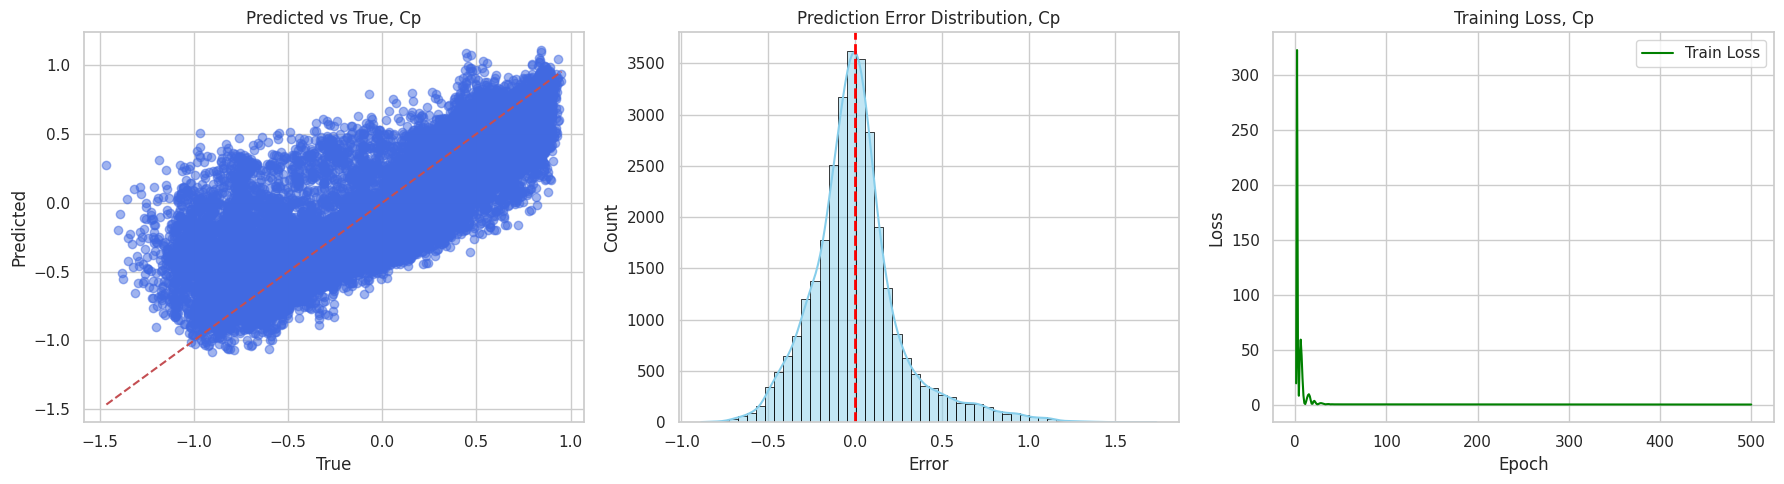

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 30/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   8%|▊         | 38/500 [00:00<00:02, 171.75it/s]

Epoch [10/500], Loss: 0.3381
Epoch [20/500], Loss: 1.0623
Epoch [30/500], Loss: 0.3276
Epoch [40/500], Loss: 0.2589


Epochs:  17%|█▋        | 83/500 [00:00<00:02, 202.03it/s]

Epoch [50/500], Loss: 0.2306
Epoch [60/500], Loss: 0.2080
Epoch [70/500], Loss: 0.2013
Epoch [80/500], Loss: 0.1966
Epoch [90/500], Loss: 0.1930


Epochs:  26%|██▌       | 128/500 [00:00<00:01, 212.39it/s]

Epoch [100/500], Loss: 0.1874
Epoch [110/500], Loss: 0.1815
Epoch [120/500], Loss: 0.1738
Epoch [130/500], Loss: 0.1632
Epoch [140/500], Loss: 0.1511


Epochs:  35%|███▍      | 173/500 [00:00<00:01, 216.34it/s]

Epoch [150/500], Loss: 0.1431
Epoch [160/500], Loss: 0.1361
Epoch [170/500], Loss: 0.1258
Epoch [180/500], Loss: 0.1173
Epoch [190/500], Loss: 0.1122


Epochs:  48%|████▊     | 240/500 [00:01<00:01, 218.58it/s]

Epoch [200/500], Loss: 0.1064
Epoch [210/500], Loss: 0.1025
Epoch [220/500], Loss: 0.0996
Epoch [230/500], Loss: 0.0981
Epoch [240/500], Loss: 0.0955


Epochs:  57%|█████▋    | 284/500 [00:01<00:00, 219.13it/s]

Epoch [250/500], Loss: 0.0936
Epoch [260/500], Loss: 0.0923
Epoch [270/500], Loss: 0.0908
Epoch [280/500], Loss: 0.0896
Epoch [290/500], Loss: 0.0887


Epochs:  66%|██████▌   | 328/500 [00:01<00:00, 219.27it/s]

Epoch [300/500], Loss: 0.0876
Epoch [310/500], Loss: 0.0868
Epoch [320/500], Loss: 0.0858
Epoch [330/500], Loss: 0.0847
Epoch [340/500], Loss: 0.0873


Epochs:  74%|███████▍  | 372/500 [00:01<00:00, 218.95it/s]

Epoch [350/500], Loss: 0.0829
Epoch [360/500], Loss: 0.0825
Epoch [370/500], Loss: 0.0816
Epoch [380/500], Loss: 0.0812
Epoch [390/500], Loss: 0.0808


Epochs:  88%|████████▊ | 438/500 [00:02<00:00, 219.25it/s]

Epoch [400/500], Loss: 0.0815
Epoch [410/500], Loss: 0.0805
Epoch [420/500], Loss: 0.0797
Epoch [430/500], Loss: 0.0792
Epoch [440/500], Loss: 0.0789


Epochs:  96%|█████████▋| 482/500 [00:02<00:00, 219.09it/s]

Epoch [450/500], Loss: 0.0796
Epoch [460/500], Loss: 0.0790
Epoch [470/500], Loss: 0.0783
Epoch [480/500], Loss: 0.0776
Epoch [490/500], Loss: 0.0797


Epochs: 100%|██████████| 500/500 [00:02<00:00, 214.78it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0786
📈 Evaluation metrics on test set:
MSE: 0.0809
MAE: 0.2051
R2: 0.6718


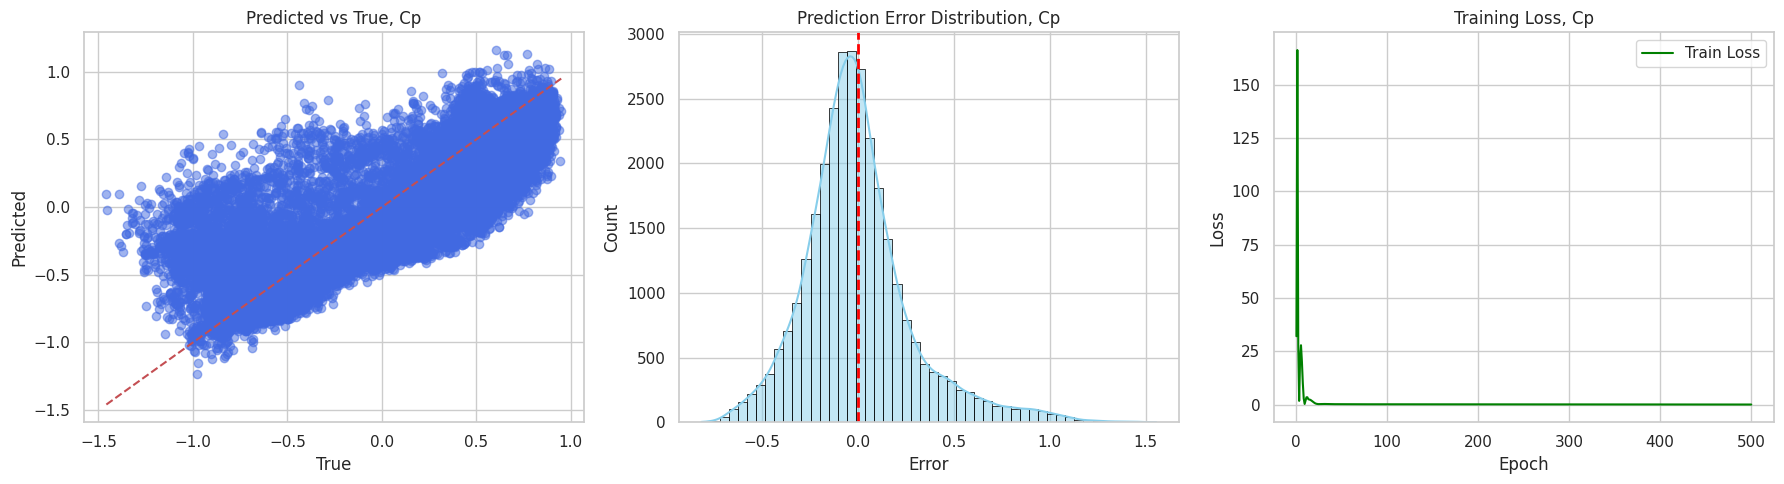

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 31/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 46/500 [00:00<00:02, 219.96it/s]

Epoch [10/500], Loss: 0.2885
Epoch [20/500], Loss: 0.4662
Epoch [30/500], Loss: 0.3107
Epoch [40/500], Loss: 0.2299
Epoch [50/500], Loss: 0.2033


Epochs:  18%|█▊        | 90/500 [00:00<00:01, 219.26it/s]

Epoch [60/500], Loss: 0.1951
Epoch [70/500], Loss: 0.1917
Epoch [80/500], Loss: 0.1856
Epoch [90/500], Loss: 0.1815
Epoch [100/500], Loss: 0.1767


Epochs:  27%|██▋       | 134/500 [00:00<00:01, 218.68it/s]

Epoch [110/500], Loss: 0.1698
Epoch [120/500], Loss: 0.1644
Epoch [130/500], Loss: 0.1551
Epoch [140/500], Loss: 0.1472
Epoch [150/500], Loss: 0.1411


Epochs:  40%|████      | 200/500 [00:00<00:01, 218.70it/s]

Epoch [160/500], Loss: 0.1367
Epoch [170/500], Loss: 0.1332
Epoch [180/500], Loss: 0.1305
Epoch [190/500], Loss: 0.1309
Epoch [200/500], Loss: 0.1274


Epochs:  49%|████▉     | 245/500 [00:01<00:01, 219.19it/s]

Epoch [210/500], Loss: 0.1230
Epoch [220/500], Loss: 0.1197
Epoch [230/500], Loss: 0.1154
Epoch [240/500], Loss: 0.1094
Epoch [250/500], Loss: 0.1072


Epochs:  58%|█████▊    | 289/500 [00:01<00:00, 219.53it/s]

Epoch [260/500], Loss: 0.1117
Epoch [270/500], Loss: 0.0998
Epoch [280/500], Loss: 0.0965
Epoch [290/500], Loss: 0.0940
Epoch [300/500], Loss: 0.0927


Epochs:  67%|██████▋   | 333/500 [00:01<00:00, 219.37it/s]

Epoch [310/500], Loss: 0.0908
Epoch [320/500], Loss: 0.0966
Epoch [330/500], Loss: 0.0912
Epoch [340/500], Loss: 0.0883
Epoch [350/500], Loss: 0.0880


Epochs:  80%|███████▉  | 399/500 [00:01<00:00, 219.26it/s]

Epoch [360/500], Loss: 0.0863
Epoch [370/500], Loss: 0.0857
Epoch [380/500], Loss: 0.0978
Epoch [390/500], Loss: 0.0880
Epoch [400/500], Loss: 0.0845


Epochs:  89%|████████▊ | 443/500 [00:02<00:00, 218.90it/s]

Epoch [410/500], Loss: 0.0848
Epoch [420/500], Loss: 0.0838
Epoch [430/500], Loss: 0.0833
Epoch [440/500], Loss: 0.0830
Epoch [450/500], Loss: 0.0842


Epochs: 100%|██████████| 500/500 [00:02<00:00, 218.96it/s]

Epoch [460/500], Loss: 0.0865
Epoch [470/500], Loss: 0.0894
Epoch [480/500], Loss: 0.0843
Epoch [490/500], Loss: 0.0818
Epoch [500/500], Loss: 0.0817
📈 Evaluation metrics on test set:
MSE: 0.0815
MAE: 0.2021
R2: 0.6708



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


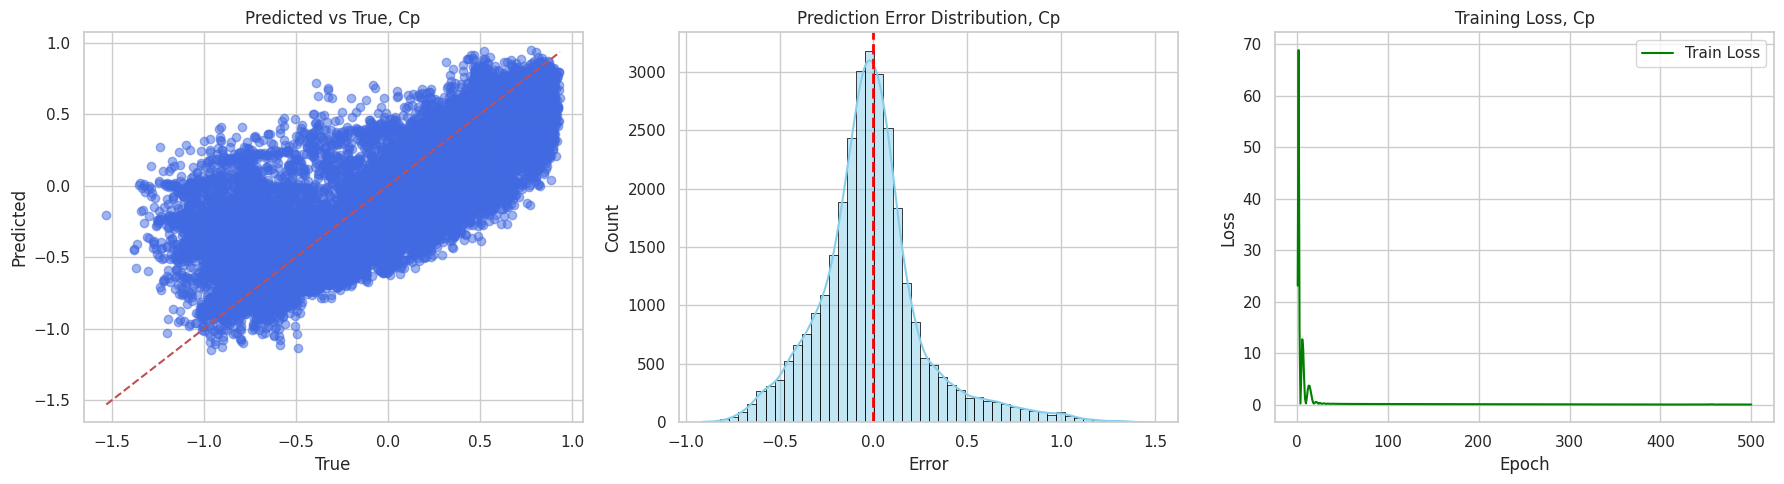

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 32/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   7%|▋         | 35/500 [00:00<00:02, 169.56it/s]

Epoch [10/500], Loss: 2.6603
Epoch [20/500], Loss: 0.3019
Epoch [30/500], Loss: 0.7111
Epoch [40/500], Loss: 0.2680


Epochs:  16%|█▌        | 78/500 [00:00<00:02, 197.06it/s]

Epoch [50/500], Loss: 0.2341
Epoch [60/500], Loss: 0.2049
Epoch [70/500], Loss: 0.1900
Epoch [80/500], Loss: 0.1801
Epoch [90/500], Loss: 0.1677


Epochs:  29%|██▉       | 144/500 [00:00<00:01, 212.90it/s]

Epoch [100/500], Loss: 0.1530
Epoch [110/500], Loss: 0.1366
Epoch [120/500], Loss: 0.1436
Epoch [130/500], Loss: 0.1247
Epoch [140/500], Loss: 0.1178


Epochs:  38%|███▊      | 188/500 [00:00<00:01, 215.77it/s]

Epoch [150/500], Loss: 0.1137
Epoch [160/500], Loss: 0.1103
Epoch [170/500], Loss: 0.1071
Epoch [180/500], Loss: 0.1036
Epoch [190/500], Loss: 0.1008


Epochs:  46%|████▋     | 232/500 [00:01<00:01, 216.83it/s]

Epoch [200/500], Loss: 0.0982
Epoch [210/500], Loss: 0.0956
Epoch [220/500], Loss: 0.0932
Epoch [230/500], Loss: 0.0908
Epoch [240/500], Loss: 0.0885


Epochs:  55%|█████▌    | 276/500 [00:01<00:01, 217.74it/s]

Epoch [250/500], Loss: 0.0863
Epoch [260/500], Loss: 0.0842
Epoch [270/500], Loss: 0.0823
Epoch [280/500], Loss: 0.0806
Epoch [290/500], Loss: 0.0790


Epochs:  68%|██████▊   | 342/500 [00:01<00:00, 217.90it/s]

Epoch [300/500], Loss: 0.0779
Epoch [310/500], Loss: 0.0773
Epoch [320/500], Loss: 0.0762
Epoch [330/500], Loss: 0.0753
Epoch [340/500], Loss: 0.0745


Epochs:  77%|███████▋  | 386/500 [00:01<00:00, 218.54it/s]

Epoch [350/500], Loss: 0.0742
Epoch [360/500], Loss: 0.0741
Epoch [370/500], Loss: 0.0734
Epoch [380/500], Loss: 0.0727
Epoch [390/500], Loss: 0.0730


Epochs:  86%|████████▌ | 430/500 [00:02<00:00, 218.77it/s]

Epoch [400/500], Loss: 0.0720
Epoch [410/500], Loss: 0.0717
Epoch [420/500], Loss: 0.0718
Epoch [430/500], Loss: 0.0710
Epoch [440/500], Loss: 0.0714


Epochs:  95%|█████████▍| 474/500 [00:02<00:00, 218.50it/s]

Epoch [450/500], Loss: 0.0703
Epoch [460/500], Loss: 0.0707
Epoch [470/500], Loss: 0.0696
Epoch [480/500], Loss: 0.0687
Epoch [490/500], Loss: 0.0682


Epochs: 100%|██████████| 500/500 [00:02<00:00, 213.19it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0690
📈 Evaluation metrics on test set:
MSE: 0.0699
MAE: 0.1804
R2: 0.7174


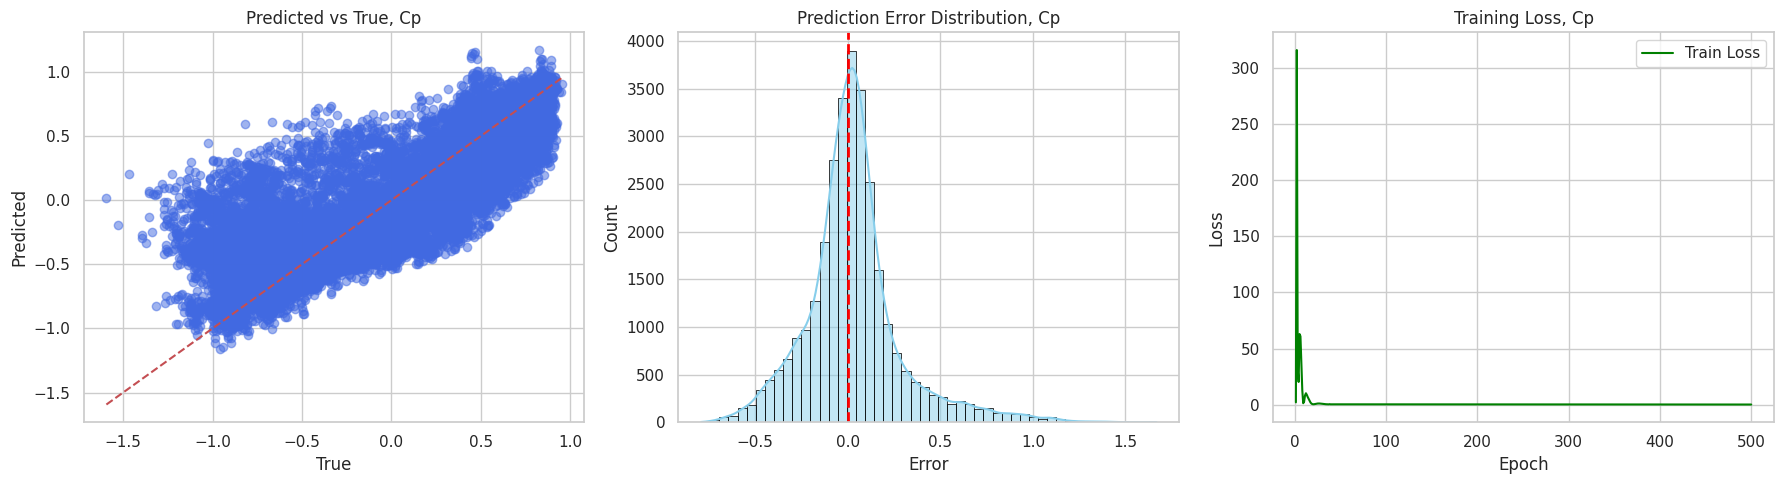

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 33/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 46/500 [00:00<00:02, 219.08it/s]

Epoch [10/500], Loss: 3.5055
Epoch [20/500], Loss: 3.1576
Epoch [30/500], Loss: 0.9392
Epoch [40/500], Loss: 0.3741
Epoch [50/500], Loss: 0.2183


Epochs:  18%|█▊        | 90/500 [00:00<00:01, 219.09it/s]

Epoch [60/500], Loss: 0.2216
Epoch [70/500], Loss: 0.2200
Epoch [80/500], Loss: 0.2114
Epoch [90/500], Loss: 0.2072
Epoch [100/500], Loss: 0.2050


Epochs:  27%|██▋       | 134/500 [00:00<00:01, 219.07it/s]

Epoch [110/500], Loss: 0.2031
Epoch [120/500], Loss: 0.2001
Epoch [130/500], Loss: 0.1956
Epoch [140/500], Loss: 0.1925
Epoch [150/500], Loss: 0.1898


Epochs:  40%|████      | 200/500 [00:00<00:01, 219.33it/s]

Epoch [160/500], Loss: 0.1864
Epoch [170/500], Loss: 0.1709
Epoch [180/500], Loss: 0.1381
Epoch [190/500], Loss: 0.1227
Epoch [200/500], Loss: 0.1127


Epochs:  49%|████▉     | 244/500 [00:01<00:01, 219.13it/s]

Epoch [210/500], Loss: 0.1071
Epoch [220/500], Loss: 0.1051
Epoch [230/500], Loss: 0.1033
Epoch [240/500], Loss: 0.1011
Epoch [250/500], Loss: 0.0999


Epochs:  58%|█████▊    | 288/500 [00:01<00:00, 219.02it/s]

Epoch [260/500], Loss: 0.1001
Epoch [270/500], Loss: 0.0986
Epoch [280/500], Loss: 0.0974
Epoch [290/500], Loss: 0.0968
Epoch [300/500], Loss: 0.0962


Epochs:  66%|██████▋   | 332/500 [00:01<00:00, 219.18it/s]

Epoch [310/500], Loss: 0.0955
Epoch [320/500], Loss: 0.0954
Epoch [330/500], Loss: 0.0948
Epoch [340/500], Loss: 0.0941
Epoch [350/500], Loss: 0.0938


Epochs:  80%|███████▉  | 399/500 [00:01<00:00, 218.98it/s]

Epoch [360/500], Loss: 0.0936
Epoch [370/500], Loss: 0.0928
Epoch [380/500], Loss: 0.0926
Epoch [390/500], Loss: 0.0927
Epoch [400/500], Loss: 0.0918


Epochs:  89%|████████▊ | 443/500 [00:02<00:00, 218.82it/s]

Epoch [410/500], Loss: 0.0914
Epoch [420/500], Loss: 0.0910
Epoch [430/500], Loss: 0.0946
Epoch [440/500], Loss: 0.0915
Epoch [450/500], Loss: 0.0907


Epochs: 100%|██████████| 500/500 [00:02<00:00, 219.03it/s]

Epoch [460/500], Loss: 0.0900
Epoch [470/500], Loss: 0.0895
Epoch [480/500], Loss: 0.0892
Epoch [490/500], Loss: 0.0889
Epoch [500/500], Loss: 0.0886
📈 Evaluation metrics on test set:
MSE: 0.0875
MAE: 0.2084
R2: 0.6477



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


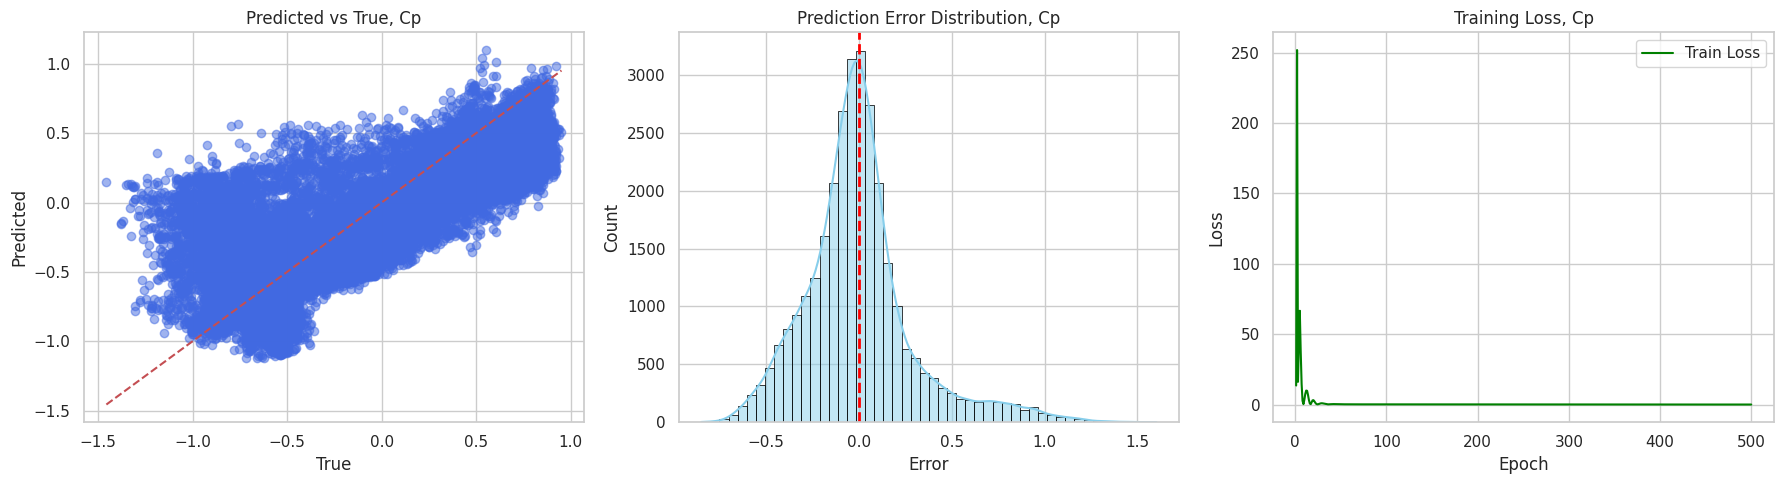

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 34/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 46/500 [00:00<00:02, 220.63it/s]

Epoch [10/500], Loss: 0.2899
Epoch [20/500], Loss: 2.0489
Epoch [30/500], Loss: 1.2311
Epoch [40/500], Loss: 0.4240
Epoch [50/500], Loss: 0.2414


Epochs:  18%|█▊        | 91/500 [00:00<00:01, 218.76it/s]

Epoch [60/500], Loss: 0.2223
Epoch [70/500], Loss: 0.2198
Epoch [80/500], Loss: 0.2040
Epoch [90/500], Loss: 0.2088
Epoch [100/500], Loss: 0.2041


Epochs:  27%|██▋       | 135/500 [00:00<00:01, 218.15it/s]

Epoch [110/500], Loss: 0.2013
Epoch [120/500], Loss: 0.1982
Epoch [130/500], Loss: 0.1959
Epoch [140/500], Loss: 0.1635
Epoch [150/500], Loss: 0.1487


Epochs:  40%|████      | 201/500 [00:00<00:01, 218.75it/s]

Epoch [160/500], Loss: 0.1423
Epoch [170/500], Loss: 0.1355
Epoch [180/500], Loss: 0.1298
Epoch [190/500], Loss: 0.1229
Epoch [200/500], Loss: 0.1164


Epochs:  49%|████▉     | 245/500 [00:01<00:01, 218.98it/s]

Epoch [210/500], Loss: 0.1111
Epoch [220/500], Loss: 0.1065
Epoch [230/500], Loss: 0.1025
Epoch [240/500], Loss: 0.0991
Epoch [250/500], Loss: 0.0967


Epochs:  58%|█████▊    | 289/500 [00:01<00:00, 218.99it/s]

Epoch [260/500], Loss: 0.0938
Epoch [270/500], Loss: 0.0923
Epoch [280/500], Loss: 0.0905
Epoch [290/500], Loss: 0.0889
Epoch [300/500], Loss: 0.0894


Epochs:  67%|██████▋   | 333/500 [00:01<00:00, 218.83it/s]

Epoch [310/500], Loss: 0.0867
Epoch [320/500], Loss: 0.0859
Epoch [330/500], Loss: 0.0851
Epoch [340/500], Loss: 0.0843
Epoch [350/500], Loss: 0.0837


Epochs:  80%|███████▉  | 399/500 [00:01<00:00, 218.97it/s]

Epoch [360/500], Loss: 0.0834
Epoch [370/500], Loss: 0.0828
Epoch [380/500], Loss: 0.0823
Epoch [390/500], Loss: 0.0817
Epoch [400/500], Loss: 0.0812


Epochs:  89%|████████▊ | 443/500 [00:02<00:00, 219.00it/s]

Epoch [410/500], Loss: 0.0807
Epoch [420/500], Loss: 0.0804
Epoch [430/500], Loss: 0.0800
Epoch [440/500], Loss: 0.0795
Epoch [450/500], Loss: 0.0792


Epochs: 100%|██████████| 500/500 [00:02<00:00, 218.92it/s]

Epoch [460/500], Loss: 0.0789
Epoch [470/500], Loss: 0.0786
Epoch [480/500], Loss: 0.0782
Epoch [490/500], Loss: 0.0779
Epoch [500/500], Loss: 0.0777
📈 Evaluation metrics on test set:
MSE: 0.0766
MAE: 0.1980
R2: 0.6872



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


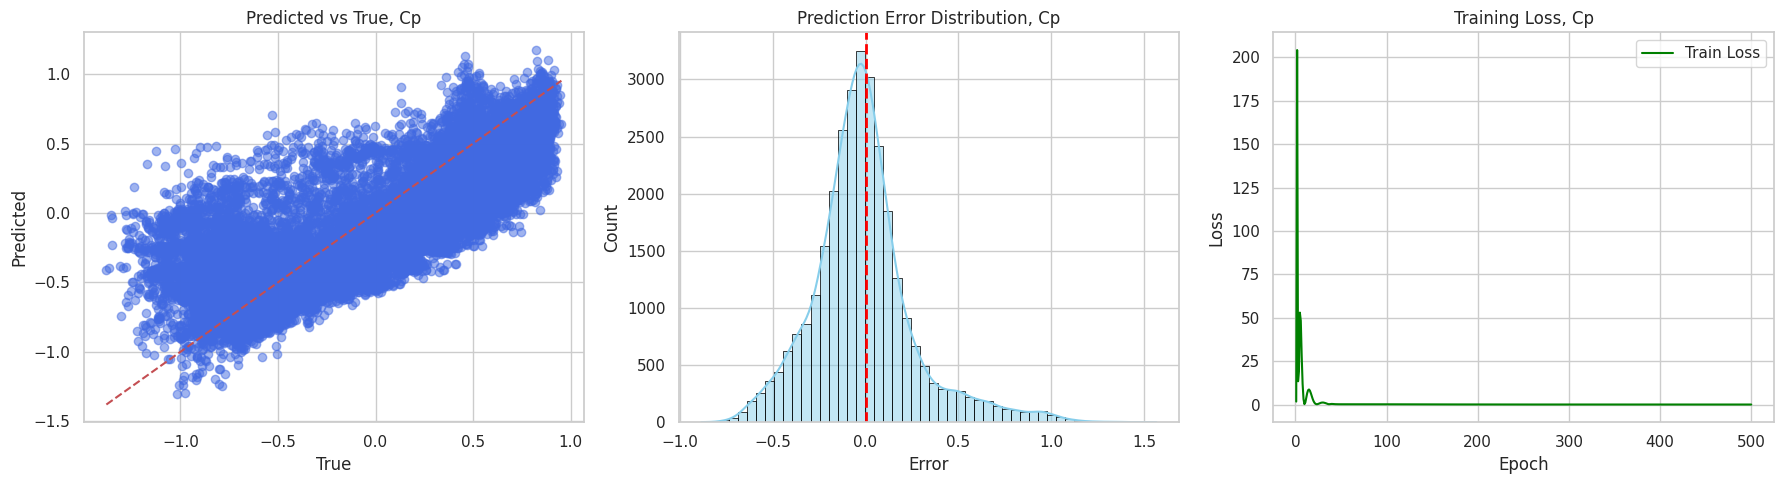

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 35/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   8%|▊         | 40/500 [00:00<00:02, 180.93it/s]

Epoch [10/500], Loss: 0.4827
Epoch [20/500], Loss: 0.2481
Epoch [30/500], Loss: 0.3639
Epoch [40/500], Loss: 0.2275


Epochs:  17%|█▋        | 83/500 [00:00<00:02, 203.29it/s]

Epoch [50/500], Loss: 0.2197
Epoch [60/500], Loss: 0.2032
Epoch [70/500], Loss: 0.1980
Epoch [80/500], Loss: 0.1926
Epoch [90/500], Loss: 0.1874


Epochs:  25%|██▌       | 127/500 [00:00<00:01, 211.97it/s]

Epoch [100/500], Loss: 0.1821
Epoch [110/500], Loss: 0.1768
Epoch [120/500], Loss: 0.1713
Epoch [130/500], Loss: 0.1658
Epoch [140/500], Loss: 0.1601


Epochs:  39%|███▊      | 193/500 [00:00<00:01, 216.37it/s]

Epoch [150/500], Loss: 0.1540
Epoch [160/500], Loss: 0.1471
Epoch [170/500], Loss: 0.1395
Epoch [180/500], Loss: 0.1323
Epoch [190/500], Loss: 0.1238


Epochs:  47%|████▋     | 237/500 [00:01<00:01, 217.46it/s]

Epoch [200/500], Loss: 0.1213
Epoch [210/500], Loss: 0.1146
Epoch [220/500], Loss: 0.1115
Epoch [230/500], Loss: 0.1116
Epoch [240/500], Loss: 0.1106


Epochs:  56%|█████▌    | 281/500 [00:01<00:01, 217.96it/s]

Epoch [250/500], Loss: 0.1075
Epoch [260/500], Loss: 0.1035
Epoch [270/500], Loss: 0.1026
Epoch [280/500], Loss: 0.1081
Epoch [290/500], Loss: 0.1004


Epochs:  65%|██████▌   | 325/500 [00:01<00:00, 218.13it/s]

Epoch [300/500], Loss: 0.1008
Epoch [310/500], Loss: 0.0993
Epoch [320/500], Loss: 0.0975
Epoch [330/500], Loss: 0.0969
Epoch [340/500], Loss: 0.0980


Epochs:  78%|███████▊  | 391/500 [00:01<00:00, 218.08it/s]

Epoch [350/500], Loss: 0.0952
Epoch [360/500], Loss: 0.0949
Epoch [370/500], Loss: 0.0945
Epoch [380/500], Loss: 0.0932
Epoch [390/500], Loss: 0.0978


Epochs:  87%|████████▋ | 435/500 [00:02<00:00, 218.29it/s]

Epoch [400/500], Loss: 0.0917
Epoch [410/500], Loss: 0.0901
Epoch [420/500], Loss: 0.0879
Epoch [430/500], Loss: 0.0866
Epoch [440/500], Loss: 0.0852


Epochs:  96%|█████████▌| 479/500 [00:02<00:00, 218.42it/s]

Epoch [450/500], Loss: 0.0866
Epoch [460/500], Loss: 0.0821
Epoch [470/500], Loss: 0.0803
Epoch [480/500], Loss: 0.0818
Epoch [490/500], Loss: 0.0791


Epochs: 100%|██████████| 500/500 [00:02<00:00, 214.56it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0786
📈 Evaluation metrics on test set:
MSE: 0.0872
MAE: 0.1989
R2: 0.6505


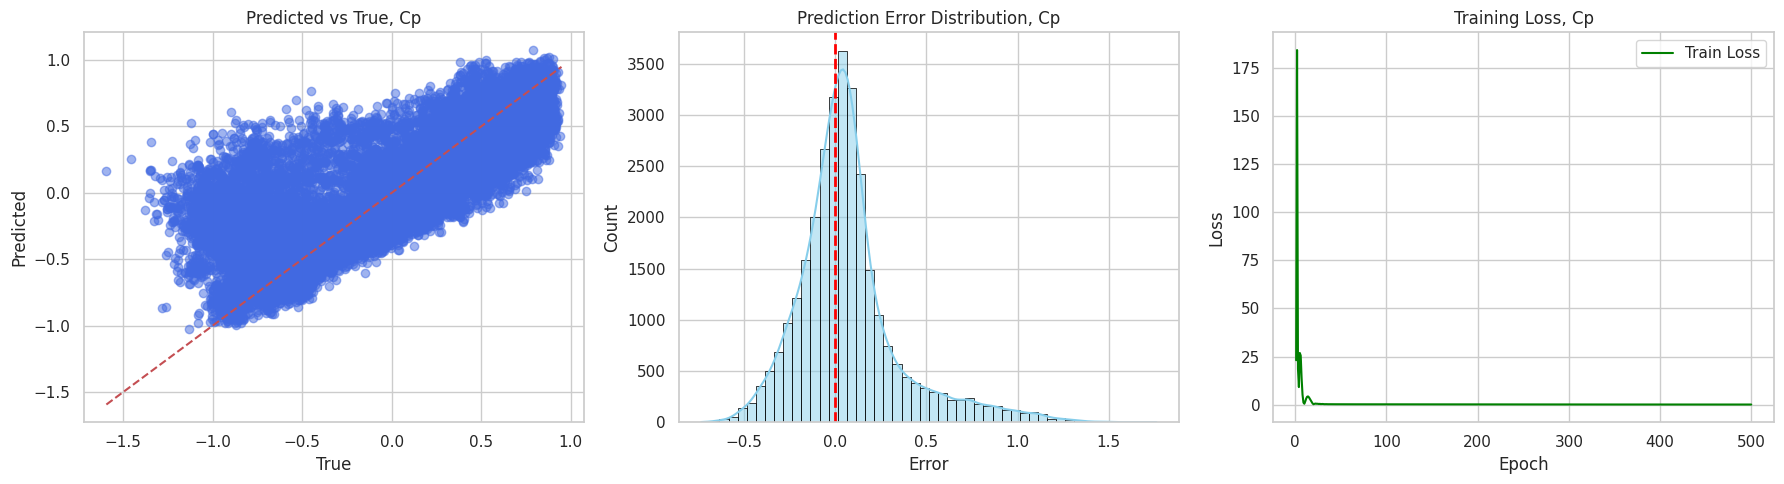

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 36/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   7%|▋         | 35/500 [00:00<00:02, 170.19it/s]

Epoch [10/500], Loss: 21.5895
Epoch [20/500], Loss: 4.7405
Epoch [30/500], Loss: 0.2497
Epoch [40/500], Loss: 0.2242


Epochs:  16%|█▌        | 79/500 [00:00<00:02, 198.90it/s]

Epoch [50/500], Loss: 0.2123
Epoch [60/500], Loss: 0.2050
Epoch [70/500], Loss: 0.2000
Epoch [80/500], Loss: 0.1959
Epoch [90/500], Loss: 0.1922


Epochs:  25%|██▍       | 123/500 [00:00<00:01, 209.99it/s]

Epoch [100/500], Loss: 0.1885
Epoch [110/500], Loss: 0.1841
Epoch [120/500], Loss: 0.1759
Epoch [130/500], Loss: 0.1602
Epoch [140/500], Loss: 0.1462


Epochs:  38%|███▊      | 189/500 [00:00<00:01, 215.78it/s]

Epoch [150/500], Loss: 0.1346
Epoch [160/500], Loss: 0.1272
Epoch [170/500], Loss: 0.1368
Epoch [180/500], Loss: 0.1188
Epoch [190/500], Loss: 0.1154


Epochs:  47%|████▋     | 233/500 [00:01<00:01, 217.22it/s]

Epoch [200/500], Loss: 0.1132
Epoch [210/500], Loss: 0.1104
Epoch [220/500], Loss: 0.1098
Epoch [230/500], Loss: 0.1146
Epoch [240/500], Loss: 0.1075


Epochs:  55%|█████▌    | 277/500 [00:01<00:01, 217.84it/s]

Epoch [250/500], Loss: 0.1037
Epoch [260/500], Loss: 0.1024
Epoch [270/500], Loss: 0.1015
Epoch [280/500], Loss: 0.1004
Epoch [290/500], Loss: 0.0995


Epochs:  69%|██████▊   | 343/500 [00:01<00:00, 218.02it/s]

Epoch [300/500], Loss: 0.0986
Epoch [310/500], Loss: 0.0977
Epoch [320/500], Loss: 0.0969
Epoch [330/500], Loss: 0.0989
Epoch [340/500], Loss: 0.0969


Epochs:  77%|███████▋  | 387/500 [00:01<00:00, 217.92it/s]

Epoch [350/500], Loss: 0.0952
Epoch [360/500], Loss: 0.0943
Epoch [370/500], Loss: 0.0937
Epoch [380/500], Loss: 0.0933
Epoch [390/500], Loss: 0.0925


Epochs:  86%|████████▌ | 431/500 [00:02<00:00, 218.14it/s]

Epoch [400/500], Loss: 0.1733
Epoch [410/500], Loss: 0.1122
Epoch [420/500], Loss: 0.0942
Epoch [430/500], Loss: 0.0881
Epoch [440/500], Loss: 0.0864


Epochs:  95%|█████████▌| 475/500 [00:02<00:00, 217.52it/s]

Epoch [450/500], Loss: 0.0852
Epoch [460/500], Loss: 0.0841
Epoch [470/500], Loss: 0.0833
Epoch [480/500], Loss: 0.0825
Epoch [490/500], Loss: 0.0818


Epochs: 100%|██████████| 500/500 [00:02<00:00, 213.06it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0811
📈 Evaluation metrics on test set:
MSE: 0.0820
MAE: 0.2030
R2: 0.6706


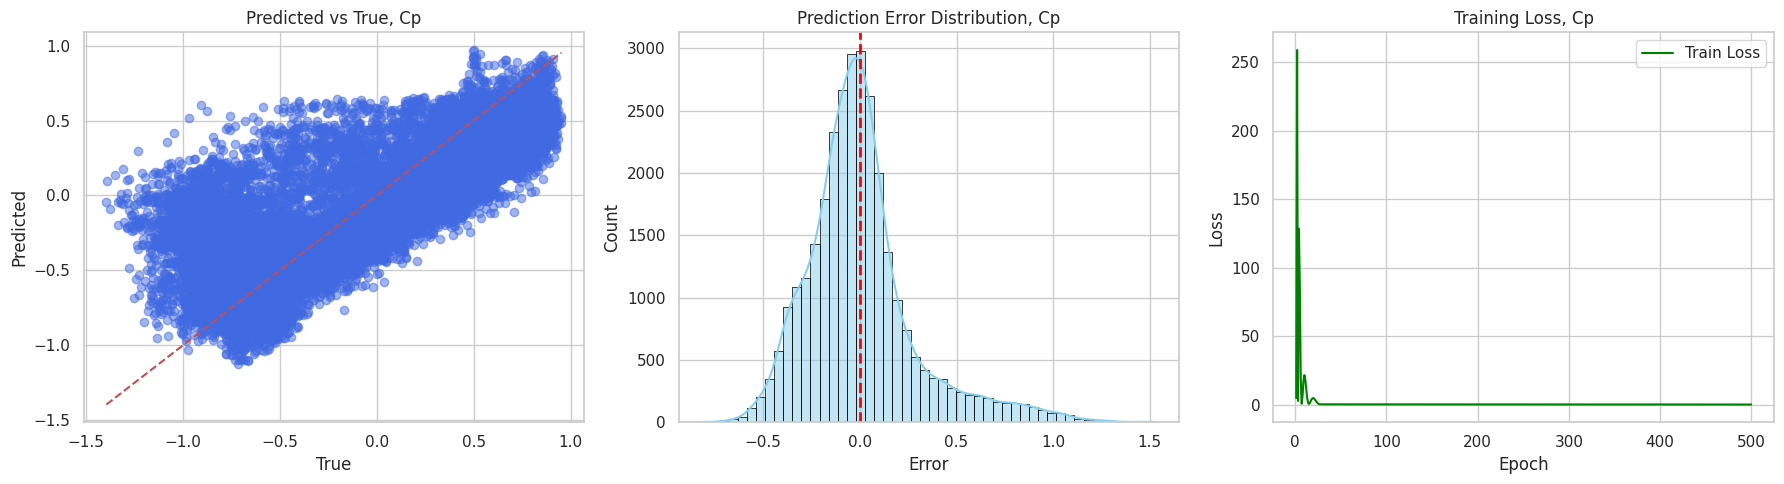

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 37/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   8%|▊         | 42/500 [00:00<00:02, 193.75it/s]

Epoch [10/500], Loss: 8.3362
Epoch [20/500], Loss: 1.0273
Epoch [30/500], Loss: 0.4661
Epoch [40/500], Loss: 0.2692


Epochs:  17%|█▋        | 85/500 [00:00<00:02, 206.89it/s]

Epoch [50/500], Loss: 0.2211
Epoch [60/500], Loss: 0.2091
Epoch [70/500], Loss: 0.2041
Epoch [80/500], Loss: 0.2208
Epoch [90/500], Loss: 0.2021


Epochs:  26%|██▌       | 129/500 [00:00<00:01, 213.78it/s]

Epoch [100/500], Loss: 0.1919
Epoch [110/500], Loss: 0.1868
Epoch [120/500], Loss: 0.1820
Epoch [130/500], Loss: 0.1773
Epoch [140/500], Loss: 0.1724


Epochs:  35%|███▍      | 173/500 [00:00<00:01, 216.48it/s]

Epoch [150/500], Loss: 0.1674
Epoch [160/500], Loss: 0.1569
Epoch [170/500], Loss: 0.1284
Epoch [180/500], Loss: 0.1192
Epoch [190/500], Loss: 0.1112


Epochs:  48%|████▊     | 239/500 [00:01<00:01, 218.15it/s]

Epoch [200/500], Loss: 0.1055
Epoch [210/500], Loss: 0.0997
Epoch [220/500], Loss: 0.0985
Epoch [230/500], Loss: 0.0931
Epoch [240/500], Loss: 0.0874


Epochs:  57%|█████▋    | 283/500 [00:01<00:00, 218.33it/s]

Epoch [250/500], Loss: 0.0833
Epoch [260/500], Loss: 0.1099
Epoch [270/500], Loss: 0.0893
Epoch [280/500], Loss: 0.0819
Epoch [290/500], Loss: 0.0792


Epochs:  65%|██████▌   | 327/500 [00:01<00:00, 218.69it/s]

Epoch [300/500], Loss: 0.0786
Epoch [310/500], Loss: 0.0773
Epoch [320/500], Loss: 0.0768
Epoch [330/500], Loss: 0.0761
Epoch [340/500], Loss: 0.0754


Epochs:  79%|███████▊  | 393/500 [00:01<00:00, 218.09it/s]

Epoch [350/500], Loss: 0.0749
Epoch [360/500], Loss: 0.0897
Epoch [370/500], Loss: 0.0772
Epoch [380/500], Loss: 0.0757
Epoch [390/500], Loss: 0.0738


Epochs:  87%|████████▋ | 437/500 [00:02<00:00, 218.04it/s]

Epoch [400/500], Loss: 0.0732
Epoch [410/500], Loss: 0.0726
Epoch [420/500], Loss: 0.0749
Epoch [430/500], Loss: 0.0728
Epoch [440/500], Loss: 0.0721


Epochs:  96%|█████████▌| 481/500 [00:02<00:00, 217.93it/s]

Epoch [450/500], Loss: 0.0717
Epoch [460/500], Loss: 0.0779
Epoch [470/500], Loss: 0.0710
Epoch [480/500], Loss: 0.0708
Epoch [490/500], Loss: 0.0708


Epochs: 100%|██████████| 500/500 [00:02<00:00, 215.74it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0694
📈 Evaluation metrics on test set:
MSE: 0.0709
MAE: 0.1827
R2: 0.7165


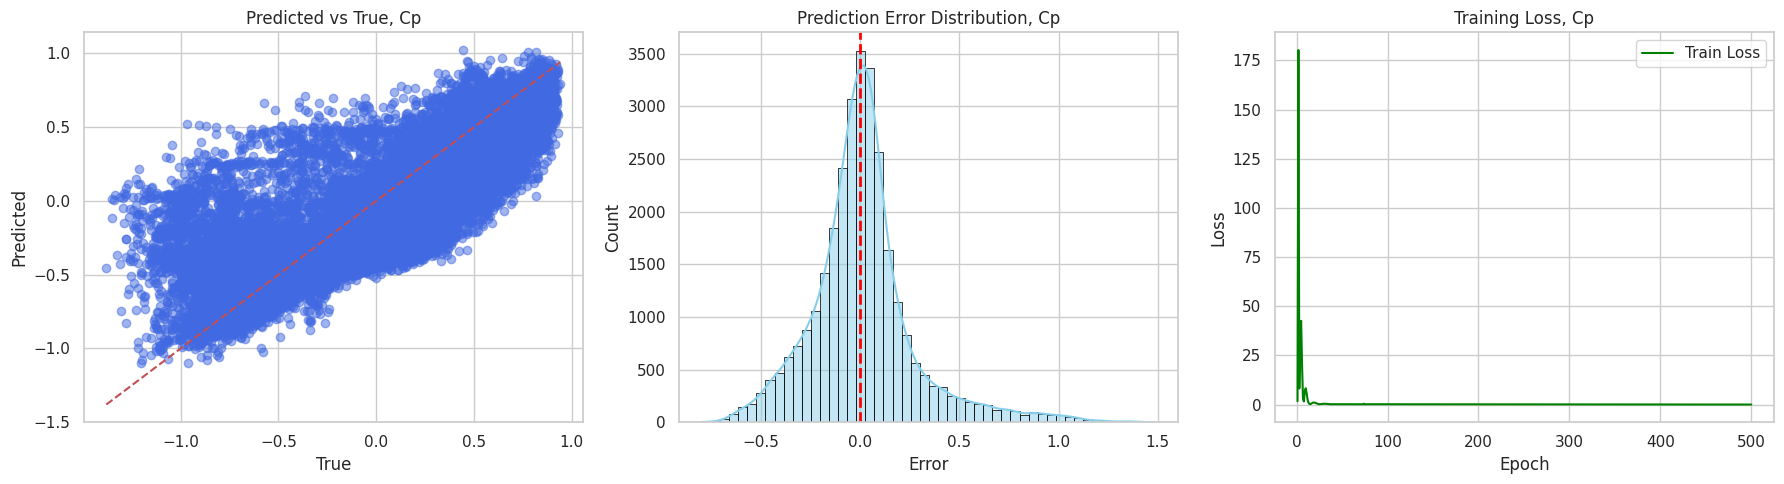

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 38/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   7%|▋         | 35/500 [00:00<00:02, 170.52it/s]

Epoch [10/500], Loss: 0.4114
Epoch [20/500], Loss: 0.2366
Epoch [30/500], Loss: 0.2639
Epoch [40/500], Loss: 0.2488


Epochs:  15%|█▌        | 75/500 [00:00<00:02, 188.73it/s]

Epoch [50/500], Loss: 0.1558
Epoch [60/500], Loss: 0.1467
Epoch [70/500], Loss: 0.1294
Epoch [80/500], Loss: 0.1152
Epoch [90/500], Loss: 0.1081


Epochs:  28%|██▊       | 141/500 [00:00<00:01, 210.05it/s]

Epoch [100/500], Loss: 0.1053
Epoch [110/500], Loss: 0.1086
Epoch [120/500], Loss: 0.0986
Epoch [130/500], Loss: 0.0963
Epoch [140/500], Loss: 0.0931


Epochs:  37%|███▋      | 185/500 [00:00<00:01, 214.53it/s]

Epoch [150/500], Loss: 0.0930
Epoch [160/500], Loss: 0.0938
Epoch [170/500], Loss: 0.0854
Epoch [180/500], Loss: 0.0846
Epoch [190/500], Loss: 0.0817


Epochs:  46%|████▌     | 229/500 [00:01<00:01, 216.35it/s]

Epoch [200/500], Loss: 0.0819
Epoch [210/500], Loss: 0.0802
Epoch [220/500], Loss: 0.0791
Epoch [230/500], Loss: 0.0786
Epoch [240/500], Loss: 0.0801


Epochs:  55%|█████▍    | 273/500 [00:01<00:01, 217.16it/s]

Epoch [250/500], Loss: 0.0818
Epoch [260/500], Loss: 0.0792
Epoch [270/500], Loss: 0.0754
Epoch [280/500], Loss: 0.0762
Epoch [290/500], Loss: 0.0798


Epochs:  68%|██████▊   | 339/500 [00:01<00:00, 217.54it/s]

Epoch [300/500], Loss: 0.0752
Epoch [310/500], Loss: 0.0730
Epoch [320/500], Loss: 0.0789
Epoch [330/500], Loss: 0.0749
Epoch [340/500], Loss: 0.0720


Epochs:  77%|███████▋  | 383/500 [00:01<00:00, 217.63it/s]

Epoch [350/500], Loss: 0.0788
Epoch [360/500], Loss: 0.0738
Epoch [370/500], Loss: 0.0721
Epoch [380/500], Loss: 0.0707
Epoch [390/500], Loss: 0.0725


Epochs:  85%|████████▌ | 427/500 [00:02<00:00, 217.68it/s]

Epoch [400/500], Loss: 0.0704
Epoch [410/500], Loss: 0.0711
Epoch [420/500], Loss: 0.0710
Epoch [430/500], Loss: 0.0698
Epoch [440/500], Loss: 0.0696


Epochs:  99%|█████████▊| 493/500 [00:02<00:00, 217.55it/s]

Epoch [450/500], Loss: 0.0691
Epoch [460/500], Loss: 0.0702
Epoch [470/500], Loss: 0.0748
Epoch [480/500], Loss: 0.0694
Epoch [490/500], Loss: 0.0684


Epochs: 100%|██████████| 500/500 [00:02<00:00, 211.59it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0695
📈 Evaluation metrics on test set:
MSE: 0.0694
MAE: 0.1795
R2: 0.7204


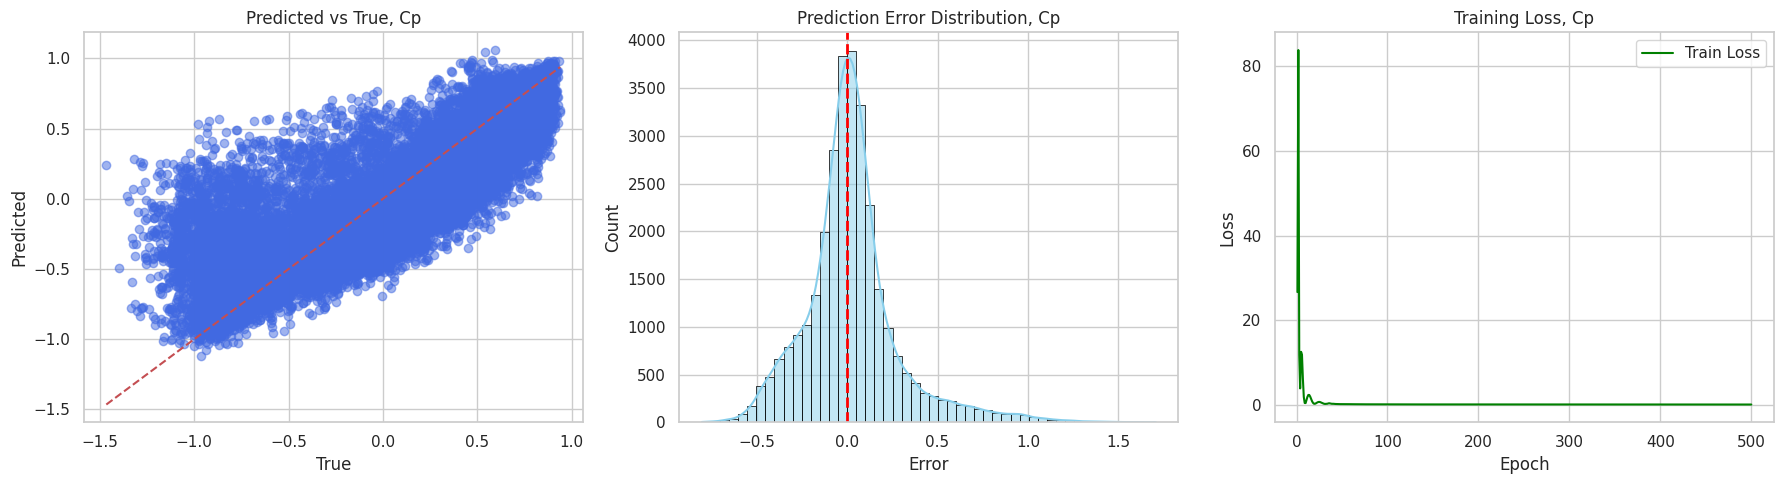

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 39/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   7%|▋         | 34/500 [00:00<00:02, 166.35it/s]

Epoch [10/500], Loss: 5.4112
Epoch [20/500], Loss: 0.2888
Epoch [30/500], Loss: 0.9451
Epoch [40/500], Loss: 0.2354


Epochs:  16%|█▌        | 78/500 [00:00<00:02, 198.78it/s]

Epoch [50/500], Loss: 0.3546
Epoch [60/500], Loss: 0.2466
Epoch [70/500], Loss: 0.2180
Epoch [80/500], Loss: 0.2105
Epoch [90/500], Loss: 0.2080


Epochs:  24%|██▍       | 122/500 [00:00<00:01, 210.05it/s]

Epoch [100/500], Loss: 0.2041
Epoch [110/500], Loss: 0.1996
Epoch [120/500], Loss: 0.1958
Epoch [130/500], Loss: 0.1923
Epoch [140/500], Loss: 0.1894


Epochs:  38%|███▊      | 188/500 [00:00<00:01, 215.35it/s]

Epoch [150/500], Loss: 0.1864
Epoch [160/500], Loss: 0.1572
Epoch [170/500], Loss: 0.1253
Epoch [180/500], Loss: 0.1136
Epoch [190/500], Loss: 0.1070


Epochs:  46%|████▋     | 232/500 [00:01<00:01, 216.70it/s]

Epoch [200/500], Loss: 0.1026
Epoch [210/500], Loss: 0.0979
Epoch [220/500], Loss: 0.0951
Epoch [230/500], Loss: 0.0935
Epoch [240/500], Loss: 0.0917


Epochs:  55%|█████▌    | 276/500 [00:01<00:01, 217.46it/s]

Epoch [250/500], Loss: 0.0921
Epoch [260/500], Loss: 0.0889
Epoch [270/500], Loss: 0.0873
Epoch [280/500], Loss: 0.0861
Epoch [290/500], Loss: 0.0849


Epochs:  68%|██████▊   | 342/500 [00:01<00:00, 217.96it/s]

Epoch [300/500], Loss: 0.0836
Epoch [310/500], Loss: 0.0823
Epoch [320/500], Loss: 0.0810
Epoch [330/500], Loss: 0.0796
Epoch [340/500], Loss: 0.0783


Epochs:  77%|███████▋  | 386/500 [00:01<00:00, 216.73it/s]

Epoch [350/500], Loss: 0.0773
Epoch [360/500], Loss: 0.0765
Epoch [370/500], Loss: 0.0757
Epoch [380/500], Loss: 0.0748
Epoch [390/500], Loss: 0.0741


Epochs:  86%|████████▌ | 430/500 [00:02<00:00, 215.38it/s]

Epoch [400/500], Loss: 0.0735
Epoch [410/500], Loss: 0.0732
Epoch [420/500], Loss: 0.0724
Epoch [430/500], Loss: 0.0718
Epoch [440/500], Loss: 0.0712


Epochs:  95%|█████████▍| 474/500 [00:02<00:00, 214.95it/s]

Epoch [450/500], Loss: 0.0705
Epoch [460/500], Loss: 0.0697
Epoch [470/500], Loss: 0.0689
Epoch [480/500], Loss: 0.0681
Epoch [490/500], Loss: 0.0670


Epochs: 100%|██████████| 500/500 [00:02<00:00, 212.16it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0656
📈 Evaluation metrics on test set:
MSE: 0.0664
MAE: 0.1803
R2: 0.7317


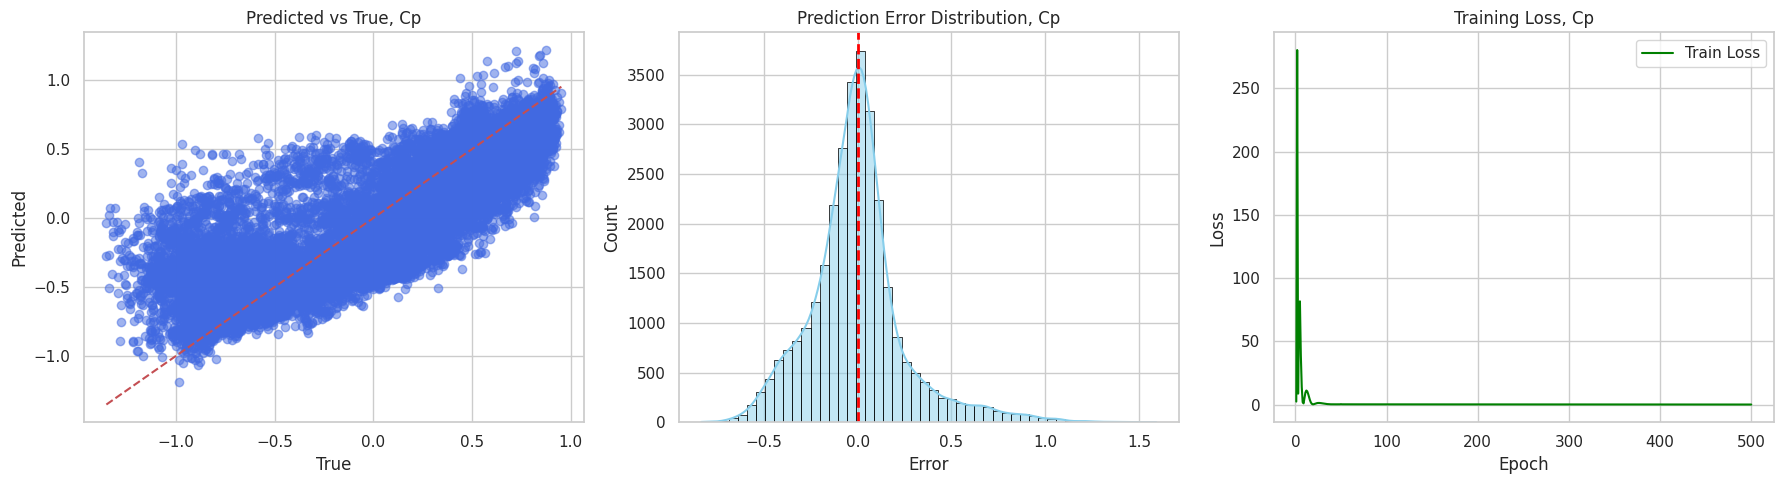

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 40/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   8%|▊         | 39/500 [00:00<00:02, 178.43it/s]

Epoch [10/500], Loss: 0.7721
Epoch [20/500], Loss: 0.2809
Epoch [30/500], Loss: 1.1029
Epoch [40/500], Loss: 0.3290


Epochs:  16%|█▋        | 82/500 [00:00<00:02, 202.26it/s]

Epoch [50/500], Loss: 0.2189
Epoch [60/500], Loss: 0.2154
Epoch [70/500], Loss: 0.2097
Epoch [80/500], Loss: 0.1887
Epoch [90/500], Loss: 0.1746


Epochs:  25%|██▌       | 126/500 [00:00<00:01, 211.91it/s]

Epoch [100/500], Loss: 0.1664
Epoch [110/500], Loss: 0.1575
Epoch [120/500], Loss: 0.1463
Epoch [130/500], Loss: 0.1304
Epoch [140/500], Loss: 0.1197


Epochs:  38%|███▊      | 192/500 [00:00<00:01, 216.71it/s]

Epoch [150/500], Loss: 0.1130
Epoch [160/500], Loss: 0.1070
Epoch [170/500], Loss: 0.1032
Epoch [180/500], Loss: 0.1007
Epoch [190/500], Loss: 0.0984


Epochs:  47%|████▋     | 236/500 [00:01<00:01, 217.35it/s]

Epoch [200/500], Loss: 0.0971
Epoch [210/500], Loss: 0.0951
Epoch [220/500], Loss: 0.0931
Epoch [230/500], Loss: 0.0931
Epoch [240/500], Loss: 0.0907


Epochs:  56%|█████▌    | 280/500 [00:01<00:01, 218.21it/s]

Epoch [250/500], Loss: 0.0886
Epoch [260/500], Loss: 0.0878
Epoch [270/500], Loss: 0.0858
Epoch [280/500], Loss: 0.0841
Epoch [290/500], Loss: 0.0829


Epochs:  65%|██████▍   | 324/500 [00:01<00:00, 217.94it/s]

Epoch [300/500], Loss: 0.0912
Epoch [310/500], Loss: 0.0808
Epoch [320/500], Loss: 0.0797
Epoch [330/500], Loss: 0.0785
Epoch [340/500], Loss: 0.0774


Epochs:  78%|███████▊  | 390/500 [00:01<00:00, 218.03it/s]

Epoch [350/500], Loss: 0.0766
Epoch [360/500], Loss: 0.0759
Epoch [370/500], Loss: 0.0752
Epoch [380/500], Loss: 0.0764
Epoch [390/500], Loss: 0.0757


Epochs:  87%|████████▋ | 434/500 [00:02<00:00, 218.08it/s]

Epoch [400/500], Loss: 0.0753
Epoch [410/500], Loss: 0.0741
Epoch [420/500], Loss: 0.0729
Epoch [430/500], Loss: 0.0729
Epoch [440/500], Loss: 0.0735


Epochs:  96%|█████████▌| 478/500 [00:02<00:00, 218.46it/s]

Epoch [450/500], Loss: 0.0712
Epoch [460/500], Loss: 0.0707
Epoch [470/500], Loss: 0.0702
Epoch [480/500], Loss: 0.0705
Epoch [490/500], Loss: 0.0697


Epochs: 100%|██████████| 500/500 [00:02<00:00, 214.42it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0692
📈 Evaluation metrics on test set:
MSE: 0.0688
MAE: 0.1881
R2: 0.7225


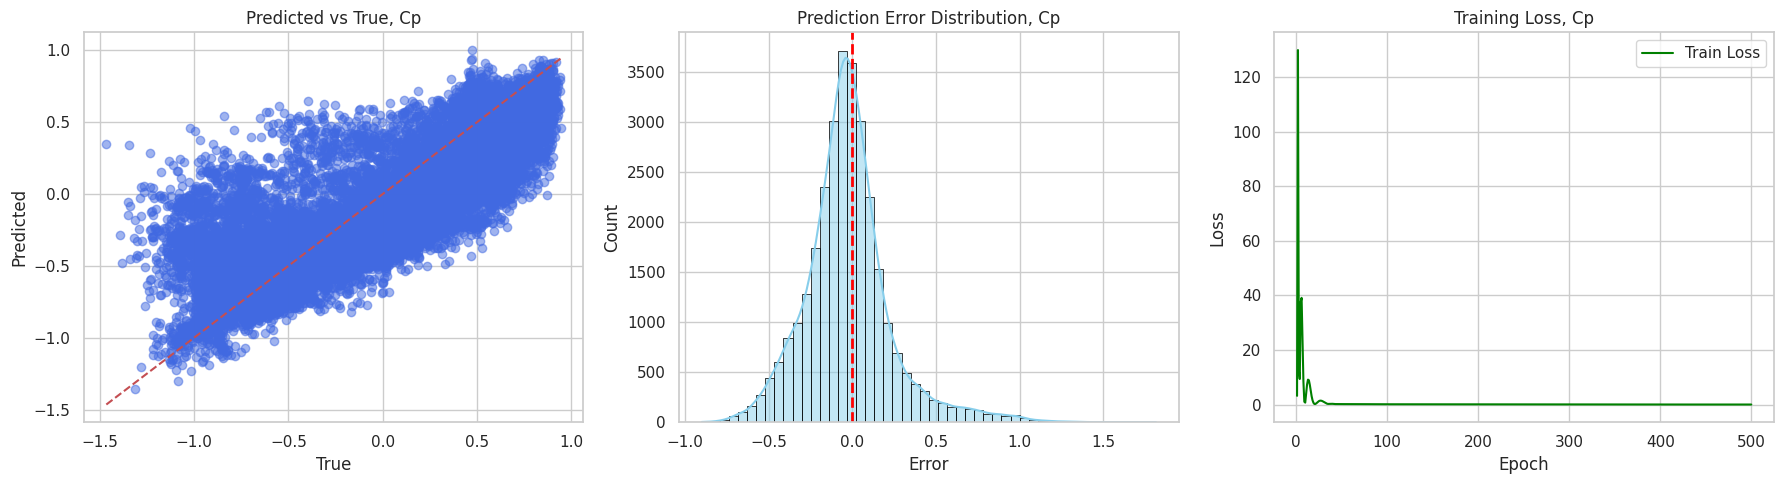

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 41/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 46/500 [00:00<00:02, 219.29it/s]

Epoch [10/500], Loss: 0.9911
Epoch [20/500], Loss: 2.1982
Epoch [30/500], Loss: 0.2953
Epoch [40/500], Loss: 0.3227
Epoch [50/500], Loss: 0.2382


Epochs:  18%|█▊        | 90/500 [00:00<00:01, 218.99it/s]

Epoch [60/500], Loss: 0.2226
Epoch [70/500], Loss: 0.2095
Epoch [80/500], Loss: 0.2033
Epoch [90/500], Loss: 0.1975
Epoch [100/500], Loss: 0.1948


Epochs:  27%|██▋       | 134/500 [00:00<00:01, 218.85it/s]

Epoch [110/500], Loss: 0.1916
Epoch [120/500], Loss: 0.1861
Epoch [130/500], Loss: 0.1759
Epoch [140/500], Loss: 0.1604
Epoch [150/500], Loss: 0.1424


Epochs:  40%|████      | 200/500 [00:00<00:01, 218.78it/s]

Epoch [160/500], Loss: 0.1279
Epoch [170/500], Loss: 0.1203
Epoch [180/500], Loss: 0.1120
Epoch [190/500], Loss: 0.1070
Epoch [200/500], Loss: 0.1040


Epochs:  49%|████▉     | 244/500 [00:01<00:01, 218.85it/s]

Epoch [210/500], Loss: 0.1018
Epoch [220/500], Loss: 0.1001
Epoch [230/500], Loss: 0.0976
Epoch [240/500], Loss: 0.0939
Epoch [250/500], Loss: 0.0911


Epochs:  58%|█████▊    | 288/500 [00:01<00:00, 218.58it/s]

Epoch [260/500], Loss: 0.0883
Epoch [270/500], Loss: 0.0875
Epoch [280/500], Loss: 0.0840
Epoch [290/500], Loss: 0.0824
Epoch [300/500], Loss: 0.0786


Epochs:  71%|███████   | 354/500 [00:01<00:00, 218.18it/s]

Epoch [310/500], Loss: 0.0776
Epoch [320/500], Loss: 0.0759
Epoch [330/500], Loss: 0.0747
Epoch [340/500], Loss: 0.0741
Epoch [350/500], Loss: 0.0725


Epochs:  80%|███████▉  | 398/500 [00:01<00:00, 218.18it/s]

Epoch [360/500], Loss: 0.0717
Epoch [370/500], Loss: 0.0710
Epoch [380/500], Loss: 0.0699
Epoch [390/500], Loss: 0.0775
Epoch [400/500], Loss: 0.0775


Epochs:  88%|████████▊ | 442/500 [00:02<00:00, 217.93it/s]

Epoch [410/500], Loss: 0.0723
Epoch [420/500], Loss: 0.0693
Epoch [430/500], Loss: 0.0681
Epoch [440/500], Loss: 0.0674
Epoch [450/500], Loss: 0.0666


Epochs: 100%|██████████| 500/500 [00:02<00:00, 218.37it/s]

Epoch [460/500], Loss: 0.0674
Epoch [470/500], Loss: 0.0747
Epoch [480/500], Loss: 0.0765
Epoch [490/500], Loss: 0.0705
Epoch [500/500], Loss: 0.0667
📈 Evaluation metrics on test set:
MSE: 0.0644
MAE: 0.1779
R2: 0.7374



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


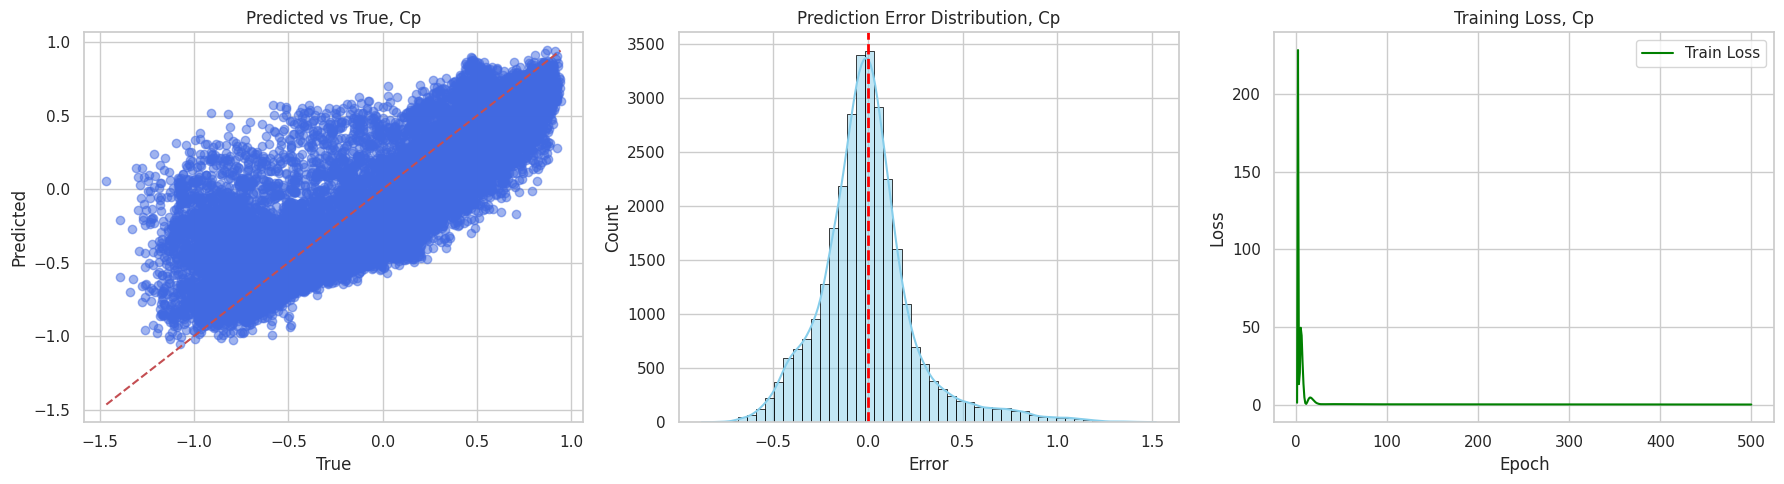

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 42/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 46/500 [00:00<00:02, 219.57it/s]

Epoch [10/500], Loss: 5.4798
Epoch [20/500], Loss: 1.0252
Epoch [30/500], Loss: 0.2638
Epoch [40/500], Loss: 0.2467
Epoch [50/500], Loss: 0.2371


Epochs:  18%|█▊        | 90/500 [00:00<00:01, 218.95it/s]

Epoch [60/500], Loss: 0.2171
Epoch [70/500], Loss: 0.2098
Epoch [80/500], Loss: 0.2071
Epoch [90/500], Loss: 0.2025
Epoch [100/500], Loss: 0.1957


Epochs:  27%|██▋       | 134/500 [00:00<00:01, 218.88it/s]

Epoch [110/500], Loss: 0.1855
Epoch [120/500], Loss: 0.1767
Epoch [130/500], Loss: 0.1698
Epoch [140/500], Loss: 0.1633
Epoch [150/500], Loss: 0.1510


Epochs:  40%|████      | 200/500 [00:00<00:01, 218.29it/s]

Epoch [160/500], Loss: 0.1429
Epoch [170/500], Loss: 0.1381
Epoch [180/500], Loss: 0.1332
Epoch [190/500], Loss: 0.1283
Epoch [200/500], Loss: 0.1233


Epochs:  49%|████▉     | 244/500 [00:01<00:01, 218.11it/s]

Epoch [210/500], Loss: 0.1190
Epoch [220/500], Loss: 0.1156
Epoch [230/500], Loss: 0.1117
Epoch [240/500], Loss: 0.1073
Epoch [250/500], Loss: 0.1024


Epochs:  58%|█████▊    | 288/500 [00:01<00:00, 217.78it/s]

Epoch [260/500], Loss: 0.0975
Epoch [270/500], Loss: 0.0936
Epoch [280/500], Loss: 0.0903
Epoch [290/500], Loss: 0.0880
Epoch [300/500], Loss: 0.0860


Epochs:  66%|██████▋   | 332/500 [00:01<00:00, 217.95it/s]

Epoch [310/500], Loss: 0.0845
Epoch [320/500], Loss: 0.0831
Epoch [330/500], Loss: 0.0820
Epoch [340/500], Loss: 0.0812
Epoch [350/500], Loss: 0.0806


Epochs:  80%|███████▉  | 398/500 [00:01<00:00, 217.95it/s]

Epoch [360/500], Loss: 0.0794
Epoch [370/500], Loss: 0.0784
Epoch [380/500], Loss: 0.0775
Epoch [390/500], Loss: 0.0765
Epoch [400/500], Loss: 0.0761


Epochs:  88%|████████▊ | 442/500 [00:02<00:00, 217.64it/s]

Epoch [410/500], Loss: 0.0759
Epoch [420/500], Loss: 0.0742
Epoch [430/500], Loss: 0.0729
Epoch [440/500], Loss: 0.0719
Epoch [450/500], Loss: 0.0709


Epochs: 100%|██████████| 500/500 [00:02<00:00, 218.06it/s]

Epoch [460/500], Loss: 0.0713
Epoch [470/500], Loss: 0.0692
Epoch [480/500], Loss: 0.0689
Epoch [490/500], Loss: 0.0689
Epoch [500/500], Loss: 0.0673
📈 Evaluation metrics on test set:
MSE: 0.0677
MAE: 0.1862
R2: 0.7284



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


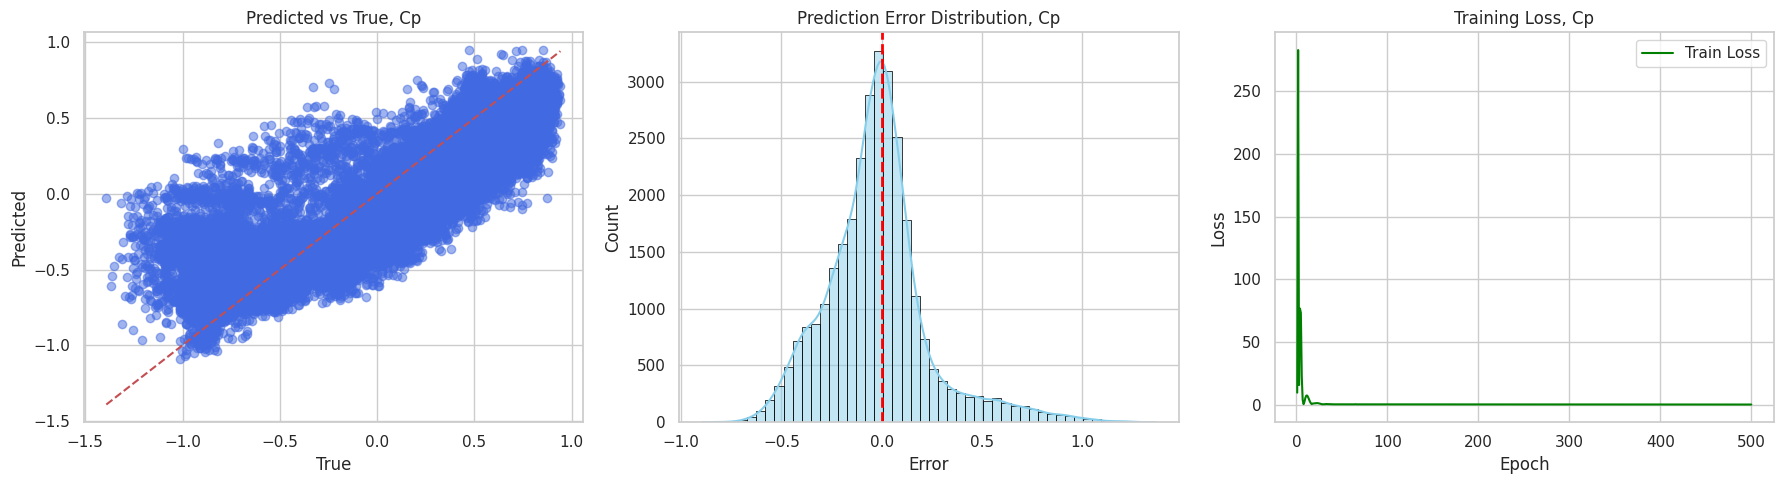

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 43/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 46/500 [00:00<00:02, 219.42it/s]

Epoch [10/500], Loss: 2.4344
Epoch [20/500], Loss: 0.2807
Epoch [30/500], Loss: 0.7453
Epoch [40/500], Loss: 0.2370
Epoch [50/500], Loss: 0.2287


Epochs:  18%|█▊        | 90/500 [00:00<00:01, 218.77it/s]

Epoch [60/500], Loss: 0.2033
Epoch [70/500], Loss: 0.2019
Epoch [80/500], Loss: 0.1937
Epoch [90/500], Loss: 0.1886
Epoch [100/500], Loss: 0.1994


Epochs:  27%|██▋       | 134/500 [00:00<00:01, 218.63it/s]

Epoch [110/500], Loss: 0.1945
Epoch [120/500], Loss: 0.1804
Epoch [130/500], Loss: 0.1717
Epoch [140/500], Loss: 0.1663
Epoch [150/500], Loss: 0.1611


Epochs:  40%|████      | 200/500 [00:00<00:01, 218.42it/s]

Epoch [160/500], Loss: 0.1570
Epoch [170/500], Loss: 0.1531
Epoch [180/500], Loss: 0.1493
Epoch [190/500], Loss: 0.1453
Epoch [200/500], Loss: 0.1412


Epochs:  49%|████▉     | 244/500 [00:01<00:01, 217.87it/s]

Epoch [210/500], Loss: 0.1373
Epoch [220/500], Loss: 0.1484
Epoch [230/500], Loss: 0.1422
Epoch [240/500], Loss: 0.1306
Epoch [250/500], Loss: 0.1280


Epochs:  58%|█████▊    | 288/500 [00:01<00:00, 218.08it/s]

Epoch [260/500], Loss: 0.1265
Epoch [270/500], Loss: 0.1241
Epoch [280/500], Loss: 0.1219
Epoch [290/500], Loss: 0.1249
Epoch [300/500], Loss: 0.1212


Epochs:  66%|██████▋   | 332/500 [00:01<00:00, 218.51it/s]

Epoch [310/500], Loss: 0.1197
Epoch [320/500], Loss: 0.1164
Epoch [330/500], Loss: 0.1146
Epoch [340/500], Loss: 0.1128
Epoch [350/500], Loss: 0.1175


Epochs:  80%|███████▉  | 398/500 [00:01<00:00, 217.69it/s]

Epoch [360/500], Loss: 0.1183
Epoch [370/500], Loss: 0.1169
Epoch [380/500], Loss: 0.1071
Epoch [390/500], Loss: 0.1075
Epoch [400/500], Loss: 0.1092


Epochs:  88%|████████▊ | 442/500 [00:02<00:00, 218.10it/s]

Epoch [410/500], Loss: 0.1058
Epoch [420/500], Loss: 0.1101
Epoch [430/500], Loss: 0.1093
Epoch [440/500], Loss: 0.1012
Epoch [450/500], Loss: 0.1002


Epochs: 100%|██████████| 500/500 [00:02<00:00, 218.20it/s]

Epoch [460/500], Loss: 0.0999
Epoch [470/500], Loss: 0.1108
Epoch [480/500], Loss: 0.0986
Epoch [490/500], Loss: 0.0995
Epoch [500/500], Loss: 0.0979
📈 Evaluation metrics on test set:
MSE: 0.0959
MAE: 0.2277
R2: 0.6104



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


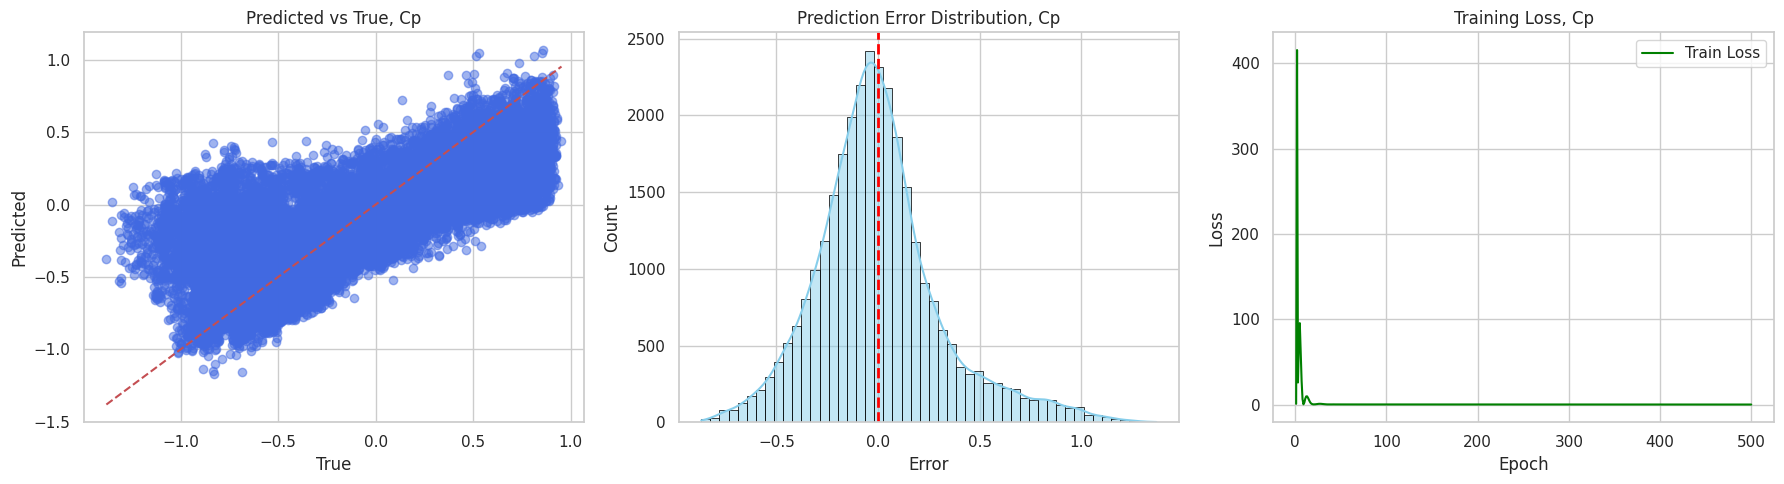

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 44/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 46/500 [00:00<00:02, 219.46it/s]

Epoch [10/500], Loss: 1.7684
Epoch [20/500], Loss: 0.5094
Epoch [30/500], Loss: 0.2907
Epoch [40/500], Loss: 0.2960
Epoch [50/500], Loss: 0.2351


Epochs:  18%|█▊        | 90/500 [00:00<00:01, 218.26it/s]

Epoch [60/500], Loss: 0.2083
Epoch [70/500], Loss: 0.2092
Epoch [80/500], Loss: 0.2057
Epoch [90/500], Loss: 0.2015
Epoch [100/500], Loss: 0.1974


Epochs:  27%|██▋       | 134/500 [00:00<00:01, 218.11it/s]

Epoch [110/500], Loss: 0.1931
Epoch [120/500], Loss: 0.1887
Epoch [130/500], Loss: 0.1848
Epoch [140/500], Loss: 0.1789
Epoch [150/500], Loss: 0.1671


Epochs:  40%|████      | 200/500 [00:00<00:01, 218.57it/s]

Epoch [160/500], Loss: 0.1470
Epoch [170/500], Loss: 0.1179
Epoch [180/500], Loss: 0.1230
Epoch [190/500], Loss: 0.1052
Epoch [200/500], Loss: 0.1015


Epochs:  49%|████▉     | 244/500 [00:01<00:01, 218.10it/s]

Epoch [210/500], Loss: 0.0975
Epoch [220/500], Loss: 0.0949
Epoch [230/500], Loss: 0.0927
Epoch [240/500], Loss: 0.0908
Epoch [250/500], Loss: 0.0891


Epochs:  58%|█████▊    | 288/500 [00:01<00:00, 218.20it/s]

Epoch [260/500], Loss: 0.0875
Epoch [270/500], Loss: 0.0860
Epoch [280/500], Loss: 0.0845
Epoch [290/500], Loss: 0.0834
Epoch [300/500], Loss: 0.0822


Epochs:  66%|██████▋   | 332/500 [00:01<00:00, 218.15it/s]

Epoch [310/500], Loss: 0.0809
Epoch [320/500], Loss: 0.0799
Epoch [330/500], Loss: 0.0794
Epoch [340/500], Loss: 0.0787
Epoch [350/500], Loss: 0.0781


Epochs:  80%|███████▉  | 398/500 [00:01<00:00, 217.35it/s]

Epoch [360/500], Loss: 0.0774
Epoch [370/500], Loss: 0.0770
Epoch [380/500], Loss: 0.0765
Epoch [390/500], Loss: 0.0761
Epoch [400/500], Loss: 0.0754


Epochs:  88%|████████▊ | 442/500 [00:02<00:00, 217.34it/s]

Epoch [410/500], Loss: 0.0753
Epoch [420/500], Loss: 0.0748
Epoch [430/500], Loss: 0.0742
Epoch [440/500], Loss: 0.0737
Epoch [450/500], Loss: 0.0734


Epochs: 100%|██████████| 500/500 [00:02<00:00, 217.95it/s]

Epoch [460/500], Loss: 0.0735
Epoch [470/500], Loss: 0.0729
Epoch [480/500], Loss: 0.0725
Epoch [490/500], Loss: 0.0722
Epoch [500/500], Loss: 0.0720
📈 Evaluation metrics on test set:
MSE: 0.0738
MAE: 0.1876
R2: 0.7029



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


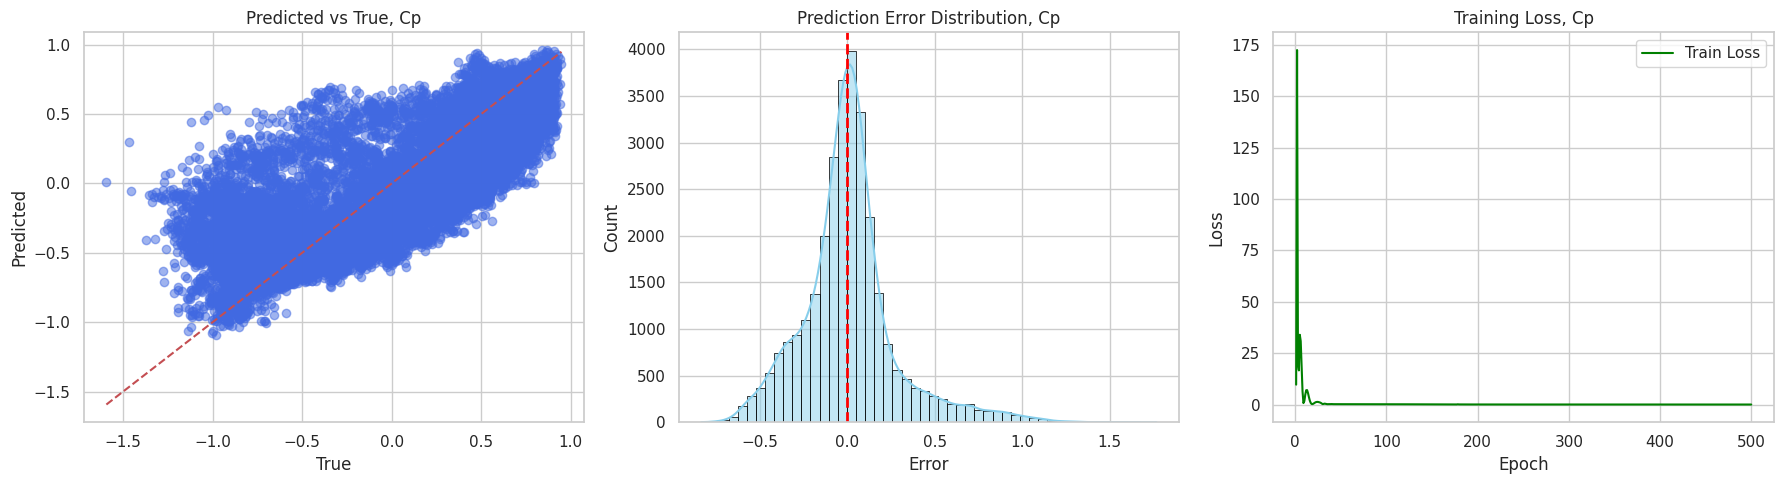

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 45/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 46/500 [00:00<00:02, 219.30it/s]

Epoch [10/500], Loss: 1.4308
Epoch [20/500], Loss: 0.4976
Epoch [30/500], Loss: 0.3833
Epoch [40/500], Loss: 0.4265
Epoch [50/500], Loss: 0.2436


Epochs:  18%|█▊        | 90/500 [00:00<00:01, 218.63it/s]

Epoch [60/500], Loss: 0.2179
Epoch [70/500], Loss: 0.1798
Epoch [80/500], Loss: 0.1645
Epoch [90/500], Loss: 0.1411
Epoch [100/500], Loss: 0.1219


Epochs:  27%|██▋       | 134/500 [00:00<00:01, 218.67it/s]

Epoch [110/500], Loss: 0.1117
Epoch [120/500], Loss: 0.1084
Epoch [130/500], Loss: 0.1059
Epoch [140/500], Loss: 0.1039
Epoch [150/500], Loss: 0.1067


Epochs:  40%|████      | 200/500 [00:00<00:01, 218.44it/s]

Epoch [160/500], Loss: 0.1022
Epoch [170/500], Loss: 0.0994
Epoch [180/500], Loss: 0.1503
Epoch [190/500], Loss: 0.1195
Epoch [200/500], Loss: 0.1066


Epochs:  49%|████▉     | 244/500 [00:01<00:01, 218.23it/s]

Epoch [210/500], Loss: 0.1013
Epoch [220/500], Loss: 0.0995
Epoch [230/500], Loss: 0.0982
Epoch [240/500], Loss: 0.0964
Epoch [250/500], Loss: 0.0946


Epochs:  58%|█████▊    | 288/500 [00:01<00:00, 218.20it/s]

Epoch [260/500], Loss: 0.0931
Epoch [270/500], Loss: 0.0913
Epoch [280/500], Loss: 0.0895
Epoch [290/500], Loss: 0.0882
Epoch [300/500], Loss: 0.0857


Epochs:  66%|██████▋   | 332/500 [00:01<00:00, 218.22it/s]

Epoch [310/500], Loss: 0.0840
Epoch [320/500], Loss: 0.0819
Epoch [330/500], Loss: 0.0795
Epoch [340/500], Loss: 0.0774
Epoch [350/500], Loss: 0.0760


Epochs:  80%|███████▉  | 398/500 [00:01<00:00, 218.04it/s]

Epoch [360/500], Loss: 0.0750
Epoch [370/500], Loss: 0.0735
Epoch [380/500], Loss: 0.0733
Epoch [390/500], Loss: 0.0714
Epoch [400/500], Loss: 0.0694


Epochs:  88%|████████▊ | 442/500 [00:02<00:00, 217.98it/s]

Epoch [410/500], Loss: 0.0710
Epoch [420/500], Loss: 0.0698
Epoch [430/500], Loss: 0.0692
Epoch [440/500], Loss: 0.0688
Epoch [450/500], Loss: 0.0669


Epochs: 100%|██████████| 500/500 [00:02<00:00, 218.25it/s]

Epoch [460/500], Loss: 0.0660
Epoch [470/500], Loss: 0.0668
Epoch [480/500], Loss: 0.0772
Epoch [490/500], Loss: 0.0749
Epoch [500/500], Loss: 0.0663
📈 Evaluation metrics on test set:
MSE: 0.0640
MAE: 0.1783
R2: 0.7387



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


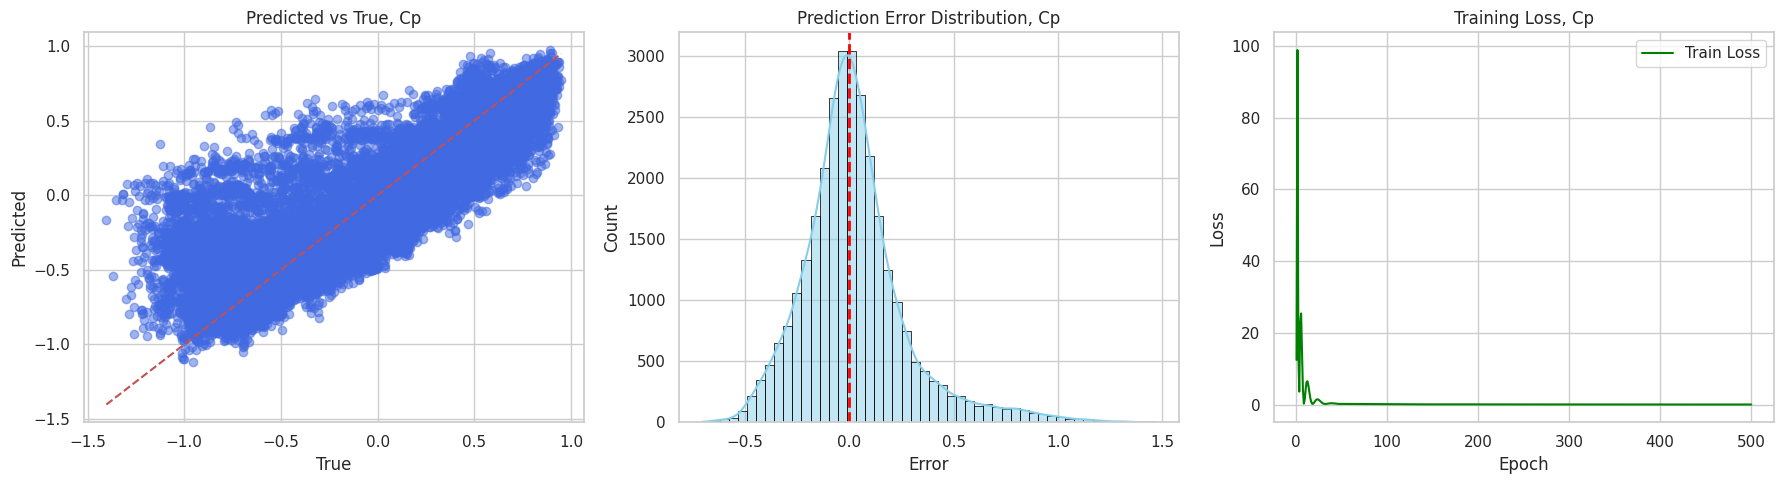

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 46/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 44/500 [00:00<00:02, 215.14it/s]

Epoch [10/500], Loss: 0.3633
Epoch [20/500], Loss: 2.2135
Epoch [30/500], Loss: 0.3772
Epoch [40/500], Loss: 0.3457
Epoch [50/500], Loss: 0.3081


Epochs:  18%|█▊        | 88/500 [00:00<00:01, 215.86it/s]

Epoch [60/500], Loss: 0.2398
Epoch [70/500], Loss: 0.2232
Epoch [80/500], Loss: 0.2136
Epoch [90/500], Loss: 0.2064
Epoch [100/500], Loss: 0.1995


Epochs:  26%|██▋       | 132/500 [00:00<00:01, 217.23it/s]

Epoch [110/500], Loss: 0.1966
Epoch [120/500], Loss: 0.1941
Epoch [130/500], Loss: 0.1914
Epoch [140/500], Loss: 0.1888
Epoch [150/500], Loss: 0.1859


Epochs:  40%|███▉      | 198/500 [00:00<00:01, 217.98it/s]

Epoch [160/500], Loss: 0.1830
Epoch [170/500], Loss: 0.1800
Epoch [180/500], Loss: 0.1772
Epoch [190/500], Loss: 0.1629
Epoch [200/500], Loss: 0.1380


Epochs:  48%|████▊     | 242/500 [00:01<00:01, 218.07it/s]

Epoch [210/500], Loss: 0.1246
Epoch [220/500], Loss: 0.1188
Epoch [230/500], Loss: 0.1126
Epoch [240/500], Loss: 0.1056
Epoch [250/500], Loss: 0.1008


Epochs:  57%|█████▋    | 286/500 [00:01<00:00, 217.39it/s]

Epoch [260/500], Loss: 0.0973
Epoch [270/500], Loss: 0.0946
Epoch [280/500], Loss: 0.0926
Epoch [290/500], Loss: 0.0909
Epoch [300/500], Loss: 0.0894


Epochs:  70%|███████   | 352/500 [00:01<00:00, 217.51it/s]

Epoch [310/500], Loss: 0.0881
Epoch [320/500], Loss: 0.0868
Epoch [330/500], Loss: 0.0857
Epoch [340/500], Loss: 0.0848
Epoch [350/500], Loss: 0.0839


Epochs:  79%|███████▉  | 396/500 [00:01<00:00, 217.79it/s]

Epoch [360/500], Loss: 0.0832
Epoch [370/500], Loss: 0.0825
Epoch [380/500], Loss: 0.0830
Epoch [390/500], Loss: 0.0819
Epoch [400/500], Loss: 0.0821


Epochs:  88%|████████▊ | 440/500 [00:02<00:00, 217.88it/s]

Epoch [410/500], Loss: 0.0814
Epoch [420/500], Loss: 0.0806
Epoch [430/500], Loss: 0.0804
Epoch [440/500], Loss: 0.0798
Epoch [450/500], Loss: 0.0796


Epochs: 100%|██████████| 500/500 [00:02<00:00, 217.49it/s]

Epoch [460/500], Loss: 0.0791
Epoch [470/500], Loss: 0.0788
Epoch [480/500], Loss: 0.0785
Epoch [490/500], Loss: 0.0782
Epoch [500/500], Loss: 0.0780
📈 Evaluation metrics on test set:
MSE: 0.0783
MAE: 0.1971
R2: 0.6829



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


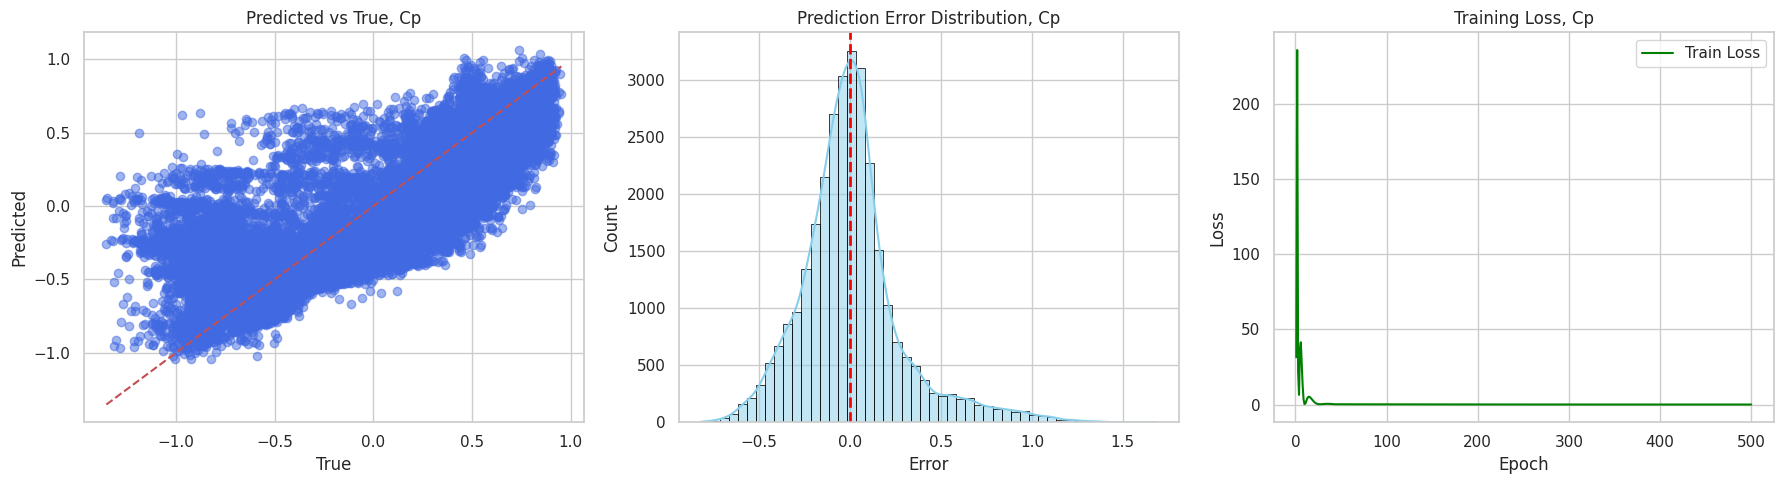

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 47/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 44/500 [00:00<00:02, 212.47it/s]

Epoch [10/500], Loss: 4.2501
Epoch [20/500], Loss: 0.8307
Epoch [30/500], Loss: 0.5653
Epoch [40/500], Loss: 0.3281
Epoch [50/500], Loss: 0.2378


Epochs:  18%|█▊        | 88/500 [00:00<00:01, 214.76it/s]

Epoch [60/500], Loss: 0.2261
Epoch [70/500], Loss: 0.2136
Epoch [80/500], Loss: 0.2030
Epoch [90/500], Loss: 0.1852
Epoch [100/500], Loss: 0.1728


Epochs:  26%|██▋       | 132/500 [00:00<00:01, 216.79it/s]

Epoch [110/500], Loss: 0.1613
Epoch [120/500], Loss: 0.1506
Epoch [130/500], Loss: 0.1393
Epoch [140/500], Loss: 0.1284
Epoch [150/500], Loss: 0.1221


Epochs:  40%|███▉      | 198/500 [00:00<00:01, 217.59it/s]

Epoch [160/500], Loss: 0.1129
Epoch [170/500], Loss: 0.1080
Epoch [180/500], Loss: 0.1054
Epoch [190/500], Loss: 0.1033
Epoch [200/500], Loss: 0.0983


Epochs:  48%|████▊     | 242/500 [00:01<00:01, 217.30it/s]

Epoch [210/500], Loss: 0.0951
Epoch [220/500], Loss: 0.0980
Epoch [230/500], Loss: 0.0912
Epoch [240/500], Loss: 0.0914
Epoch [250/500], Loss: 0.0886


Epochs:  57%|█████▋    | 286/500 [00:01<00:00, 217.21it/s]

Epoch [260/500], Loss: 0.0868
Epoch [270/500], Loss: 0.0861
Epoch [280/500], Loss: 0.0854
Epoch [290/500], Loss: 0.0848
Epoch [300/500], Loss: 0.0912


Epochs:  70%|███████   | 352/500 [00:01<00:00, 217.59it/s]

Epoch [310/500], Loss: 0.0844
Epoch [320/500], Loss: 0.0827
Epoch [330/500], Loss: 0.0817
Epoch [340/500], Loss: 0.0810
Epoch [350/500], Loss: 0.0805


Epochs:  79%|███████▉  | 396/500 [00:01<00:00, 217.49it/s]

Epoch [360/500], Loss: 0.0800
Epoch [370/500], Loss: 0.0808
Epoch [380/500], Loss: 0.0794
Epoch [390/500], Loss: 0.0784
Epoch [400/500], Loss: 0.0779


Epochs:  88%|████████▊ | 440/500 [00:02<00:00, 217.58it/s]

Epoch [410/500], Loss: 0.0773
Epoch [420/500], Loss: 0.0794
Epoch [430/500], Loss: 0.0795
Epoch [440/500], Loss: 0.0764
Epoch [450/500], Loss: 0.0751


Epochs: 100%|██████████| 500/500 [00:02<00:00, 217.08it/s]

Epoch [460/500], Loss: 0.0745
Epoch [470/500], Loss: 0.0736
Epoch [480/500], Loss: 0.0736
Epoch [490/500], Loss: 0.0753
Epoch [500/500], Loss: 0.0731
📈 Evaluation metrics on test set:
MSE: 0.0724
MAE: 0.1925
R2: 0.7071



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


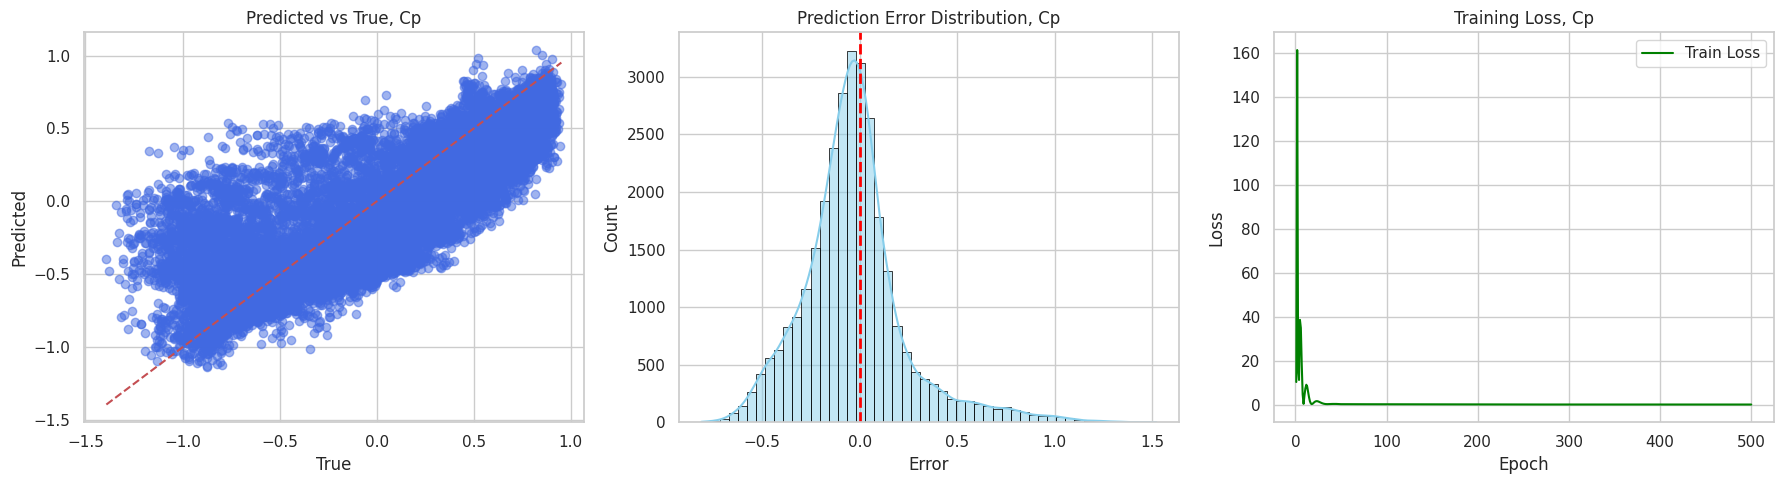

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 48/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   7%|▋         | 35/500 [00:00<00:02, 172.15it/s]

Epoch [10/500], Loss: 0.8076
Epoch [20/500], Loss: 0.9526
Epoch [30/500], Loss: 0.3699
Epoch [40/500], Loss: 0.2503


Epochs:  16%|█▌        | 78/500 [00:00<00:02, 195.30it/s]

Epoch [50/500], Loss: 0.2143
Epoch [60/500], Loss: 0.2042
Epoch [70/500], Loss: 0.2009
Epoch [80/500], Loss: 0.1967
Epoch [90/500], Loss: 0.1914


Epochs:  24%|██▍       | 122/500 [00:00<00:01, 208.39it/s]

Epoch [100/500], Loss: 0.1867
Epoch [110/500], Loss: 0.1886
Epoch [120/500], Loss: 0.1806
Epoch [130/500], Loss: 0.1757
Epoch [140/500], Loss: 0.1716


Epochs:  38%|███▊      | 188/500 [00:00<00:01, 214.85it/s]

Epoch [150/500], Loss: 0.1676
Epoch [160/500], Loss: 0.1636
Epoch [170/500], Loss: 0.1594
Epoch [180/500], Loss: 0.1552
Epoch [190/500], Loss: 0.1509


Epochs:  46%|████▋     | 232/500 [00:01<00:01, 216.35it/s]

Epoch [200/500], Loss: 0.1345
Epoch [210/500], Loss: 0.1169
Epoch [220/500], Loss: 0.1108
Epoch [230/500], Loss: 0.1052
Epoch [240/500], Loss: 0.1030


Epochs:  55%|█████▌    | 276/500 [00:01<00:01, 217.20it/s]

Epoch [250/500], Loss: 0.1006
Epoch [260/500], Loss: 0.0988
Epoch [270/500], Loss: 0.0974
Epoch [280/500], Loss: 0.0958
Epoch [290/500], Loss: 0.0943


Epochs:  68%|██████▊   | 342/500 [00:01<00:00, 217.25it/s]

Epoch [300/500], Loss: 0.0931
Epoch [310/500], Loss: 0.0918
Epoch [320/500], Loss: 0.0908
Epoch [330/500], Loss: 0.0914
Epoch [340/500], Loss: 0.0889


Epochs:  77%|███████▋  | 386/500 [00:01<00:00, 217.30it/s]

Epoch [350/500], Loss: 0.0880
Epoch [360/500], Loss: 0.0887
Epoch [370/500], Loss: 0.0870
Epoch [380/500], Loss: 0.0858
Epoch [390/500], Loss: 0.0849


Epochs:  86%|████████▌ | 430/500 [00:02<00:00, 217.36it/s]

Epoch [400/500], Loss: 0.0839
Epoch [410/500], Loss: 0.0830
Epoch [420/500], Loss: 0.0822
Epoch [430/500], Loss: 0.0816
Epoch [440/500], Loss: 0.0834


Epochs:  95%|█████████▍| 474/500 [00:02<00:00, 217.60it/s]

Epoch [450/500], Loss: 0.0805
Epoch [460/500], Loss: 0.0804
Epoch [470/500], Loss: 0.0791
Epoch [480/500], Loss: 0.0784
Epoch [490/500], Loss: 0.0776


Epochs: 100%|██████████| 500/500 [00:02<00:00, 212.44it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0771
📈 Evaluation metrics on test set:
MSE: 0.0785
MAE: 0.1979
R2: 0.6849


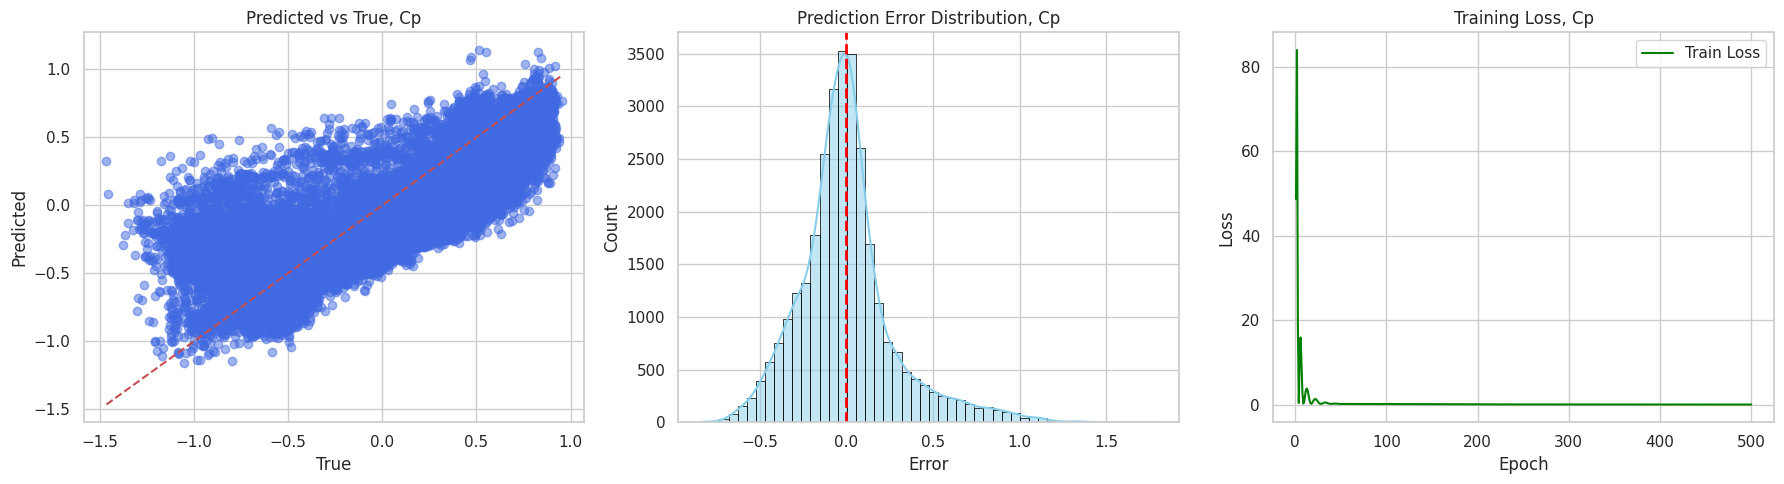

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 49/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   9%|▉         | 44/500 [00:00<00:02, 206.76it/s]

Epoch [10/500], Loss: 1.5186
Epoch [20/500], Loss: 0.9210
Epoch [30/500], Loss: 0.9480
Epoch [40/500], Loss: 0.2767
Epoch [50/500], Loss: 0.2523


Epochs:  18%|█▊        | 88/500 [00:00<00:01, 212.44it/s]

Epoch [60/500], Loss: 0.2199
Epoch [70/500], Loss: 0.2172
Epoch [80/500], Loss: 0.2091
Epoch [90/500], Loss: 0.2051
Epoch [100/500], Loss: 0.2004


Epochs:  26%|██▋       | 132/500 [00:00<00:01, 215.53it/s]

Epoch [110/500], Loss: 0.1940
Epoch [120/500], Loss: 0.1847
Epoch [130/500], Loss: 0.1708
Epoch [140/500], Loss: 0.1514
Epoch [150/500], Loss: 0.2101


Epochs:  40%|███▉      | 198/500 [00:00<00:01, 216.99it/s]

Epoch [160/500], Loss: 0.1611
Epoch [170/500], Loss: 0.1364
Epoch [180/500], Loss: 0.1271
Epoch [190/500], Loss: 0.1213
Epoch [200/500], Loss: 0.1168


Epochs:  48%|████▊     | 242/500 [00:01<00:01, 216.98it/s]

Epoch [210/500], Loss: 0.1129
Epoch [220/500], Loss: 0.1095
Epoch [230/500], Loss: 0.1067
Epoch [240/500], Loss: 0.1044
Epoch [250/500], Loss: 0.1025


Epochs:  57%|█████▋    | 286/500 [00:01<00:00, 217.35it/s]

Epoch [260/500], Loss: 0.1007
Epoch [270/500], Loss: 0.0991
Epoch [280/500], Loss: 0.0975
Epoch [290/500], Loss: 0.0960
Epoch [300/500], Loss: 0.0945


Epochs:  70%|███████   | 352/500 [00:01<00:00, 218.06it/s]

Epoch [310/500], Loss: 0.0932
Epoch [320/500], Loss: 0.0920
Epoch [330/500], Loss: 0.0909
Epoch [340/500], Loss: 0.0899
Epoch [350/500], Loss: 0.0890


Epochs:  79%|███████▉  | 396/500 [00:01<00:00, 218.02it/s]

Epoch [360/500], Loss: 0.0881
Epoch [370/500], Loss: 0.0872
Epoch [380/500], Loss: 0.0864
Epoch [390/500], Loss: 0.0856
Epoch [400/500], Loss: 0.0849


Epochs:  88%|████████▊ | 440/500 [00:02<00:00, 218.16it/s]

Epoch [410/500], Loss: 0.0841
Epoch [420/500], Loss: 0.0835
Epoch [430/500], Loss: 0.0828
Epoch [440/500], Loss: 0.0820
Epoch [450/500], Loss: 0.0813


Epochs: 100%|██████████| 500/500 [00:02<00:00, 216.58it/s]

Epoch [460/500], Loss: 0.0807
Epoch [470/500], Loss: 0.0799
Epoch [480/500], Loss: 0.0790
Epoch [490/500], Loss: 0.0775
Epoch [500/500], Loss: 0.0765
📈 Evaluation metrics on test set:
MSE: 0.0755
MAE: 0.1942
R2: 0.6934



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


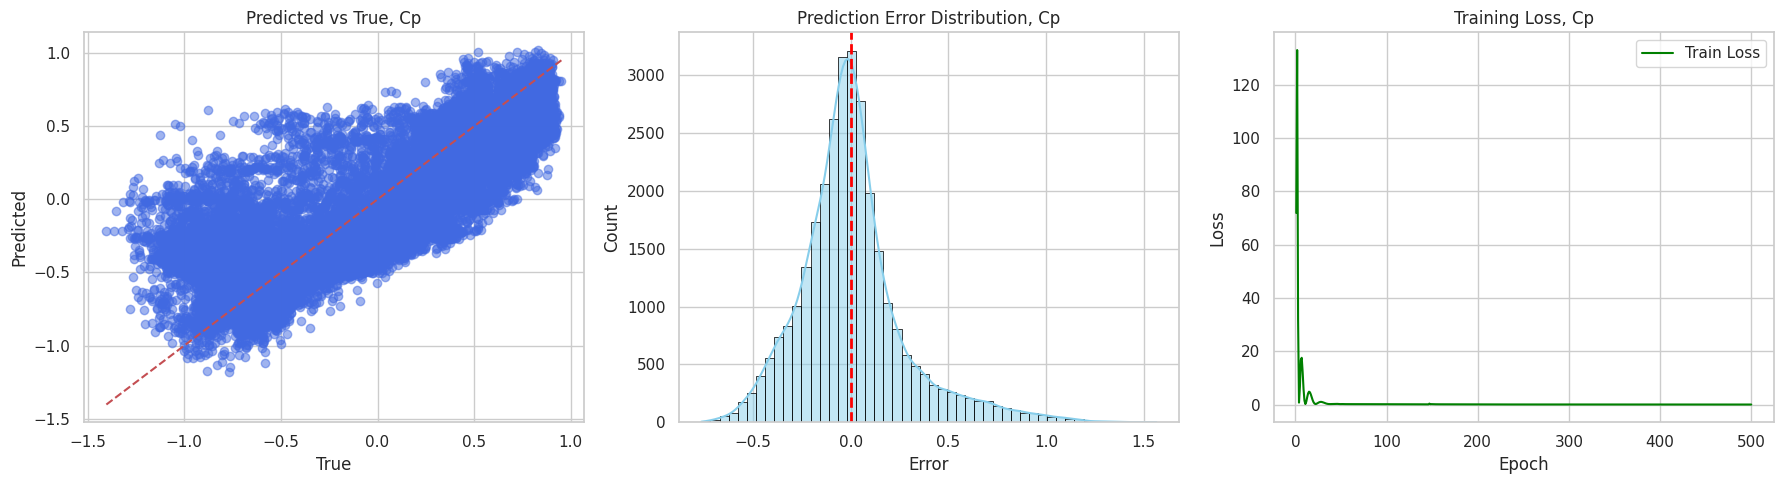

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png

🔁 Run 50/50
→ hidden_dim: 64, lr: 0.01000
Dataset loaded: 151392 rows, 15 columns
🛠 Device: cuda
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep


Epochs:   7%|▋         | 36/500 [00:00<00:02, 167.76it/s]

Epoch [10/500], Loss: 0.3634
Epoch [20/500], Loss: 1.1172
Epoch [30/500], Loss: 0.2347
Epoch [40/500], Loss: 0.2242


Epochs:  16%|█▌        | 79/500 [00:00<00:02, 198.41it/s]

Epoch [50/500], Loss: 0.2183
Epoch [60/500], Loss: 0.2104
Epoch [70/500], Loss: 0.1998
Epoch [80/500], Loss: 0.1609
Epoch [90/500], Loss: 0.1474


Epochs:  25%|██▍       | 123/500 [00:00<00:01, 209.85it/s]

Epoch [100/500], Loss: 0.1369
Epoch [110/500], Loss: 0.1292
Epoch [120/500], Loss: 0.1231
Epoch [130/500], Loss: 0.1181
Epoch [140/500], Loss: 0.1137


Epochs:  38%|███▊      | 189/500 [00:00<00:01, 215.58it/s]

Epoch [150/500], Loss: 0.1109
Epoch [160/500], Loss: 0.1086
Epoch [170/500], Loss: 0.1068
Epoch [180/500], Loss: 0.1060
Epoch [190/500], Loss: 0.1052


Epochs:  47%|████▋     | 233/500 [00:01<00:01, 216.56it/s]

Epoch [200/500], Loss: 0.1032
Epoch [210/500], Loss: 0.1023
Epoch [220/500], Loss: 0.1013
Epoch [230/500], Loss: 0.1005
Epoch [240/500], Loss: 0.0999


Epochs:  55%|█████▌    | 277/500 [00:01<00:01, 217.15it/s]

Epoch [250/500], Loss: 0.0993
Epoch [260/500], Loss: 0.0996
Epoch [270/500], Loss: 0.0973
Epoch [280/500], Loss: 0.0963
Epoch [290/500], Loss: 0.0954


Epochs:  69%|██████▊   | 343/500 [00:01<00:00, 217.42it/s]

Epoch [300/500], Loss: 0.0946
Epoch [310/500], Loss: 0.0939
Epoch [320/500], Loss: 0.0929
Epoch [330/500], Loss: 0.0937
Epoch [340/500], Loss: 0.0913


Epochs:  77%|███████▋  | 387/500 [00:01<00:00, 217.37it/s]

Epoch [350/500], Loss: 0.0901
Epoch [360/500], Loss: 0.0915
Epoch [370/500], Loss: 0.0889
Epoch [380/500], Loss: 0.0867
Epoch [390/500], Loss: 0.0855


Epochs:  86%|████████▌ | 431/500 [00:02<00:00, 217.31it/s]

Epoch [400/500], Loss: 0.0845
Epoch [410/500], Loss: 0.0964
Epoch [420/500], Loss: 0.0869
Epoch [430/500], Loss: 0.0822
Epoch [440/500], Loss: 0.0807


Epochs:  95%|█████████▌| 475/500 [00:02<00:00, 217.25it/s]

Epoch [450/500], Loss: 0.0794
Epoch [460/500], Loss: 0.0787
Epoch [470/500], Loss: 0.0777
Epoch [480/500], Loss: 0.0774
Epoch [490/500], Loss: 0.0764


Epochs: 100%|██████████| 500/500 [00:02<00:00, 212.78it/s]
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Epoch [500/500], Loss: 0.0761
📈 Evaluation metrics on test set:
MSE: 0.0774
MAE: 0.1977
R2: 0.6894


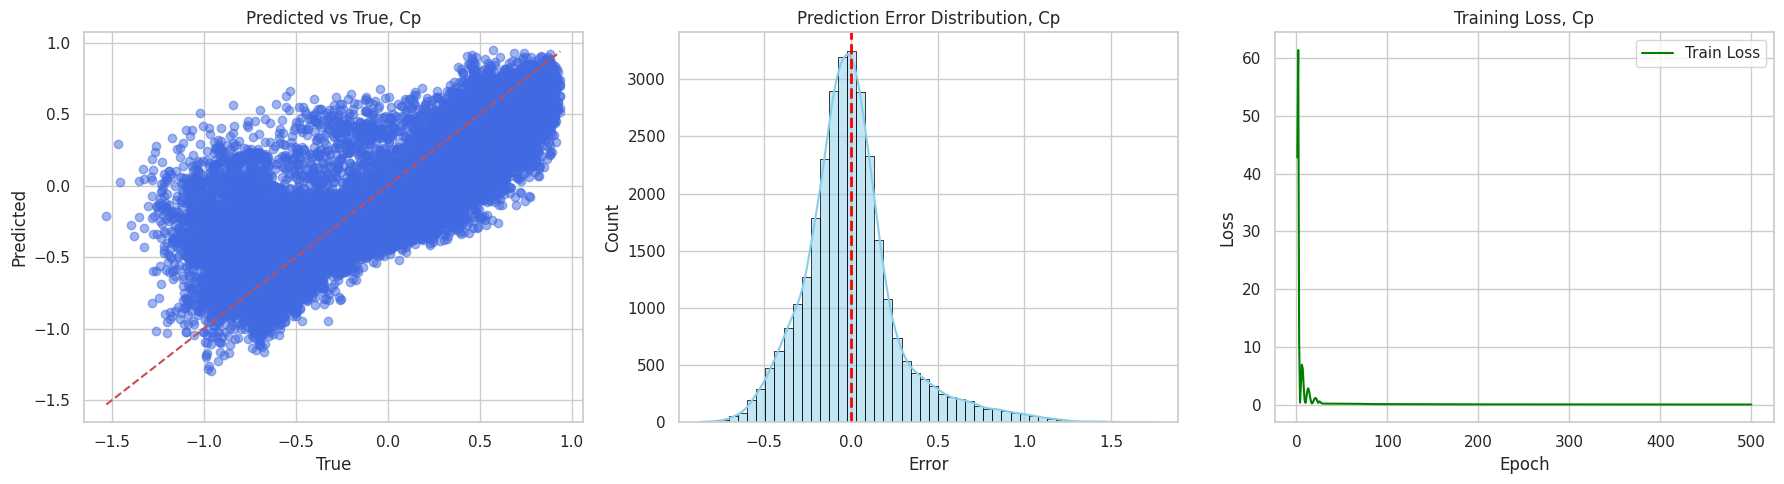

📊 Metric saved: /kaggle/working/tuning_mlp/mlp_64h_1e-02lr_64bs_500ep/loss_plot.png


In [9]:
# 📁 src/tuning/random_search_mlp.py
# ➤ Random Search for MLP model: selects hyperparameters and launches training

# 🔧 Hyperparameter options
hidden_dim_choices = [64]
lr_choices = [round(0.01, 5)]

#hidden_dim_choices = [128, 264]
#lr_choices = [ 1e-3, 5e-3]

# 📌 Fixed parameters
EPOCHS = 500
BATCH_SIZE = 64
OUTPUT_DIM = 1
#N_RUNS = 10  # Total number of runs
N_RUNS = 50  # Total number of runs

# 🧪 Random Search loop
for run in range(N_RUNS):
    # Randomly select hyperparameters
    hidden_dim = random.choice(hidden_dim_choices)
    lr = random.choice(lr_choices)

    # Display current configuration
    print(f"\n🔁 Run {run + 1}/{N_RUNS}")
    print(f"→ hidden_dim: {hidden_dim}, lr: {lr:.5f}")

    # Train model with current hyperparameters
    train_mlp(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        output_dim=OUTPUT_DIM
    )

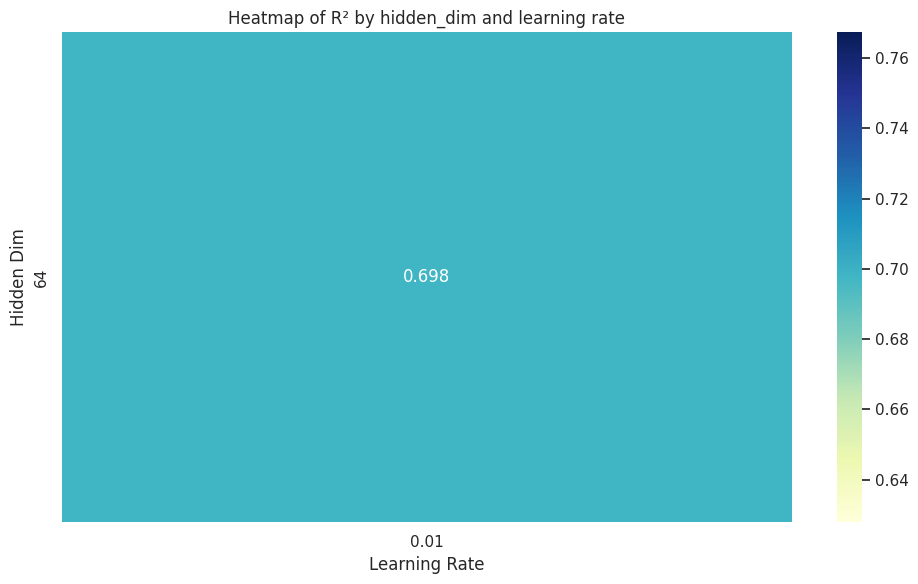


🏆 Best result:
Run ID      : mlp_64h_1e-02lr_64bs_500ep
Hidden Dim  : 64
Learning Rate: 0.01000
R²          : 0.7674
MAE         : 0.1622
MSE         : 0.057572

📌 R² threshold (95% of max): 0.7290
🔍 Found 9 stable candidates:

    hidden_dim    lr      R2     MAE       MSE
4           64  0.01  0.7674  0.1622  0.057572
26          64  0.01  0.7629  0.1687  0.058530
14          64  0.01  0.7536  0.1721  0.061566
44          64  0.01  0.7387  0.1783  0.063967
40          64  0.01  0.7374  0.1779  0.064398
5           64  0.01  0.7371  0.1776  0.064648
38          64  0.01  0.7317  0.1803  0.066403
27          64  0.01  0.7297  0.1790  0.066773
20          64  0.01  0.7291  0.1790  0.066651


In [10]:
# 📁 src/tuning/visualize_search_results.py
# ➤ Heatmap visualization of R² scores across hidden_dim and learning rate combinations

# 📥 Load experiments log
log_path = "experiments/experiments_log.csv"
df_log = pd.read_csv(LOG_CSV_PATH, header=None)
df_log.columns = ["run_id", "hidden_dim", "lr", "R2", "MAE", "MSE"]

# 📊 Pivot table for heatmap
pivot_table = df_log.pivot_table(
    values="R2",
    index="hidden_dim",
    columns="lr",
    aggfunc="mean"  # handles repeated runs with same params
)

# 🔥 Draw heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Heatmap of R² by hidden_dim and learning rate")
plt.xlabel("Learning Rate")
plt.ylabel("Hidden Dim")
plt.tight_layout()
plt.show()

# 🏆 Show best configuration
best_row = df_log.loc[df_log["R2"].idxmax()]
print("\n🏆 Best result:")
print(f"Run ID      : {best_row['run_id']}")
print(f"Hidden Dim  : {int(best_row['hidden_dim'])}")
print(f"Learning Rate: {best_row['lr']:.5f}")
print(f"R²          : {best_row['R2']:.4f}")
print(f"MAE         : {best_row['MAE']:.4f}")
print(f"MSE         : {best_row['MSE']:.6f}")

# ------------------------------
# 📊 Зона стабильных параметров по R²
# ------------------------------

# 1. Максимальное значение R²
r2_max = df_log["R2"].max()

# 2. Порог: 95% от максимума
threshold = r2_max * 0.95
print(f"\n📌 R² threshold (95% of max): {threshold:.4f}")

# 3. Отбираем устойчиво хорошие параметры
stable_zone = df_log[df_log["R2"] >= threshold]
print(f"🔍 Found {len(stable_zone)} stable candidates:\n")

# 4. Выводим таблицу устойчивых параметров
print(stable_zone.sort_values("R2", ascending=False)[["hidden_dim", "lr", "R2", "MAE", "MSE"]])

